# Error Mitigation: Zero Noise Extrapolation (ZNE) for indirect-control system
---

_This notebook contains experimental results for Zero Noise Extrapolation (ZNE) in an indirect-control system._

Zero-Noise Extrapolation (ZNE) is one of the most widely used techniques in quantum error mitigation to estimate the expectation value of an observable under noise-free conditions. In ZNE, noise is intentionally introduced into the quantum circuit, and the expectation value of the target observable is measured at different noise levels. Once sufficient data is collected, we extrapolate this data to the zero-noise limit.

There are several strategies for zero-noise extrapolation, with the Richardson extrapolation technique being perhaps the most common. Here, we adapted the multivariate framework of Richardson extrapolation as discussed in the paper [_"Quantum error mitigation by layerwise Richardson extrapolation" by Vincent Russo and Andrea Mari (arXiv:2402.04000, 2024)_](https://arxiv.org/abs/2402.04000).

### A. The code for multivariate Richardson extrapolation

#### Imports and set up for plot

In [21]:
# Importing modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from typing import List, Tuple
from collections import Counter
import itertools
import scipy.linalg as la
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#### Multivariate Richardson extrapolation

In [22]:
"""
We have used the multivariate framework for Richardson extrapolation as discussed in the paper
"Quantum error mitigation by layerwise Richardson extrapolation" by Vincent Russo and Andrea
Mari (arXiv:2402.04000, 2024).

Parts of the following code are adapted from their notebook, which can be found at the
following GitHub repository: 
https://github.com/unitaryfund/research/blob/main/lre/layerwise_richardson_extrapolation.ipynb.
"""

class ZeroNoiseExtrapolation:
    def __init__(self, dataPoints: list[tuple[float]], degree: int):
        """
        Initialize with a list of data points, each represented as a tuple of floats.
        """
        self.dataPoints = dataPoints
        self.degree = degree

        unknown_var = len(dataPoints[0]) - 1
        self.NoiseData = [tuple(point[: unknown_var]) for point in self.dataPoints]
        self.ExpectationVals = [point[-1] for point in dataPoints]

    def get_noise_levels(self):
        return self.NoiseData
    
    def get_expec_vals(self):
        return self.ExpectationVals
    
    def getRichardsonZNE(self):

        RichardsonZNEval = 0

        sampleMatrix = self.sample_matrix(sample_points = self.NoiseData, degree = self.degree) # type: ignore
        detA = np.linalg.det(sampleMatrix)
        if abs(detA) <= 1e-9:
            raise ValueError(f"Determinant of sample matrix is/close to zero. Det: {detA}, Deg: {self.degree}")
        # elif abs(detA) >= 1e+50:
        #     raise ValueError(f"Determinant of sample matrix close to inf. Det: {detA}, Deg: {self.degree}")
        
        matrices = self.generate_modified_matrices(sampleMatrix) # type: ignore

        if len(self.ExpectationVals) != len(matrices):
            raise ValueError(f"Unmatched length.")
        
        for E, matrix in zip(self.ExpectationVals, matrices):
            eta = (np.linalg.det(matrix)/detA)
            RichardsonZNEval += E * eta
            eta = 0
        
        return RichardsonZNEval
    
    def getRichardsonZNE2(self):

        RichardsonZNEval = 0
        E_vals = 0
        sampleMatrix = self.sample_matrix(sample_points = self.NoiseData, degree = self.degree)
        etas = self.get_eta_coeffs_from_sample_matrix(sampleMatrix)
        # E_vals = self.ExpectationVals.copy()
        # E_vals.reverse()
        print(f"E_vals: {E_vals}")
        for E, eta in zip(self.ExpectationVals, etas):
            RichardsonZNEval += E*eta

        return RichardsonZNEval
    
    def getRichardsonSingleZNE(self):

        RichardsonZNEval = 0
        noise_list = [x[0] for x in self.NoiseData]
        etas = self.get_eta_coeffs_single_variable(noise_list)

        for E, eta in zip(self.ExpectationVals, etas):
            RichardsonZNEval += E*eta

        return RichardsonZNEval
     
    @staticmethod
    def get_monomials(n: int, d: int) -> list[str]:
        """
        Compute monomials of degree `d` in graded lexicographical order.
        """
        variables = [f"λ_{i}" for i in range(1, n + 1)]
        
        monomials = []
        for degree in range(d, -1, -1):
            # Generate combinations for the current degree
            combos = list(itertools.combinations_with_replacement(variables, degree))
            
            # Sort combinations lexicographically
            combos.sort()
            
            # Construct monomials from sorted combinations
            for combo in combos:
                monomial_parts = []
                counts = Counter(combo)
                # Ensure variables are processed in lexicographical order
                for var in sorted(counts.keys()):
                    count = counts[var]
                    if count > 1:
                        monomial_parts.append(f"{var}**{count}")
                    else:
                        monomial_parts.append(var)
                monomial = "*".join(monomial_parts)
                # Handle the case where degree is 0
                if not monomial:
                    monomial = "1"
                monomials.append(monomial)
        # "1" should be the first monomial. Note that order d > c > b > a means vector of monomials = [a, b, c, d].            
        return monomials[::-1]

    @staticmethod
    def sample_matrix(sample_points: list[int], degree: int) -> np.ndarray:
        """Construct a matrix from monomials evaluated at sample points."""
        n = len(sample_points[0])  # type: ignore # Number of variables based on the first sample point
        monomials = ZeroNoiseExtrapolation.get_monomials(n, degree) # type: ignore
        matrix = np.zeros((len(sample_points), len(monomials)))

        for i, point in enumerate(sample_points):
            for j, monomial in enumerate(monomials):
                var_mapping = {f"λ_{k+1}": point[k] for k in range(n)} # type: ignore
                matrix[i, j] = eval(monomial, {}, var_mapping)
        return matrix
    
    @staticmethod
    def get_eta_coeffs_from_sample_matrix(mat: np.ndarray) -> list[float]:
        """Given a sample matrix compute the eta coefficients."""
        n_rows, n_cols = mat.shape
        if n_rows != n_cols:
            raise ValueError("The matrix must be square.")

        det_m = np.linalg.det(mat)    
        if det_m == 0:
            raise ValueError("The matrix is singular.")
        
        terms = []
        for i in range(n_rows):
            new_mat = mat.copy()
            new_mat[i] = np.array([[0] * (n_cols - 1) + [1]])        
            terms.append(np.linalg.det(new_mat) / det_m)

        return terms
    
    @staticmethod
    def get_eta_coeffs_single_variable(scale_factors: list[float]) -> list[float]:
        """Returns the array of single-variable Richardson extrapolation coefficients associated
        to the input array of scale factors."""
        
        # Lagrange interpolation formula.
        richardson_coeffs = []
        for l in scale_factors:
            coeff = 1.0
            for l_prime in scale_factors:
                if l_prime == l:
                    continue
                coeff *= l_prime / (l_prime - l)
            richardson_coeffs.append(coeff)

        return richardson_coeffs

    @staticmethod
    def generate_modified_matrices(matrix):
        """
        It generates the Mi(0) matreces for i = 1 to length of sample matrix.
        See this papaer for the detail mathematical formalism: 
        "Quantum error mitigation by layerwise Richardson extrapolation" by Vincent Russo, Andrea Mari, https://arxiv.org/abs/2402.04000
        """
        n = len(matrix)  # Size of the square matrix
        identity_row = [1] + [0] * (n - 1)  # Row to replace with

        modified_matrices = []
        determinants = []
        for i in range(n):
            # Create a copy of the original matrix
            modified_matrix = np.copy(matrix)
            # Replace the i-th row with the identity_row
            modified_matrix[i] = identity_row
            modified_matrices.append(modified_matrix)
            # Calculate the determinant of the modified matrix
            determinant = np.linalg.det(modified_matrix)
            determinants.append(determinant)
        
        return modified_matrices    

In [23]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 11

### B. How to use the code

### C. Experimental data

We have obtained expectation value of the target observable at various noise level for a 4-qubit and 8-qubit system. The following data can be reprodeced using the optimized parameters as initial parameters for at different noise factors.

In [58]:
"""
7-qubit system with 30 layers.
Exact sol: 
Noise prpbabilities: [0.001, 0.001, 0.001, 0.001]
Optimized parameters without time constraint:  [-0.34545182692766746, -1.2820118876247293, -0.5110289047962121, -0.4199325518965812, 0.03911696408226401, 0.2285065289229423, 1.9102132155513922, 1.6738219599679622, 1.618293447504402, 1.7149022802574638, 1.5955539102621348, 2.7741086532209707, 2.7844918719362797, 3.8197231808292242, 3.799640885518896, 5.076728736730183, 5.146566414752825, 5.231167518188314, 5.486513162327813, 5.47501041517743, 5.193919937496742, 6.3324886466747365, 6.332797919525384, 9.272344131595027, 8.884493018495537, 9.479336908518198, 9.07803475418138, 10.156366590481063, 9.582373842936011, 9.424520199277708, 1.3045881332560165, -0.7355339216184653, 0.4246800861307837, -1.3530927883080306, -0.6015547866811153, -0.6845767073552239, -0.6908546018719182, -1.5891701570464118, 0.019167761737960365, 0.3167499708418659, 0.6541936677801866, 0.006123254329934657, -0.3290409739994733, 0.1359600520165875, 0.42157788593568823, 0.27174579300163687, -0.022737111113007108, -0.13218104567007133, 0.9925953862287753, -0.46282261297394417, -1.6953925279770938, -0.42269720990830234, 1.387706517458636, -0.004290644507143154, 0.11140253688458292, -1.457693319961736, -0.6551231421004615, 1.2975132418887354, 0.10102034976806921, 0.26829776733022503, -0.14671197698384805, -0.027049337353448374, -0.402440735378578, 0.03562459554683618, 0.568552931769602, -2.1035952379672915, -0.28950914765166685, 0.24199403032283562, -0.04800343985330724, 0.26356259292623807, 0.5945312648159254, -0.20232165877888286, 1.7154888886172106, -0.6284742778411855, 0.006012888244294822, 0.0025194848743282016, 1.456303462667846, -0.6750834111432115, 0.9638545307129583, -0.3225504908346628, 1.001843519649087, -0.007738997334413549, -0.35467479312376415, -0.058340592001693614, -0.6514302856608905, -0.6179897676342221, 0.570885857189661, 0.1148340730470395, 0.0037456240681070715, -0.0072810584974053565, 0.42127824633742555, 0.024509741139851313, 0.3331352137392177, 0.388464381475039, 0.09309955131082358, 0.5192710265701636, 2.189253271705422, 0.10600473507370695, -1.0520560398923349, 0.17000233599412354, -0.6125230936738332, 1.0490158665470986, 0.29711493094092445, 0.9754483216667831, -0.16238771373950792, -0.06457141100951487, 0.2661315005280838, -0.23416570549951043, 0.09604782305926357, -0.08385048858156077, -1.6672471738142087, 0.11155805455313673, 0.40294946077235905, -0.13533582197195143, -0.7118216059893397, -0.08478908323065786, -0.38239934719805946, 0.9862887008832043, 0.332365889763499, -0.6167142370494763, -0.3132105627995447, -0.045704500825569754, 1.3230956843885902, -0.47656024666473357, -0.12193581830976508, 0.9421005282620709, -1.1563790227063862, 0.5539780834468186, -1.3550339470284172, -0.09872661132179708, 0.519725963274215, -1.1407341473142667, 0.10895648394703784, 0.39384343271975486, -1.6099412995366125, -0.1651026294368791, 0.4805253541280353, 0.664341970093822, 1.1710242945226073, 2.3756203728905456, 0.7205061680999506, -0.6703842088687892, -1.000872951082473, 0.30954957407747175, -1.2800575711936275, -0.04181692595073606, 0.08371737051352196, -1.1507841651646535, -1.6418481517268457, -0.6092175661451812]
"""
data_Q7N1 = [
    (4, 1, 0, -4.8169220971038795), # Noise factor [0, 0, 0]
    (12, 1, 0, -4.2189237350915185), # Noise factor [1, 0, 0]
    (12, 3, 4, -2.9070960640998686), # Noise factor [1, 1, 0]
    (12, 3, 12, -2.253565700341366), # Noise factor [1, 1, 1]

    (20, 1, 0, -3.701640647812517), # Noise factor [2, 0, 0]
    (20, 3, 4, -2.5556168431723947), # Noise factor [2, 1, 0]
    (20, 3, 12, -1.9834895523974967), # Noise factor [2, 1, 1]
    (20, 5, 4, -1.7784106506781265), # Noise factor [2, 2, 0]
    (20, 5, 12, -1.086614154166062), # Noise factor [2, 2, 1]
    (20, 5, 20, -0.6731855339471752), # Noise factor [2, 2, 2]

    (28, 1, 0, -3.2530466718309436), # Noise factor [3, 0, 0]
    (28, 3, 4, -2.249816877366662), # Noise factor [3, 1, 0]
    (28, 3, 12, -1.7479790647310043), # Noise factor [3, 1, 1]
    (28, 5, 4, -1.56801564275309), # Noise factor [3, 2, 0]
    (28, 5, 12, -0.9596543348762642), # Noise factor [3, 2, 1]
    (28, 5, 20, -0.5952369595178605), # Noise factor [3, 2, 2]
    (28, 7, 4, -1.1009119771157778), # Noise factor [3, 3, 0]
    (28, 7, 12, -0.5372973838819411), # Noise factor [3, 3, 1]
    (28, 7, 20, -0.2694210227511671), # Noise factor [3, 3, 2]
    (28, 7, 28, -0.1382972369948969), # Noise factor [3, 3, 3]


    (36, 1, 0, -2.8630374748518133), # Noise factor [4, 0, 0]
    (36, 3, 4, -1.9831008116380482), # Noise factor [4, 1, 0]
    (36, 3, 12, -1.5421097437540896), # Noise factor [4, 1, 1]
    (36, 5, 4, -1.3839398211641174), # Noise factor [4, 2, 0]
    (36, 5, 12, -0.848102920086503), # Noise factor [4, 2, 1]
    (36, 5, 20, -0.5264734057146431), # Noise factor [4, 2, 2]
    (36, 7, 4, -0.9727444036453345), # Noise factor [4, 3, 0]
    (36, 7, 12, -0.4753642005213387), # Noise factor [4, 3, 1]
    (36, 7, 20, -0.23842325519270866), # Noise factor [4, 3, 2]
    (36, 7, 28, -0.12229419340336584), # Noise factor [4, 3, 3]
    (36, 9, 4, -0.6883999795236337), # Noise factor [4, 4, 0]
    (36, 9, 12, -0.27105917176707967), # Noise factor [4, 4, 1]
    (36, 9, 20, -0.11122418284241704), # Noise factor [4, 4, 2]
    (36, 9, 28, -0.047198327335706176), # Noise factor [4, 4, 3]
    (36, 9, 36, -0.020583131129675067), # Noise factor [4, 4, 4]
    (44, 1, 0, -2.5231063283099395), # Noise factor [5, 0, 0]
    (44, 3, 4, -1.7498989194396781), # Noise factor [5, 1, 0]
    (44, 3, 12, -1.3617137677305078), # Noise factor [5, 1, 1]
    (44, 5, 4, -1.2225024244022056), # Noise factor [5, 2, 0]
    (44, 5, 12, -0.7498619287072883), # Noise factor [5, 2, 1]
    (44, 5, 20, -0.46567706790716373), # Noise factor [5, 2, 2]
    (44, 7, 4, -0.8600076108241173), # Noise factor [5, 3, 0]
    (44, 7, 12, -0.4205644718415898), # Noise factor [5, 3, 1]
    (44, 7, 20, -0.21084934645317444), # Noise factor [5, 3, 2]
    (44, 7, 28, -0.10799141130577888), # Noise factor [5, 3, 3]
    (44, 9, 4, -0.6090104996217656), # Noise factor [5, 4, 0]
    (44, 9, 12, -0.23981140378588708), # Noise factor [5, 4, 1]
    (44, 9, 20, -0.09822156028796472), # Noise factor [5, 4, 2]
    (44, 9, 28, -0.04153225954048584), # Noise factor [5, 4, 3]
    (44, 9, 36, -0.018019315155465957), # Noise factory [5, 4, 4]
    (44, 11, 4, -0.4339807857888248), # Noise factor [5, 5, 0]
    (44, 11, 12, -0.13878995911761374), # Noise factor [5, 5, 1]
    (44, 11, 20, -0.04687070760572831), # Nois factor [5, 5, 2]
    (44, 11, 28, -0.01650190914701817), # Noise factor [5, 5, 3]
    (44, 11, 36, -0.005998551538671056), # Noise factor [5, 5, 4]
    (44, 11, 44, -0.0022352160842883627), # Noise factor [5, 5, 5]
]

"""
7-qubit system with 30 layers.
Exact sol: -6.000000000000002
Noise prpbabilities: [0.0001, 0.0001, 0.0001, 0.0001]
Optimized parameters without time constraint: [-0.22781937317512224, -0.45950120175104725, 0.16956382768422135, -0.4208706416421005, 0.11916963467509567, -0.266810117804939, 1.6586233016001455, 1.6430767315282135, 1.8719822375682342, 1.882918244454742, 3.5382796256546993, 3.555676516346688, 4.4622014334840046, 4.213766549182551, 3.9466926739593573, 4.057633536042543, 4.0955757538531925, 4.238153497583145, 4.184112011834351, 5.415737088189005, 5.389832276133226, 7.61249335781015, 7.4125650096366, 8.215280218547202, 7.507589179232859, 8.205415594602147, 7.735723213981328, 8.733141559407168, 8.984550456524207, 9.00898880999494, -0.45814748896217666, -0.25603177869446103, -0.20743236116096833, 1.2720185692998396, -0.7915868825143855, 0.285099377695966, 0.8280069880711329, 0.6277519226985967, 0.07427075529061557, 0.28801464575550106, -0.03869612304549337, -0.3509350637480103, -0.3625366890228875, -0.3695784968953514, -0.30454305744198723, 0.5738158829463726, -0.5490222912633115, 0.09559710187401092, 0.010608703867024744, 1.0891181456973646, -0.23692062059740715, -1.0007182281090838, -0.7754769869049963, -0.3458535489453256, 0.3462656347423772, 0.4640219322767626, -0.2610530065786077, -0.41979447281774457, -0.46827232550715453, 0.3153184381250506, 0.11414797431941369, -0.052348036851818755, -0.0904730114907066, -0.3378441343489601, 1.2519178562299318, 0.10912627916688317, -0.41284060510504034, 0.29211264413140653, 0.867367963584654, -0.0582344419343437, 1.5290090537958954, 0.07658549549457162, -0.8825400616197534, 0.3906505268637598, 0.07055372669918358, -0.5457217865879457, 0.206322641551946, -0.2149065473586159, -1.2887837544628238, 1.1454257943981137, -0.4968456491425093, -0.9412191539938205, -0.40136498620899363, -0.43771086285887206, -1.6872282974185209, 0.31345309555303236, 0.738164575638901, -1.2097758556456617, -0.3506386511300384, 0.49264871258828763, 0.7083426192960796, -0.054437864840690686, -1.1436889261324943, 0.5737150363591164, 0.3973200082649253, -0.037302468761996985, 0.6283801036658768, 0.7428913576947397, 0.7975693816760586, -0.015464551008402643, 0.12474876027508378, -0.04822502338738411, -0.3536393240733705, -0.13786458273925978, 0.1730752448873241, -0.30284637244387214, 0.40133788890090316, -0.04100327598541177, 0.4056189484010618, -0.4386840921545168, -0.3030765966807989, 0.4470964115496233, -0.3934343962396444, -0.04224166639910003, 0.05525598539916668, -0.7108228407989321, 0.5143563521877972, 0.18904642636684305, -0.049369482047671435, -0.6101188277963264, -0.3324501417378178, 0.5088343791461294, -0.9406537995967656, -0.3845076054337125, -1.8414193288574072, 1.106548647909314, -0.14157161491055062, -1.7444773745735787, 1.8111171171621547, -0.8624484031503661, -0.5252852219644624, -0.8400420260270299, -1.9933254650580123, -0.436177485596998, 0.3228994898362652, 1.0295005614691806, 0.741853996996405, -1.006667237414048, 0.5689895712972184, -1.1940550785310284, -1.1307041502981248, 1.2387653906604115, 0.14039111701681609, -0.0931295706154145, -0.07289253877351733, 0.8202539470865017, -0.058564735643103015, 2.197461182310715, 0.343234700464832, -0.4949229696636298]
"""

data_Q7N2_sample1 = [
    (4, 1, 0, -5.8440279326372915), # Noise factor [0, 0, 0]
    (12, 1, 0, -5.767710734005716), # Noise factor [1, 0, 0]
    (12, 3, 4, -5.5574505982244204), # Noise factor [1, 1, 0]
    (12, 3, 12, -5.415680923506571), # Noise factor [1, 1, 1]
    (20, 1, 0, -5.692515294378422), # Noise factor [2, 0, 0]
    (20, 3, 4, -5.485126624256428), # Noise factor [2, 1, 0]
    (20, 3, 12, -5.345296450663245), # Noise factor [2, 1, 1]
    (20, 5, 4, -5.28572626703126), # Noise factor [2, 2, 0]
    (20, 5, 12, -5.0204755465486235), # Noise factor [2, 2, 1]
    (20, 5, 20, -4.7693601557302925), # Noise factor [2, 2, 2]
    (28, 1, 0, -5.618423048764279), # Noise factor [3, 0, 0]
    (28, 3, 4, -5.413860969567599), # Noise factor [3, 1, 0]
    (28, 3, 12, -5.2759399546339845), # Noise factor [3, 1, 1]
    (28, 5, 4, -5.217172191111792), # Noise factor [3, 2, 0]
    (28, 5, 12, -4.955531868302668), # Noise factor [3, 2, 1]
    (28, 5, 20, -4.707823064601974), # Noise factor [3, 2, 2]
    (28, 7, 4, -5.02803624143284), # Noise factor [3, 3, 0]
    (28, 7, 12, -4.6556926164174985), # Noise factor [3, 3, 1]
    (28, 7, 20, -4.312567974796216), # Noise factor [3, 3, 2]
    (28, 7, 28, -3.996227428279443), # Noise factor [3, 3, 3]
    (36, 1, 0, -5.545415766512828), # Noise factor [4, 0, 0]
    (36, 3, 4, -5.343636187100848), # Noise factor [4, 1, 0]
    (36, 3, 12, -5.207594518316608), # Noise factor [4, 1, 1]
    (36, 5, 4, -5.149616800894365), # Noise factor [4, 2, 0]
    (36, 5, 12, -4.891530698757975), # Noise factor [4, 2, 1]
    (36, 5, 20, -4.647175681186043), # Noise factor [4, 2, 2]
    (36, 7, 4, -4.963042019784506), # Noise factor [4, 3, 0]
    (36, 7, 12, -4.595741134191412), # Noise factor [4, 3, 1]
    (36, 7, 20, -4.2572407149814575), # Noise factor [4, 3, 2]
    (36, 7, 28, -3.9451429304740966), # Noise factor [4, 3, 3]
    (36, 9, 4, -4.783609813039699), # Noise factor [4, 4, 0]
    (36, 9, 12, -4.318849596181545), # Noise factor [4, 4, 1]
    (36, 9, 20, -3.9018408193870258), # Noise factor [4, 4, 2]
    (36, 9, 28, -3.5273844220317856), # Noise factor [4, 4, 3]
    (36, 9, 36, -3.19088123921418), # Noise factor [4, 4, 4]
    (44, 1, 0, -5.47347554489224), # Noise factor [5, 0, 0]
    (44, 3, 4, -5.274435142917494), # Noise factor [5, 1, 0]
    (44, 3, 12, -5.1402435277181615), # Noise factor [5, 1, 1]
    (44, 5, 4, -5.0830436963297565), # Noise factor [5, 2, 0]
    (44, 5, 12, -4.828456614514787), # Noise factor [5, 2, 1]
    (44, 5, 20, -4.587403496885676), # Noise factor [5, 2, 2]
    (44, 7, 4, -4.8989904156003945), # Noise factor [5, 3, 0]
    (44, 7, 12, -4.536654229184054), # Noise factor [5, 3, 1]
    (44, 7, 20, -4.202706881876177), # Noise factor [5, 3, 2]
    (44, 7, 28, -3.894786952884057), # Noise factor [5, 3, 3]
    (44, 9, 4, -4.721977849857405), # Noise factor [5, 4, 0]
    (44, 9, 12, -4.263481011315959), # Noise factor [5, 4, 1]
    (44, 9, 20, -3.8520561034006797), # Noise factor [5, 4, 2]
    (44, 9, 28, -3.4825825685340424), # Noise factor [5, 4, 3]
    (44, 9, 36, -3.1505301287653014), # Noise factor [5, 4, 4]
    (44, 11, 4, -4.551721283711219), # Noise factor [5, 5, 0]
    (44, 11, 12, -4.007678819175834), # Noise factor [5, 5, 1]
    (44, 11, 20, -3.5322660924853015), # Noise factor [5, 5, 2]
    (44, 11, 28, -3.116327477599458), # Noise factor [5, 5, 3]
    (44, 11, 36, -2.751999280260503), # Noise factor [5, 5, 4]
    (44, 11, 44, -2.432517271240873), # Noise factor [5, 5, 5]
]

"""
7-qubit system with 30 layers.
Exact sol: -6.000000000000002
Noise prpbabilities: [0.0001, 0.0001, 0.0001, 0.0001]
Optimized parameters without time constraint: [-0.44249618507999294, 0.5981342954208532, 0.8326908141114243, 0.038492218599576404, 0.6722378879970949, 2.322219199619525, 0.63747666220342, 2.5927409198093874, 2.2187540347819823, 2.3961867577285005, 5.033130896075126, 4.991433864365216, 4.272212317522023, 6.294332548328359, 4.475292236453697, 5.593651186330772, 4.382960831760466, 5.35833135747454, 5.449799959575458, 6.541635500230134, 6.70054324819179, 9.889255247986947, 8.919466707463489, 9.581496563020469, 8.848900412034315, 9.562602655748618, 10.416834275846126, 8.885887758801845, 10.642923357457061, 9.503170616505818, -0.9032336582635154, 0.8122552002920772, -0.21984500525174888, 0.6115431783751156, 0.8510490091137206, 0.7626128374929837, 0.1397721389184826, 1.0757644543086404, -0.4255164586985057, 1.4681680266291892, 0.6842281337472409, 0.003962508308450916, 0.2109872246446642, -0.23934332963021326, -0.6868857654546643, 0.8875156160788065, -0.7016554171905003, 0.5390711034854936, 0.32511486028815584, 1.2487406974565827, -0.27958359333839017, 0.05171219902272323, 0.10144380017174917, 0.6592480097797513, 0.10863693399395616, -0.2864082413854146, 0.8605469450260703, 0.21379373179198197, 0.1360167432994893, 0.14218544591310928, 0.6859916056296756, -1.0821303249304925, -0.6552737484735902, -0.1750775780656841, 0.9289841736274164, -0.49003499569216413, -0.5120835194206702, 1.069150460847069, -0.9322473544621103, -0.4382447002457295, 0.4031796613468597, 0.346636535244109, 0.5073295626565782, -0.3327864892971685, -0.2791162814566524, 0.5787379426206799, -0.09495371239514808, -0.15667144544591105, -0.7598626436005015, -0.21399535635145617, -1.229149419507996, 0.3603267986536029, 0.20734043899099483, -1.1998543399440402, 0.22265384468099894, 1.0733902867828302, 0.7654627217476999, 0.1117647454743048, -0.8578446229945657, 0.16309840101351974, 0.656343563958914, -0.5529634858742807, 0.6583845312568203, -0.4582660977434853, 1.463418974379976, 0.7726419568972899, 0.635669972967585, -0.17359923699699878, -0.020987866900645795, -0.3813544363345796, 0.26133782669443784, 1.3672421007738962, 0.1672500349242403, -0.4488879838649339, -0.460944882537408, -1.256689283453778, 0.25701255192783473, -0.24686608958106776, -0.9286851958221378, -0.8032143161688363, 0.5466403087839669, -1.0135578176885613, -0.4939785102963453, 0.36565317691103866, 0.41827612173743517, 0.12218439003856489, 1.2814121974151091, 0.8183508180675262, -1.603559330219874, -0.264496704069214, -0.960580389776508, 0.6386082975177577, -0.5097452807603311, -0.6602049599668526, -0.156260147353263, 0.826260152345008, 0.17689552376996354, 0.4764522723052243, 0.13500126826059053, 0.22119303461594536, 1.2620540757763843, -0.5641396897397918, 0.3198892785378699, 0.3388836843034226, -0.37965635403268233, 0.2945289250468148, -0.1545072346013179, -0.3223728258581185, 0.8710957691924315, 0.9599620545217952, -0.06546710487415344, -0.3646911280355269, 0.09967561046029057, 0.4500814450289073, -0.16065030162781008, -0.07752782106352998, -0.05282720731182161, 1.2832247062645539, 0.8448568152010623, -1.2304151275509427]
"""

data_Q7N2_sample2 = [
    (4, 1, 0, -5.7165495179329415), # Noise factor [0, 0, 0]
    (12, 1, 0, -5.626491980603975), # Noise factor [1, 0, 0]
    (12, 3, 4, -5.377781741444705), # Noise factor [1, 1, 0]
    (12, 3, 12, -5.209137935906709), # Noise factor [1, 1, 1]
    (20, 1, 0, -5.538016942417381), # Noise factor [2, 0, 0]
    (20, 3, 4, -5.293499837158999), # Noise factor [2, 1, 0]
    (20, 3, 12, -5.127706915696006), # Noise factor [2, 1, 1]
    (20, 5, 4, -5.060518883399611), # Noise factor [2, 2, 0]
    (20, 5, 12, -4.749913457914881), # Noise factor [2, 2, 1]
    (20, 5, 20, -4.459831486292466), # Noise factor [2, 2, 2]
    (28, 1, 0, -5.451093756184396), # Noise factor [3, 0, 0]
    (28, 3, 4, -5.210691383890779), # Noise factor [3, 1, 0]
    (28, 3, 12, -5.04769593390284), # Noise factor [3, 1, 1]
    (28, 5, 4, -4.981618059152986), # Noise factor [3, 2, 0]
    (28, 5, 12, -4.676229791755959), # Noise factor [3, 2, 1]
    (28, 5, 20, -4.390995614307769), # Noise factor [3. 2, 2]
    (28, 7, 4, -4.763306841549005), # Noise factor [3, 3, 0]
    (28, 7, 12, -4.334008653297188), # Noise factor [3, 3, 1]
    (28, 7, 20, -3.9462679952709023), # Noise factor [3, 3, 2]
    (28, 7, 28, -3.595790933866693), # Noise factor [3, 3, 3]
    (36, 1, 0, -5.365692409665241), # Noise factor [4, 0, 0]
    (36, 3, 4, -5.12932795677757), # Noise factor [4, 1, 0]
    (36, 3, 12, -4.969077648509147), # Noise factor [4, 1, 1]
    (36, 5, 4, -4.904089519801325), # Noise factor [4, 2, 0]
    (36, 5, 12, -4.603821194387519), # Noise factor [4, 2, 1]
    (36, 5, 20, -4.323344868266793), # Noise factor [4, 2, 2]
    (36, 7, 4, -4.689420906551135), # Noise factor [4, 3, 0]
    (36, 7, 12, -4.267287429987834), # Noise factor [4, 3, 1]
    (36, 7, 20, -3.885968793759937), # Noise factor [4, 3, 2]
    (36, 7, 28, -3.541252472507435), # Noise factor [4, 3, 3]
    (36, 9, 4, -4.484795222760464), # Noise factor [4, 4, 0]
    (36, 9, 12, -3.95707433591921), # Noise factor [4, 4, 1]
    (36, 9, 20, -3.495901699764442), # Nois factor [4, 4, 2]
    (36, 9, 28, -3.0923353002193945), # Noise factor [4, 4, 3]
    (36, 9, 36, -2.7387031830957898), # Noise factor [4, 4, 4]
    (44, 1, 0, -5.281783511757189), # Noise factor [5, 0, 0]
    (44, 3, 4, -5.049381718138118), # Noise factor [5, 1, 0]
    (44, 3, 12, -4.891825281493944), # Noise factor [5, 1, 1]
    (44, 5, 4, -4.827906895668806), # Noise factor [5, 2, 0]
    (44, 5, 12, -4.532663259128813), # Noise factor [5, 2, 1]
    (44, 5, 20, -4.256856651813349), # Noise factor [5, 2, 2]
    (44, 7, 4, -4.616813380417435), # Noise factor [5, 3, 0]
    (44, 7, 12, -4.201711839858067), # Noise factor [5, 3, 1]
    (44, 7, 20, -3.8266969952244496), # Noise factor [5, 3, 2]
    (44, 7, 28, -3.487636064214083), # Noise factor [5, 3, 3]
    (44, 9, 4, -4.415584225285102), # Noise factor [5, 4, 0]
    (44, 9, 12, -3.8966143715360784), # Noise factor [5, 4, 1]
    (44, 9, 20, -3.443011826175989), # Noise factor [5, 4, 2]
    (44, 9, 28, -3.046002906166321), # Noise factor [5, 4, 3]
    (44, 9, 36, -2.6980588876437994), # Noise factor [5, 4, 4]
    (44, 11, 4, -4.223729620511465), # Noise factor [5, 5, 0]
    (44, 11, 12, -3.615221954613416), # Noise factor [5, 5, 1]
    (44, 11, 20, -3.1004608928898176), # Noise factor [5, 5, 2]
    (44, 11, 28, -2.66408374329656), # Noise factor [5, 5, 3]
    (44, 11, 36, -2.2933858397788995), # Noise factor [5, 5, 4]
    (44, 11, 44, -1.9778390121753415), # Noise factor [5, 5, 5]
]

"""
7-qubit system with 30 layers.
Exact sol: -6.000000000000002
Noise prpbabilities: [0.0001, 0.0001, 0.0001, 0.0001]
Optimized parameters without time constraint:   [-0.28984779790928716, -0.46839643024327454, 1.0022436173783411, 0.6335784379251544, 1.2447193467344901, 0.21738979073458334, 3.1764182015073845, 3.3319165261877606, 3.7213738006502695, 5.385600792742495, 3.6052116338897178, 4.950197269104459, 3.4543622432881347, 3.6426986198759614, 4.399005607268057, 4.94619647907255, 4.66249322178073, 6.360474990892078, 5.75004403339398, 5.302023176786505, 6.716753335663391, 7.0804884268592225, 7.4469546158633975, 7.69678771502463, 6.997626485488672, 8.899573150611724, 8.146133517157073, 9.128593481938031, 9.174427678605987, 8.97586354155633, 2.005147248126389, 0.028897955628796514, 0.14565568233755322, 1.0443451967028032, 0.4092779567001794, -0.4023223042189636, 0.1230663610289922, -1.222371945454204, -0.10009567214446338, 0.7368757462950606, -1.6830236410019748, -0.6833526760262641, -0.8087071027170248, 0.7667054596039526, 0.8758531385114656, 0.7233316866571993, -0.2824195496852596, 0.3022237124062726, 0.44158591578488116, 0.05327136697677729, 2.2311285374560605, 0.13316828614549178, -0.028143187278925976, 1.969209061843274, -1.4628441501372829, -0.10713996735419011, 0.2275077893225355, 0.5758643448354962, 1.7007068472048563, -0.1451873768617355, 1.471693247471947, -0.26547298269382635, 0.9840385975059378, 0.29646286739600003, -0.5052502201471495, 0.08308575127190043, 0.5993079018746, -0.9008961126719162, 0.12338065346838514, 0.38378346951345815, 0.6691897659482928, -0.614538357576398, -0.35825055144058565, 0.794892294194882, 0.42716151755152587, -0.6821341050831313, -0.8391308212268249, -1.1199255130199652, 0.9224754555041506, 0.2713286297340584, -0.3466074761789882, 0.09210062332198013, 0.6389581443030127, 0.13580345027890936, -0.4148705863646543, -0.3162871925950476, -1.1222158868467194, 0.025325608674502592, -0.3783852076118245, -1.0533466489571053, 0.13845945387794473, -0.2130609575083396, 0.44537034139705745, -0.06854543777757653, 0.39101496070379244, 0.4991930382712092, 0.6834628607567196, 1.2633347167332276, 0.012951948615399972, -0.09479270106178468, 0.8368544032264081, 0.11028719415087998, -0.5176640447117034, 0.8144759555326236, 0.2993488257844908, 0.7745568390328879, 0.7956807264078429, -0.6023042653530409, 0.9312839298243621, -0.04068869298353171, -0.3915382895005146, -0.661674065688565, 0.03521779581229611, -0.1547053030870535, 0.9577005700105172, -0.9526463019415085, -0.27218641728801507, -1.687583635277543, 0.2419385184893042, 0.020627752703831093, 0.34853327385902455, -0.20068477887625402, -1.3275061957308278, 1.1577005718031284, -0.036982337951544444, -0.07335357914590969, -0.5309671081440774, -0.010072499689753175, -1.1754147686148635, 1.0525754110368994, 0.7733533976458161, 0.8039965511047762, 0.646994481932846, 0.7600912060042307, -0.5121734267843882, -0.06544409010202783, 0.7585036632673423, -1.8688922997042425, -0.3683403332917509, -1.3654165958879723, 0.38644794041037966, 0.40563372464952596, -0.8030734347852408, 1.2803429396195334, 0.3169788366486836, -0.45348916958671487, 0.6607588735653679, 0.7977789490755502, 1.172194776373573, -1.3526336194903372]
"""

data_Q7N2_sample3 = [
    (4, 1, 0, -5.723969884758558), # Noise factor [0, 0, 0]
    (12, 1, 0, -5.629160822456559), # Noise factor [1, 0, 0]
    (12, 3, 4, -5.37428263173939), # Nosie factor [1, 1, 0]
    (12, 3, 12, -5.202049021991938), # Noise factor [1, 1, 1]
    (20, 1, 0, -5.536201305495188), # Noise factor [2, 0, 0]
    (20, 3, 4, -5.285862492458297), # Noise factor [2, 1, 0]
    (20, 3, 12, -5.116702983340701), # Noise factor [2, 1, 1]
    (20, 5, 4, -5.047500339842431), # Noise factor [2, 2, 0]
    (20, 5, 12, -4.730853869904235), # Noise factor [2, 2, 1]
    (20, 5, 20, -4.435344467975804), # Noise factor [2, 2, 2]
    (28, 1, 0, -5.445051535825782), # Noise factor [3, 0, 0]
    (28, 3, 4, -5.199159196343656), # Noise factor [3, 1, 0]
    (28, 3, 12, -5.033010806779932), # Noise factor [3, 1, 1]
    (28, 5, 4, -4.965016297802754), # Noise factor [3, 2, 0]
    (28, 5, 12, -4.6539800437130765), # Noise factor [3, 2, 1]
    (28, 5, 20, -4.363679391912745), # Noise factor [3, 2, 2]
    (28, 7, 4, -4.7420327034653855), # Noise factor [3, 3, 0]
    (28, 7, 12, -4.305178555467032), # Noise factor [3, 3, 1]
    (28, 7, 20, -3.911077572921663), # Noise factor [3, 3, 2]
    (28, 7, 28, -3.5553167664686427) # Noise factor [3, 3, 3]
]

"""
7-qubit system with 30 layers.
Exact sol: -6.000000000000002
Noise prpbabilities: [0.0001, 0.0001, 0.0001, 0.0001]
Optimized parameters without time constraint:   [-1.0652543423192629, -1.3861915931409967, 0.3152738837621173, -0.3397210566006667, 2.0135771612306144, 0.8896726107642062, 1.5138240677004722, 1.3705519019518837, 2.750174545318099, 2.134886625768759, 1.923597219456877, 4.002613703632383, 3.0157539735219356, 4.237160025566632, 2.9711734544308, 6.348005633263417, 6.367657273920795, 7.199690805188306, 7.607783875578455, 7.254346190550193, 8.405885356954665, 7.290308615839093, 8.00919472431443, 9.28074490794548, 8.886307745028258, 9.877878619265301, 9.217879009139493, 9.15760764293292, 10.070382710655936, 9.770579773183103, -0.38072691577092266, 0.9084458866688127, 0.0504212183016523, -0.8870489961955064, -1.1509914519134856, 1.0524236814360495, -0.659181494969639, -1.6057036643214628, 0.7299760384381486, 0.32140757721562724, 0.2345583465338139, 0.18461321468075428, -0.11252606526894543, 0.31174967236008316, -0.8471412064571203, 1.4511342889467795, 0.2848828555712671, 0.18966048926244236, 0.5985221567883352, -0.7825545032752754, -0.46851030553994444, 0.07398852880951251, -0.9381077945329548, 0.3202855660772394, -0.9519782970688182, 0.2434881530274768, -0.705010351508681, 1.4205200830017048, -0.027277713687163564, -0.7470506831949077, 0.7493005757117807, -0.5697787232953612, 1.3627584480007326, 0.9694350542192987, 0.3725795753331647, -0.030850477492989345, 0.07612673697252072, 0.09794925593875266, -0.406169838255081, 0.7641380245144279, -0.3756877825114582, 0.023118103044831834, 0.4557436603189876, 0.3556451900774785, 0.30580830585503765, 1.1655905227265897, -0.6912990551928017, 1.6340270943915558, 0.5142509642218128, -0.14888716829119666, -1.0958724681928953, -0.9627766905624157, -1.631890717428986, -1.11454668702922, -0.6014054451320148, -1.445672558511789, 0.1738875633117792, -0.3698797040748276, 0.8002351218613816, 0.4663353544989268, -0.17897632643457662, 0.06264043183697858, -0.22189986675233334, 0.12301607340509182, 1.086580635865993, -0.14175105582762076, -0.3965496170864205, -0.17249494734754806, 0.5307779844589798, -0.7892049765873098, 0.031027261999593762, 0.7185695331950666, 0.1659290817073474, 0.9066613784155336, 0.12145896150965824, -0.5202471904750822, 0.09422790506337517, 0.04806097016420166, 0.6595821870577668, 0.7997536318505999, 1.960027812210644, 0.8865073066354642, -0.9408743037785745, -0.00974877343983397, 0.48492053416339626, 0.2450368018920708, 0.4080113511002219, 0.7638716472844348, -0.7048153237528434, -1.440685894454093, -0.7660297609940947, 0.06993660524431705, -0.13474997184981305, -0.27704809343818415, 1.9441851112468456, 0.1371320310091787, -0.9120090601740305, -0.6015561521964391, -0.4724794216465863, -1.5713454093965995, -0.4209229797133934, -1.3302943065207973, 0.7228326881073057, 1.4429665230725388, 0.5682231129667914, -0.28645183552030085, 1.4265594958886232, -1.7221786108431032, 0.20790807897602082, -0.40910477428281217, 1.270008556857836, -0.533993688529698, 0.17090849778843548, -0.305342275534756, 0.6323105829836296, -1.1840223755757444, -1.1595179613920128, -0.6170047206589809, -0.6807329229662067, 0.2568504406413639]
"""
data_Q7N2_sample4 = [
    (4, 1, 0, -5.735441737490175), # Noise factor [0, 0, 0]
    (12, 1, 0, -5.645953813103972), # Noise factor [1, 0, 0]
    (12, 3, 4, -5.407646025075755), # Noise factor [1, 1, 0]
    (12, 3, 12, -5.2463661474203285), # Noise factor [1, 1, 1]
    (20, 1, 0, -5.558016931704909), # Noise factor [2, 0, 0]
    (20, 3, 4, -5.32360328244712), # Noise factor [2, 1, 0]
    (20, 3, 12, -5.164964801867418), # Noise factor [2, 1, 1]
    (20, 5, 4, -5.099618687444875), # Noise factor [2, 2, 0]
    (20, 5, 12, -4.801218251308599), # Noise factor [2, 2, 1]
    (20, 5, 20, -4.521280652625231), # Noise factor [2, 2, 2]
    (28, 1, 0, -5.471601674964171), # Noise factor [3, 0, 0]
    (28, 3, 4, -5.241011715264962), # Noise factor [3, 1, 0]
    (28, 3, 12, -5.084966758671051), # Noise factor [3, 1, 1]
    (28, 5, 4, -5.020672501751283), # Noise factor [3, 2, 0]
    (28, 5, 12, -4.7271355446595305), # Noise factor [3, 2, 1]
    (28, 5, 20, -4.451744975022712), # Noise factor [3, 2, 2]
    (28, 7, 4, -4.810105282007467), # Noise factor [3, 3, 0]
    (28, 7, 12, -4.395854107063649), # Noise factor [3, 3, 1]
    (28, 7, 20, -4.019262093283095), # Noise factor [3, 3, 2]
    (28, 7, 28, -3.6767272098098447) # Noise factor [3, 3, 3]
]

"""
7-qubit system with 30 layers.
Exact sol: -6.000000000000002
Noise prpbabilities: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized parameters without time constraint:   [1.1489253373567345, 0.3876536509049258, 1.187945637254339, 0.9801655857827907, 2.289698428626369, 1.4726876110694394, 1.7603359352942545, 2.089560645377253, 1.9639483418686217, 2.1631850876948806, 2.2595308015281064, 3.584440950647895, 4.289792807865765, 3.745113659120942, 5.058309950545511, 8.285362123793934, 6.0393062457693025, 7.876228834521333, 8.134153846852673, 8.145412985591125, 8.291049432656662, 7.88236393742596, 8.17058032566327, 7.481189136047108, 8.76720883647827, 9.031253780579494, 9.535295184536798, 9.522624016282416, 10.139975832257287, 10.23270478960183, -0.05782563465752311, -1.4655246405851148, -0.6519324031334591, -0.6986314170081951, -2.2899387352246894, 0.15905277753876917, -0.3440109001847093, 0.29038525412975513, -0.27102758151151196, 0.16550534619233592, 0.2904429453606816, -0.39075115777307506, 0.689420164245814, 1.3718002223974521, 0.14511355162045453, -0.05140631963787162, 1.2279152930196768, 1.0428560836772423, -1.3222707623471492, -0.5489330867283244, -0.12246835824752625, 0.473229657081441, 0.5234152998030395, 0.30573685387633587, -0.015844546863524774, -1.7161569724774215, 0.16613008247103087, 0.3902081837107828, -0.009405746477326695, 0.007396180373315881, 0.3830774716948303, -0.5536969458541061, 0.32095579874066094, -0.9056079063068265, -0.27921719816550367, -2.047296267441197, 0.14288421766985876, 0.571531714281547, 0.2929982273937558, -0.4197022042517922, 0.7410003267783185, 0.19316323345644643, -1.074134637842289, -0.4245326719243593, -0.20599860612875082, 0.22425243563199668, 1.2342196135300454, 0.01260431463898875, 1.1016842671673763, -0.2866903720780496, -0.7123340029585634, 1.001074285084789, -0.911633662403444, -0.20417135469604994, 1.0515957893899084, -0.7713632300701005, -0.914120517240742, -0.24172079351177853, 1.0915073585314001, 0.4996709065888764, -0.6971657414334853, 0.4121254065133298, 1.5948575134344523, 0.17992840151867553, 1.3781021719721755, -1.5151531932924993, -0.4030670688130648, 1.5240975441911722, -1.1304188395151185, -1.154296294748181, 0.4072626587337213, -0.609532252842597, 0.35275049462259667, 1.4709521760096567, -0.20673481766607868, -1.094448824740076, 0.2564242090695088, -1.9052228268683107, 0.7277590806244376, -0.37820118264651426, -0.05462956269869912, 0.16898340286553765, 0.7083100028195222, -0.1508065269855083, -0.3201162081814229, -0.29494240970790614, -0.6536707216410257, 1.4438673607521375, -1.2429881572052888, -1.130483630060831, 0.7330957839922744, -0.24561552167950768, 0.4652951098222083, 1.329269404983528, -0.3915992221554747, 1.1129290105914413, -0.31829814894323566, 0.1620700761879441, -0.0021444820478854383, -1.0180011775695645, 0.1986126762046273, 0.47937442855684886, 0.20385531194481057, -0.05595777423115255, 1.2820422460706626, 0.13053010945976512, 0.15882533038096544, -0.591645633221158, 0.3209747749232753, -0.2889386512015753, -1.112552206792457, -0.25450833637292586, -0.5319260284706462, -0.3552620635952838, -1.530469151859955, 0.7312177731904029, 0.968040752276057, -1.6916310382796707, 0.3709560019877808, -0.3580450236052377]
"""

data_Q7N3 = [
    (4, 1, 0, -5.875238952829325), # Nosie factor [0, 0, 0]
    (12, 1, 0, -5.866411921277925), # Noise factor [1, 0, 0]
    (12, 3, 4, -5.841158782266593), # Noise factor [1, 1, 0]
    (12, 3, 12, -5.8234115599088865), # Nosie factor [1, 1, 1]
    (20, 1, 0, -5.8576002531303395), # Nois factor [2, 0, 0]
    (20, 3, 4, -5.8323867869064365), # Noise factor [2, 1, 0]
    (20, 3, 12, -5.814667592313707), # Noise factor [2, 1, 1]
    (20, 5, 4, -5.807287867545018), # Noise factor [2, 2, 0]
    (20, 5, 12, -5.7720673548697405), # Noise factor [2, 2, 1]
    (20, 5, 20, -5.737073046875802), # Noise factor [2, 2, 2]
    (28, 1, 0, -5.848803918412068), # Noise factor [3, 0, 0]
    (28, 3, 4, -5.8236300530366805), # Noise factor [3, 1, 0]
    (28, 3, 12, -5.805938835188677), # Noise factor [3, 1, 1]
    (28, 5, 4, -5.79857054575926), # Noise factor [3, 2, 0]
    (28, 5, 12, -5.76340562544333), # Noise factor [3, 2, 1]
    (28, 5, 20, -5.728466533675096), # Noise factor [3, 2, 2]
    (28, 7, 4, -5.773624850829464), # Noise factor [3, 3, 0]
    (28, 7, 12, -5.721201587277313), # Noise factor [3, 3, 1] 
    (28, 7, 20, -5.669282297325434), # Noise factor [3, 3, 2]
    (28, 7, 28, -5.617861875262155), # Noise factor [3, 3, 3]
]

In [59]:
exact_Q7 = -6.000000000000002
vqe_Q7 = [-5.690252925583721, -5.827832723845043, -5.765638398017351, -5.915986650831982, -5.844374000753717, -5.86542251218031, -5.890530255747381, -5.870212494049467, -5.932721210110117, -5.819868568836129]
vqe_Q7_std = np.std(vqe_Q7)
vqe_Q7_mean = np.mean(vqe_Q7)
N1, N2, N3 = 0.001, 0.0001, 0.00001

# Noise [0.001, 0.001, 0.001]
vqe_Q7N1 = data_Q7N1[0][-1]

# At noise [0.0001, 0.0001, 0.0001, 0.0001]
vqe_Q7N2_sample1 = data_Q7N2_sample1[0][-1]
vqe_Q7N2_sample2 = data_Q7N2_sample2[0][-1]
vqe_Q7N2_sample3 = data_Q7N2_sample3[0][-1]
vqe_Q7N2_sample4 = data_Q7N2_sample4[0][-1]
vqe_Q7N2_mean = np.mean([vqe_Q7N2_sample1, vqe_Q7N2_sample2, vqe_Q7N2_sample3, vqe_Q7N2_sample4])

# At noise [0.00001, 0.00001, 0.00001]
vqe_Q7N3 = data_Q7N3[0][-1]




In [28]:
print(vqe_Q7_mean)

-5.842283973995522


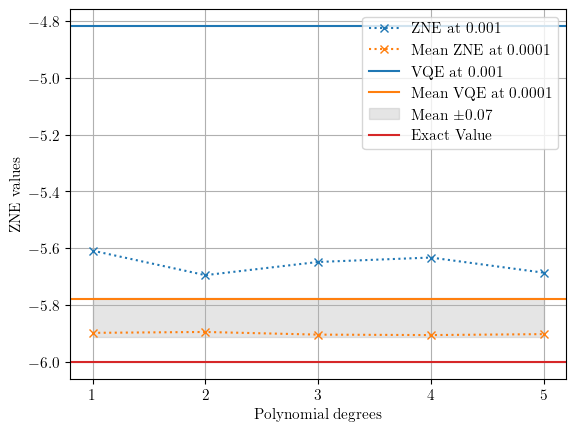

In [54]:
zne_Q7N1_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 4], degree = 1)
zne_Q7N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 10], degree = 2)
zne_Q7N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 20], degree = 3)
zne_Q7N1_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 35], degree = 4)
zne_Q7N1_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 56], degree = 5)

zne_Q7N1_vals = [
    zne_Q7N1_D1.getRichardsonZNE(),
    zne_Q7N1_D2.getRichardsonZNE(),
    zne_Q7N1_D3.getRichardsonZNE(),
    zne_Q7N1_D4.getRichardsonZNE(),
    zne_Q7N1_D5.getRichardsonZNE(),
]

zne_Q7N2_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2[ : 4], degree = 1)
zne_Q7N2_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2[ : 10], degree = 2)
zne_Q7N2_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2[ : 20], degree = 3)
zne_Q7N2_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2[ : 35], degree = 4)
zne_Q7N2_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2[ : 56], degree = 5)

zne_Q7N2_vals = [
    zne_Q7N2_D1.getRichardsonZNE(),
    zne_Q7N2_D2.getRichardsonZNE(),
    zne_Q7N2_D3.getRichardsonZNE(),
    zne_Q7N2_D4.getRichardsonZNE(),
    zne_Q7N2_D5.getRichardsonZNE(),
]

zne_Q7N2_second_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2_second[ : 4], degree = 1)
zne_Q7N2_second_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2_second[ : 10], degree = 2)
zne_Q7N2_second_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2_second[ : 20], degree = 3)
zne_Q7N2_second_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2_second[ : 35], degree = 4)
zne_Q7N2_second_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q7N2_second[ : 56], degree = 5)

zne_Q7N2_second_vals = [
    zne_Q7N2_second_D1.getRichardsonZNE(),
    zne_Q7N2_second_D2.getRichardsonZNE(),
    zne_Q7N2_second_D3.getRichardsonZNE(),
    zne_Q7N2_second_D4.getRichardsonZNE(),
    zne_Q7N2_second_D5.getRichardsonZNE(),
]

zne_Q7N2_vals_mean = [
    np.mean([zne_Q7N2_vals[0], zne_Q7N2_second_vals[0]]),
    np.mean([zne_Q7N2_vals[1], zne_Q7N2_second_vals[1]]),
    np.mean([zne_Q7N2_vals[2], zne_Q7N2_second_vals[2]]),
    np.mean([zne_Q7N2_vals[3], zne_Q7N2_second_vals[3]]),
    np.mean([zne_Q7N2_vals[4], zne_Q7N2_second_vals[4]])
]
zne_Q7N3_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q7N3[ : 4], degree = 1)
zne_Q7N3_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q7N3[ : 10], degree = 2)
zne_Q7N3_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q7N3[ : 20], degree = 3)
zne_Q7N3_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q7N3[ : 35], degree = 4)
zne_Q7N3_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q7N3[ : 56], degree = 5)

zne_Q7N3_vals = [
    zne_Q7N3_D1.getRichardsonZNE(),
    zne_Q7N3_D2.getRichardsonZNE(),
    zne_Q7N3_D3.getRichardsonZNE(),
    # zne_Q7N3_D4.getRichardsonZNE(),
    # zne_Q7N3_D5.getRichardsonZNE(),
]



# Y-axis labels
labels = ["1", "2", "3", "4", "5"]

# Colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.plot(labels, zne_Q7N1_vals, marker='x', linestyle='dotted', color = colors[0], label=f'ZNE at ${N1}$')
plt.plot(labels, zne_Q7N2_vals_mean, marker='x', linestyle='dotted', color = colors[1], label=f'Mean ZNE at ${N2}$')
#plt.plot(labels[ : 3], zne_Q7N3_vals, marker='x', linestyle='dotted', color = colors[2], label=f'ZNE at ${N3}$')

#plt.plot(labels, zne_Q7N2_second_vals, marker='x', linestyle='dotted', color = "blue", label=f'ZNE at ${N2}$')



plt.axhline(y = vqe_Q7N1, color = colors[0], linestyle='-', label=f'VQE at ${N1}$')
#plt.axhline(y = vqe_Q7N2, color = colors[1], linestyle='-', label=f'VQE at ${N2}$')
plt.axhline(y = vqe_Q7N2_mean, color = colors[1], linestyle='-', label=f'Mean VQE at ${N2}$')
#plt.axhline(y = vqe_Q7N3, color = colors[2], linestyle='-', label=f'VQE at ${N3}$')

plt.fill_between(labels, vqe_Q7_mean - vqe_Q7_std, vqe_Q7_mean + vqe_Q7_std, color='gray', alpha=0.2, label=f'Mean ±{vqe_Q7_std:.2f}')
plt.axhline(y = exact_Q7, color = colors[3], linestyle='-', label='Exact Value')

plt.xlabel('Polynomial degrees')
plt.ylabel('ZNE values')
#plt.title('8-qubit ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

---

In [157]:
zne_Q7N1_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1, degree = 1)
#zne_Q7N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 10], degree = 2)
#zne_Q7N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q7N1[ : 20], degree = 3)
print(zne_Q7N1_D1.get_monomials(3, 1))

def runZNE (data, degree, iter):

    zne_vals = []
    zne_instance = ZeroNoiseExtrapolation(dataPoints = data, degree = degree)
    M = len(zne_instance.get_monomials(3, degree))

    for _ in range(iter):
        while True:  # Keep trying until a valid sample is obtained
            try:
                random_sample = random.sample(data, M)
                sample = ZeroNoiseExtrapolation(dataPoints=random_sample, degree=degree).getRichardsonZNE()
                zne_vals.append(sample)
                break  # Exit the while loop if successful
            except ValueError:
                continue  # Retry if a ValueError occurs
    return np.mean(zne_vals)

runZNE(data_Q7N1, 1, 10)

['1', 'λ_3', 'λ_2', 'λ_1']


-4.852007214517829

In [13]:
"""
4-qubit system with 10 layers.
Exact sol: -3.0000000000000036
Noise prpbabilities: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized parameters without time constraint: [1.3627178221278613, 2.664542631979086, 0.7778304314389796, 5.08976011939805, 4.355201704522217, 5.524025790877457, 6.661083563496561, 6.734487955043819, 7.718699292684051, 8.640776739328741, 0.24227928169149046, 0.03502519151548362, -0.21602565927981202, 0.5794594972694906, -0.10427357485122196, -0.3452881050356924, 0.40205820972086187, -0.2008950032780847, 0.7298684934699999, -0.22946644587574697, 0.2894289098069959, 0.8093573474213096, 0.09500397802339218, 0.04863119825308582, -0.08482947373670244, 0.7782157014552835, 0.10629352646824314, 0.3859329126657005, -0.2812081405174874, -0.4933425127332805, -0.2657235464595865, -0.5360891458005344, -0.350989707586727, 0.25781763824022025, 0.5896775390789757, -0.23264039936319045, -0.10828982150182836, -0.6034661732301055, 0.29383021498500045, 0.2370023744147322, 0.08273028234283035, -0.4885993714831949, 0.10242915265700583, 0.49870256638484156, 0.12927638871301825, -0.19999588301270663, 0.046577695705521685, 0.46763976717087646, 0.14163349612554071, 0.04072755599252544]
"""

exact_Q4 = -3.0000000000000036
data_Q4N1 = [
    (4, 1, 0, -2.997479911971532),   # Noise factor [0, 0, 0]
    (12, 1, 0, -2.995225968234045), # Noise factor [1, 0, 0]
    (12, 3, 2, -2.991887065145745), # Noise factor [1, 1, 0]
    (12, 3, 6, -2.989617751848285), # Noise factor [1, 1, 1]
    (20, 1, 0, -2.9929737903621514), # Noise factor [2, 0, 0]
    (20, 3, 2, -2.989637441869657), # Noise factor [2, 1, 0]
    (20, 3, 6, -2.987369867285577), # Noise factor [2, 1, 1]
    (20, 5, 2, -2.9863048662238905), # Noise factor [2, 2, 0]
    (20, 5, 6, -2.981776597357825), # Noise factor [2, 2, 1]
    (20, 5, 10, -2.977255317475906), # Noise factor [2, 2, 2]
    (28, 1, 0, -2.9907233769261365), # Noise factor [3, 0, 0]
    (28, 3, 2, -2.987389580999148), # Noise factor [3, 1, 0]
    (28, 3, 6, -2.9851237437450724), # Noise factor [3, 1, 1]
    (28, 5, 2, -2.984059554984343), # Noise factor [3, 2, 0]
    (28, 5, 6, -2.9795347554177174), # Noise factor [3, 2, 1]
    (28, 5, 10, -2.975016939384755), # Noise factor [3, 2, 2]
    (28, 7, 2, -2.9807332945587603), # Noise factor [3, 3, 0]
    (28, 7, 6, -2.9739563914042693), # Noise factor [3, 3, 1]
    (28, 7, 10, -2.9671951717398657), # Noise factor [3, 3, 2]
    (28, 7, 14, -2.960449598632909), # Noise factor [3, 3, 3]
    (36, 1, 0, -2.9884747264974836), # Noise factor [4, 0, 0]
    (36, 3, 2, -2.9851434811073565), # Noise factor [4, 1, 0]
    (36, 3, 6, -2.9828793798010422), # Noise factor [4, 1, 1]
    (36, 5, 2, -2.9818160026972422), # Noise factor [4, 2, 0]
    (36, 5, 6, -2.9772946696698916), # Noise factor [4, 2, 1]
    (36, 5, 10, -2.9727803147301315), # Noise factor [4, 2, 2]
    (36, 7, 2, -2.9784922869475805), # Noise factor [4, 3, 0]
    (36, 7, 6, -2.9717205755804725), # Noise factor [4, 3, 1]
    (36, 7, 10, -2.964964535473117), # Noise factor [4, 3, 2]
    (36, 7, 14, -2.958224129722131), # Noise factor [4, 3, 3]
    (36, 9, 2, -2.97517232954384), # Noise factor [4, 4, 0]
    (36, 9, 6, -2.966157077049392), # Noise factor [4, 4, 1]
    (36, 9, 10, -2.9571696315356415), # Noise factor [4, 4, 2]
    (36, 9, 14, -2.948209905727264), # Noise factor [4, 4, 3]
    (36, 9, 18, -2.9392778126273704), # Noise factor [4, 4, 4]
    (44, 1, 0, -2.986227837648864), # Noise factor [5, 0, 0]
    (44, 3, 2, -2.9828991407686187), # Noise factor [5, 1, 0]
    (44, 3, 6, -2.9806367740289605), # Noise factor [5, 1, 1]
    (44, 5, 2, -2.9795742079385734), # Noise factor [5, 2, 0]
    (44, 5, 6, -2.9750563386926103), # Noise factor [5, 2, 1]
    (44, 5, 10, -2.970545442092549), # Noise factor [5, 2, 2]
    (44, 7, 2, -2.9762530348425793), # Noise factor [5, 3, 0]
    (44, 7, 6, -2.9694865111324895), # Noise factor [5, 3, 1]
    (44, 7, 10, -2.9627356464616725), # Noise factor [5, 3, 2]
    (44, 7, 14, -2.9560004039560117), # Noise factor [5, 3, 3]
    (44, 9, 2, -2.972935617169511), # Noise factor [5, 4, 0]
    (44, 9, 6, -2.963927270881401), # Noise factor [5, 4, 1]
    (44, 9, 10, -2.954946709890718), # Noise factor [5, 4, 2]
    (44, 9, 14, -2.945993846991313), # Noise factor [5, 4, 3]
    (44, 9, 18, -2.9370685952552416), # Noise factor [5, 4, 4]
    (44, 11, 2, -2.9696219506132424), # Noise factor [5, 5, 0]
    (44, 11, 6, -2.9583785975122114), # Noise factor [5, 5, 1]
    (44, 11, 10, -2.9471785757963316), # Noise factor [5, 5, 2]
    (44, 11, 14, -2.936021715534731), # Noise factor [5, 5, 3]
    (44, 11, 18, -2.924907847473882), # Noise factor [5, 5, 4]
    (44, 11, 22, -2.913836803034901), # Noise factor [5, 5, 5]
]

"""
8-qubit system with 25 layers.
Exact sol: -7.000000000000004
Noise prpbabilities: [0.000001, 0.000001, 0.000001, 0.000001]
Optimized parameters without time constraint: [-0.11621930083545058, 0.38858206488219377, 1.1401363613346718, 0.15691776700318727, 1.546881598765085, 0.890290426388797, 3.1473680591484534, 1.4865665122604388, 3.5980737939957903, 3.490386986693658, 4.459158757613067, 4.474581911159823, 5.526557537348905, 7.156861150526061, 7.129589736392912, 5.604014115310248, 6.40087796826047, 6.102825906426518, 9.150318300063333, 8.689693762370675, 9.512555270196078, 7.6807737889369285, 10.318152752114658, 7.707940654298934, 9.076437345089486, 0.15015584701784013, 0.171213941796565, 0.6321525098695228, 0.4356082703767327, -0.9559484726818184, -0.25403715265521826, 1.014819571216275, 0.585692045090965, -0.6336794561565412, 0.8469015131536111, 0.17015664985300782, -0.39818704499904234, -0.01853255928906247, -1.0892123043903041, 0.02129989299109363, -0.5347788445556598, -0.5219840839431251, -1.563329813142088, -0.03611129154654351, 2.0434928932225085, 1.3913955407369119, -1.73975205163484, -0.2182926919261577, -1.383106490990618, -1.8552981678787337, 1.5606484345264586, 0.894991140580873, -1.2656986371731642, -0.9170873335286825, -1.3651932855571112, 0.9809856660566901, -1.2789535400046137, 0.5791752737010758, -0.11679746652521207, 2.097027174294851, 0.11777882099345854, 0.20958343931666232, 0.392325670469179, -0.4810006661455803, -0.010916031697390255, -1.9677126998833427, 0.0726783552287941, 0.835805489085089, 0.24460362355536472, -0.23602963255965895, -0.10274002788291173, -0.9033284816841738, -0.06038731974839992, -0.6878368403966756, -0.03449710453395603, 0.4594575836264692, -0.13311735033700847, 0.3690665096625556, 0.057440425824771185, 0.44951014175622683, -0.024024953013579906, 0.5246056395019864, 0.025900909814809, 0.18519643482452605, -0.0836211046434901, -0.5318330659051429, 0.10904582088952688, 0.8436345345579523, 0.10695153846376013, -0.7447412947479908, 0.09220622831946497, 0.8417985467288559, 0.36508246504000824, -0.6427711897387511, -0.029769658384838006, -0.7071143146027736, 0.12921024603452624, 0.28154322053847464, 0.5462273499745153, -0.25076167086002105, -0.45204404936023906, -0.08627275936431165, 1.3840170884532297, -0.5636397223499671, 0.1345463971354046, -0.8597251271441068, 0.6608680377816024, 0.8003223082581614, 0.7227687459913715, -0.18959486825294392, 0.027851878187455575, -0.6066082478956557, -0.5946334763873184, -0.351964570224025, 1.5400435706491828, 2.163337009492652, 1.3528691262164785, -0.23304693519933797, -0.3617337036904291, -0.15521294180677425, -0.31211165269142654, 0.5267535875223974, -1.3394129323058872, 0.564262741051646, -1.708920268216747]
"""

data_Q8N1 = [
    (4, 1, 0, -6.478077187797685), # Noise factor [0, 0, 0]
    (12, 1, 0, -6.477264254041084), # Noise factor [1, 0, 0]
    (12, 3, 4, -6.474828226675374), # Noise factor [1, 1, 0]
    (12, 3, 12,  -6.473173027096575), # Noise factor [1, 1, 1]
    (20, 1, 0, -6.476451438301615), # Noise factor [2, 0, 0]
    (20, 3, 4, -6.474015734817444), # Noise factor [2, 1, 0]
    (20, 3, 12, -6.472360755907536), # Noise factor [2, 1, 1]
    (20, 5, 4, -6.471581012478415), # Noise factor [2, 2, 0]
    (20, 5, 12, -6.468272839605762), # Noise factor [2, 2, 1]
    (20, 5, 20, -6.464966476925081), # Noise factor [2, 2, 2]
    (28, 1, 0, -6.475638740560029), # Noise factor [3, 0, 0]
    (28, 3, 4, -6.47320336090768), # Noise factor [3, 1, 0]
    (28, 3, 12, -6.471548602632726), # Noise factor [3, 1, 1]
    (28, 5, 4, -6.470768962262247), # Noise factor [3, 2, 0]
    (28, 5, 12, -6.467461230407198), # Noise factor [3, 2, 1]
    (28, 5, 20, -6.464155308487725), # Noise factor [3, 2, 2]
    (28, 7, 4, -6.468335544204471), # Noise factor [3, 3, 0]
    (28, 7, 12, -6.463376621899072), # Noise factor [3, 3, 1]
    (28, 7, 20, -6.458421769034645), # Noise factor [3, 3, 2]
    (28, 7, 28, -6.453470982065912), # Noise factor [3, 3, 3]
    (36, 1, 0, -6.474826160797008), # Noise factor [4, 0, 0]
    (36, 3, 4, -6.472391104926802), # Noise factor [4, 1, 0]
    (36, 3, 12, -6.470736567252859), # Noise factor [4, 1, 1]
    (36, 5, 4, -6.469957029925314), # Noise factor [4, 2, 0]
    (36, 5, 12, -6.466649739020001), # Noise factor [4, 2, 1]
    (36, 5, 20, -6.463344257793987), # Noise factor [4, 2, 2]
    (36, 7, 4, -6.467523935373296), # Noise factor [4, 3, 0]
    (36, 7, 12, -6.46256567411438), # Noise factor [4, 3, 1]
    (36, 7, 20, -6.457611481720151), # Noise factor [4, 3, 2]
    (36, 7, 28, -6.452661354645807), # Nooise factor [4, 3, 3]
    (36, 9, 4, -6.465091820851759), # Noise factor [4, 4, 0]
    (36, 9, 12, -6.458484370553388), # Noise factor [4, 4, 1]
    (36, 9, 20, -6.45188414860969), # Noise factor [4, 4, 2]
    (36, 9, 28, -6.4452911466257365), # Noise factor [4, 4, 3]
    (36, 9, 36, -6.438705356216929), # Noise factor [4, 4, 4]
    (44, 1, 0, -6.474013698993294), # Noise factor [5, 0, 0]
    (44, 3, 4, -6.471578966855551), # Noise factor [5, 1, 0]
    (44, 3, 12, -6.469924649748712), # Noise factor [5, 1, 1]
    (44, 5, 4, -6.4691452154483216), # Noise factor [5, 2, 0]
    (44, 5, 12, -6.465838365424996), # Noise factor [5, 2, 1]
    (44, 5, 20, -6.462533324824644), # Noise factor [5, 2, 2]
    (44, 7, 4,  -6.46671244435243), # Noise factor [5, 3, 0]
    (44, 7, 12, -6.461754844038373), # Noise factor [5, 3, 1]
    (44, 7, 20, -6.456801312012761), # Noise factor [5, 3, 2]
    (44, 7, 28, -6.45185184473135), # Noise factor [5, 3, 3]
    (44, 9, 4, -6.46428065314897),  # Noise factor [5, 4, 0]
    (44, 9, 12, -6.457674083606563), # Noise factor [5, 4, 1]
    (44, 9, 20, -6.451074741395198), # Noise factor [5, 4, 2]
    (44, 9, 28, -6.444482618121226), # Noise factor [5, 4, 3]
    (44, 9, 36, -6.437897705401342), # Noise factor [5, 4, 4]
    (44, 11, 4, -6.461849841419121), # Noise factor [5, 5, 0]
    (44, 11, 12, -6.453596082148822), # Noise factor [5, 5, 1]
    (44, 11, 20, -6.445353607488786), # Noise factor [5, 5, 2]
    (44, 11, 28, -6.437122401060091), # Noise factor [5, 5, 3]
    (44, 11, 36, -6.428902446508737), # Noise factor [5, 5, 4]
    (44, 11, 44, -6.42069372750569), # Noise factor [5, 5, 5]
]

"""
8-qubit system with 25 layers.
Exact sol: -7.000000000000004
Noise prpbabilities: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized parameters without time constraint: [-1.598203452365122, -0.454626586570091, 1.4282421082448056, 0.015436042551439008, 0.9813223106420303, 0.6576478959055984, 3.8230724490399366, 1.6328198621735435, 3.930043867325021, 3.5749358773940294, 3.2741094538598423, 5.333661256371386, 5.228967410579761, 7.321512661931863, 7.28055210459519, 6.334421916248657, 6.291879649145826, 7.150978914105916, 7.179514788039292, 8.534289474738179, 8.978577286533756, 8.947180414801355, 10.823973087307959, 10.16734842539582, 10.241454235388934, -0.2098329604123184, -0.26055284411679486, 1.650927348803279, -2.352520908823862, -0.9250042151449581, 1.5036091726680993, 0.25525520683369235, -0.9930540188455652, 0.031299902058708334, -1.0690167417055687, -1.7183129459331394, 1.113306863722933, -0.31605496299853103, 1.4397004861923266, 0.34894963094763454, 1.51788110493564, -0.5227637946323876, 0.2176539602296948, -0.19773170079139468, 0.39922430899452205, 0.8721745477980981, -1.5445496607510734, -0.2427323307170025, -0.5465517938175843, -0.1971134226120807, 0.19283670511751194, 0.19085594130592307, 0.07697113231166389, 0.13257047530733815, 0.0071739577209740234, -0.38093094229796204, -0.3893121785092931, -1.7480001592761787, 0.26708448356490133, -0.2576947588923166, 0.09440798644437022, 1.285437556438038, 0.15058849991488407, -1.644790332627707, 0.3503329228225124, 0.7041004204937477, -0.0023955588893000007, 0.9076018225771513, -0.0715702121559551, 1.6868118774071919, 0.9216421038092796, 0.23318623363969845, -1.6946695515104755, -0.9662862558200821, 1.5668719975301024, 1.0735907673952012, 0.9333728199696584, -0.14498210992785804, 0.062124469949639466, 1.689908791267535, 0.39620580287656715, 1.7672380920245716, -0.013835905833801135, 1.0747063198116775, -0.0022877414464895626, 0.11942678144898249, -0.03436068030873114, 1.178277560292742, 2.2447135254332724, -0.6870279749304691, 1.6545494342336884, -0.3391957621360738, 0.10654407649226932, 0.0637381630811688, 0.014800671847975944, -0.07613542069227808, -0.11005787453742943, -1.898780864339826, -0.8483915811148912, -0.1441333431816059, 0.02530410691250804, -0.03664192113832491, -1.5811721011236184, -0.6280876641321144, -1.5981430039842626, -1.0604516965416935, -0.010566267564002299, -1.0910598693045526, -0.8146465543409181, 2.4249464186284735, -0.16203265445210321, -1.9327411011965903, 0.02005741064116468, 0.015489593446117115, -1.565862299569351, 1.5194446990160921, 1.4986478102931016, 0.6411139978837676, 0.03277197641916364, -0.37822107395511445, 0.3627171619734526, -0.28646017075972996, 2.4635153733716684, -0.8998933591618272, 0.0034769376819778295]
"""


data_Q8N2 = [
    (4, 1, 0, -6.586686232506038), # Noise factor [0, 0, 0]
    (12, 1, 0, -6.578928267594069), # Noise factor [1, 0, 0]
    (12, 3, 4, -6.555169918225676), # Noise factor [1, 1, 0]
    (12, 3, 12, -6.53907238285761), # Noise factor [1, 1, 1]
    (20, 1, 0, -6.571180283812833), # Noise factor [2, 0, 0]
    (20, 3, 4, -6.547451143813432), # Noise factor [2, 1, 0]
    (20, 3, 12, -6.53137342816183), # Noise factor [2, 1, 1]
    (20, 5, 4, -6.523812600595908), # Noise factor [2, 2, 0]
    (20, 5, 12, -6.491821400262652), # Noise factor [2, 2, 1]
    (20, 5, 20, -6.459996018753568), # Noiuse factor [2, 2, 2]
    (28, 1, 0,  -6.563442266892854), # Noise factor [3, 0, 0]
    (28, 3, 4, -6.539742296592507), # Noise factor [3, 1, 0]
    (28, 3, 12, -6.523684373685416), # Noise factor [3, 1, 1]
    (28, 5, 4, -6.5161328065139985), # Noise factor [3, 2, 0]
    (28, 5, 12, -6.484180979920743), # Noise factor [3, 2, 1]
    (28, 5, 20, -6.452394758126381), # Noise factor [3, 2, 2]
    (28, 7, 4, -6.492613433181837), # Noise factor [3, 3, 0]
    (28, 7, 12, -6.444930371640465), # Noise factor [3, 3, 1]
    (28, 7, 20, -6.397617411996776), # Noise factor [3, 3, 2]
    (28, 7, 28, -6.350671530645834), # Noise factor [3, 3, 3]
    (36, 1, 0, -6.555714202586656), # Noise factor [4, 0, 0]
    (36, 3, 4, -6.532043362374472), # Noise factor [4, 1, 0]
    (36, 3, 12, -6.516005205280183), # Noise factor [4, 1, 1]
    (36, 5, 4, -6.508462885989621), # Noise factor [4, 2, 0]
    (36, 5, 12, -6.476550379574356), # Noise factor [4, 2, 1]
    (36, 5, 20, -6.444803264237845), # Noise factor [4, 2, 2]
    (36, 7, 4,  -6.484972410444958), # Noise factor [4, 3, 0]
    (36, 7, 12, -6.437348013818665), # Noise factor [4, 3, 1]
    (36, 7, 20, -6.390093241603148), # Noise factor [4, 3, 2]
    (36, 7, 28, -6.343205074275518), # Noise factor [4, 3, 3]
    (36, 9, 4,  -6.461571574277893), # Noise factor [4, 4, 0]
    (36, 9, 12, -6.3983964084157945), # Noise factor [4, 4, 1]
    (36, 9, 20, -6.335873931931953), # Noise factor [4, 4, 2]
    (36, 9, 28, -6.2739970479778355), # Noise factor [4, 4, 3]
    (36, 9, 36, -6.212758740444894), # Noise factor [4, 4, 4]
    (44, 1, 0, -6.547996076668703), # Noise factor [5, 0, 0]
    (44, 3, 4, -6.524354326992758), # Noise factor [5, 1, 0]
    (44, 3, 12, -6.508335908819722), # Noise factor [5, 1, 1]
    (44, 5, 4, -6.50080282491491), # Noise factor [5, 2, 0]
    (44, 5, 12, -6.468929585195551), # Noise factor [5, 2, 1]
    (44, 5, 20, -6.4372215231393755), # Noise factor [5, 2, 2]
    (44, 7, 4, -6.477341207935643), # Noise factor [5, 3, 0]
    (44, 7, 12, -6.429775396450038), # Noise factor [5, 3, 1]
    (44, 7, 20, -6.382578732568697), # Noise factor [5, 3, 2]
    (44, 7, 28, -6.335748200844709), # Noise factor [5, 3, 3]
    (44, 9, 4, -6.453969115077857), # Noise factor [5, 4, 0]
    (44, 9, 12, -6.390871645273444), # Noise factor [5, 4, 1]
    (44, 9, 20, -6.3284260231514), # Noise factor [5, 4, 2]
    (44, 9, 28, -6.266625161439791), # Noise factor [5, 4, 3]
    (44, 9, 36, -6.205462053493209), # Noise factor [5, 4, 4]
    (44, 11, 4, -6.430686186880268), # Noise factor [5, 5, 0]
    (44, 11, 12, -6.352216646304327), # Noise factor [5, 5, 1]
    (44, 11, 20, -6.274758770413229), # Noise factor [5, 5, 2]
    (44, 11, 28, -6.198298833850601), # Noise factor [5, 5, 3]
    (44, 11, 36, -6.122823306083357), # Noise factor [5, 5, 4]
    (44, 11, 44, -6.048318848526524), # Noise factor [5, 5, 5]
    (52, 1, 0, -6.540287874935405), # Noise factor [6, 0, 0]
    (52, 3, 4, -6.516675176302654), # Noise factor [6, 1, 0]
    (52, 3, 12, -6.5006764701994175), # Noise factor [6, 1, 1]
    (52, 5, 4, -6.493152609203763), # Noise factor [6, 2, 0]
    (52, 5, 12, -6.461318582777916), # Noise factor [6, 2, 1]
    (52, 5, 20, -6.429649520903862), # Noise factor [6, 2, 2]
    (52, 7, 4, -6.4697198116261365), # Noise factor [6, 3, 0]
    (52, 7, 12, -6.422212505625761), # Noise factor [6, 3, 1]
    (52, 7, 20, -6.375073871102446), # Noise factor [6, 3, 2]
    (52, 7, 28, -6.328300896679264), # Noise factor [6, 3, 3]
    (52, 9, 4, -6.446376423077483), # Noise factor [6, 4, 0]
    (52, 9, 12, -6.383356543717345), # Noise factor [6, 4, 1]
    (52, 9, 20, -6.320987671542587), # Noise factor [6, 4, 2]
    (52, 9, 28, -6.259262728843716), # Noise factor [6, 4, 3]
    (52, 9, 36, -6.198174718424359), # Noise factor [6, 4 ,4]
    (52, 11, 4, -6.423122084579152), # Noise factor [6, 5, 0]
    (52, 11, 12, -6.344749013958648), # Noise factor [6, 5, 1]
    (52, 11, 20, -6.267386303974981), # Noise factor [6, 5, 2]
    (52, 11, 28, -6.191020247784184), # Noise factor [6, 5, 3]
    (52, 11, 36, -6.115637333091775), # Noise factor [6, 5, 4]
    (52, 11, 44, -6.041224239281902), # Noise factor [6, 5, 5]
    (52, 13, 4, -6.399956438659582), # Noise factor [6, 6, 0]
    (52, 13, 12, -6.306388245099945), # Noise factor [6, 6, 1]
    (52, 13, 20, -6.214265195723871), # Noise factor [6, 6, 2]
    (52, 13, 28, -6.123563805095008), # Noise factor [6, 6, 3]
    (52, 13, 36, -6.0342609870613195), # Noise factor [6, 6, 4]
    (52, 13, 44, -5.946334047697964),   # Noise factor [6, 6, 5]
    (52, 13, 52, -5.85976067837905), # Noise factor [6, 6, 6]
]

"""
8-qubit system with 25 layers.
Exact sol: -7.000000000000004
Noise prpbabilities: [0.0001, 0.0001, 0.0001, 0.0001]
Optimized parameters without time constraint: [-0.2949983979349534, 0.5914680002176885, 2.000569656433367, -0.6679579016969435, 1.211677891050099, -0.5634540499188538, 0.9720779206476076, -0.20820884417179195, 0.270360052758564, 2.173127940213202, 2.2995158211776587, 2.058034552095651, 5.335729801000788, 5.1476020743469135, 5.187806905276244, 5.960375772250169, 6.6431264229580504, 6.408136061897341, 7.042446936672068, 6.704392963402571, 8.173246507033609, 7.684840221515026, 8.723529324224854, 8.59492373208671, 10.162483298678772, 0.6054037709148496, -0.06265195440063241, 0.7107290747462329, -0.1327256874339623, 0.0016829416523280087, 0.06626770684187697, 0.03389256940537287, 1.8731192870939402, 0.6542946029060017, -0.5244634654810443, -0.4832788881487693, 1.2964284023296389, -1.2079049353507807, 0.15564844151591, -0.9149610284822987, 0.04638538209156977, -1.4038678639035302, 2.056654651324246, 1.1214704998735656, -0.08037436461421035, -1.5629160704521723, 0.6822074249407261, 0.19658190034768178, -0.6265415504501582, -1.0888222288914549, 1.355397986537009, 2.3899184832197102, 0.11443311348004707, -0.6495162649423466, -0.9527765724527216, -1.7268302952452776, -1.3784173949860545, -0.15636997640064515, -2.4852806498420517, -0.8907211555213004, 1.287115435748947, -0.15278499758805555, 0.4580127812885194, 1.1679586577449272, 1.8703099321190941, 0.1465556817259204, -0.01905488792778002, 0.21241552576924755, 0.3808915823263346, 0.5680946038914583, -1.0267405214155478, 0.944315213214638, -1.051348509758773, 0.609225253184139, -1.7253155824670934, -2.7232948062045157, -0.776094508781908, -0.059511467331091875, -1.9648935981931472, -2.322260400614705, -0.03681726157907257, -0.8004190181010998, -0.5956668596150025, -0.3161746990070314, -1.473997786407141, -0.05270089102501769, 1.106383934359835, 0.3041291749478202, 1.0368574690555095, -0.32302529763020016, -0.05085073772156988, -1.1638592507058652, -0.35991945564001276, 0.30857976930683856, -0.4185550235383592, -0.61480828524873, -0.14333534460721375, 0.21407554138496093, -1.716751796752607, -1.0372306249975016, -1.342858074526235, -0.6158949035420768, 1.5868371353390225, 0.6462597755576415, 1.431199324495095, 0.30955349012697586, 1.4294923912099151, 0.7045340631430905, -1.6039503314342918, -1.3523681654969013, 1.5349128097577087, 2.180865883846592, 1.4481839113407342, -0.8507503856557468, 0.20257589183066116, 0.21329463249304512, -1.0667887036088275, 1.0626698212777295, -1.3695622348698768, -1.3707074095249312, -0.18496516082374764, -0.6021955293464927, 1.5648017671473102, 2.5120232314361592, 1.561617286829982]
"""

data_Q8N3 = [
    (4, 1, 0, -6.461914731281114), # Noise factor [0, 0, 0]
    (12, 1, 0, -6.392663785991663), # Noise factor [1, 0, 0]
    (12, 3, 4, -6.176500156830398), # Noise factor [1, 1, 0]
    (12, 3, 12, -6.034240702642021), # Noise factor [1, 1, 1]
    (20, 1, 0, -6.324257134432468), # Noise factor [2, 0, 0]
    (20, 3, 4, -6.110508328460179), # Noise factor [2, 1, 0]
    (20, 3, 12, -5.9698418000379885), # Noise factor [2, 1, 1]
    (20, 5, 4, -5.904358620526751), # Noise factor [2, 2, 0]
    (20, 5, 12, -5.636308668463816), # Noise factor [2, 2, 1]
    (20, 5, 20, -5.381085344843059), # Noise factor [2, 2, 2]
    (28, 1, 0, -6.256682918686416), # Noise factor [3, 0, 0]
    (28, 3, 4, -6.045317754199246), # Noise factor [3, 1, 0]
    (28, 3, 12, -5.906223524725548), # Noise factor [3, 1, 1]
    (28, 5, 4, -5.841462746193638), # Noise factor [3, 2, 0]
    (28, 5, 12, -5.576401440144248), # Noise factor [3, 2, 1]
    (28, 5, 20, -5.3240161049924755), # Noise factor [3, 2, 2]
    (28, 7, 4, -5.644837965333655), # Noise factor [3, 3, 0]
    (28, 7, 12, -5.26594245295222), # Noise factor [3, 3, 1]
    (28, 7, 20, -4.913817419418874), # Noise factor [3, 3, 2]
    (28, 7, 28, -4.586477365581319), # Noise factor [3, 3, 3]
    (36, 1, 0, -6.189929464626196), # Noise factor [4, 0, 0]
    (36, 3, 4, -5.980917216973188), # Noise factor [4, 1, 0]
    (36, 3, 12, -5.84337496277496), # Noise factor [4, 1, 1]
    (36, 5, 4, -5.779327390691429), # Noise factor [4, 2, 0]
    (36, 5, 12, -5.517216205363935), # Noise factor [4, 2, 1]
    (36, 5, 20, -5.2676323845879125), # Noise factor [4, 2, 2]
    (36, 7, 4, -5.584883491980448), # Noise factor [4, 3, 0]
    (36, 7, 12, -5.210194663274012), # Noise factor [4, 3, 1]
    (36, 7, 20, -4.861963519762956), # Noise factor [4, 3, 2]
    (36, 7, 28, -4.5382290019275136), # Noise factor [4, 3, 3]
    (36, 9, 4, -5.397319791693299), # Noise factor [4, 4, 0]
    (36, 9, 12, -4.921132922608734), # Noise factor [4, 4, 1]
    (36, 9, 20, -4.4891104160821875), # Noise factor [4, 4, 2]
    (36, 9, 28, -4.096957389951194), # Noise factor [4, 4, 3]
    (36, 9, 36, -3.7408152152054877), # Noise factor [4, 4, 4]
    (44, 1, 0, -6.123985278862469), # Noise factor [5, 0, 0]
    (44, 3, 4, -5.917295673146872), # Noise factor [5, 1, 0]
    (44, 3, 12, -5.781285368842865), # Noise factor [5, 1, 1]
    (44, 5, 4, -5.7179419418228585), # Noise factor [5, 2, 0]
    (44, 5, 12, -5.458742916204181), # Noise factor [5, 2, 1]
    (44, 5, 20, -5.211924668741973), # Noise factor [5, 2, 2]
    (44, 7, 4, -5.525650978012277), # Noise factor [5, 3, 0]
    (44, 7, 12, -5.155114852231662), # Noise factor [5, 3, 1]
    (44, 7, 20, -4.810727856544264), # Noise factor [5, 3, 2]
    (44, 7, 28, -4.4905530242742735), # Noise factor [5, 3, 3]
    (44, 9, 4, -5.340160301191931), # Noise factor [5, 4, 0]
    (44, 9, 12, -4.8692381777766895), # Noise factor [5, 4, 1]
    (44, 9, 20, -4.441967071251144), # Noise factor [5, 4, 2]
    (44, 9, 28, -4.054104653242093), # Noise factor [5, 4, 3]
    (44, 9, 36, -3.701839241059654), # Noise factor [5, 4, 4]
    (44, 11, 4, -5.161217626812692), # Noise factor [5, 5, 0]
    (44, 11, 12, -4.600024598797987), # Noise factor [5, 5, 1]
    (44, 11, 20, -4.1028942365414), # Noise factor [5, 5, 2]
    (44, 11, 28, -3.6621670805225226), # Noise factor [5, 5, 3]
    (44, 11, 36, -3.271139325223284), # Noise factor [5, 5, 4]
    (44, 11, 44, -2.92393891886106), # Noise factor [5, 5, 5]
]

"""
8-qubit system with 25 layers.
Exact sol: -7.000000000000004
Noise prpbabilities: [0.001, 0.001, 0.001, 0.001]
Optimized parameters without time constraint:   [1.5432885922501491, -1.466580677758053, -0.6994569811552129, -1.0037891724783143, 3.194421049398902, 2.605549509179758, 2.8350571800291267, 5.676849424060013, 2.4818208876257972, 5.601254244969108, 3.3335207127183257, 5.140078813551924, 3.8190023449658734, 4.679428118067688, 8.595151663924502, 8.753196146288872, 9.557815608372719, 8.556565544122268, 9.609188854949892, 8.697055673300781, 8.953238254736485, 8.696681790213626, 9.207259824260786, 9.534479271433257, 9.639288363534964, -0.03714112469514068, 0.7897778792939742, 0.9397687825961443, -2.2392573080173337, -0.489022453428865, 1.986964720903291, 0.39146574728655803, -1.558970415143717, -1.0590241958696294, 0.025010188103458623, 0.18204968833930585, -0.5181671762958535, -1.0669669011425498, 1.5456108903254429, -2.0575906158252053, 0.08949436420717558, 1.0408534695235498, 0.08692807654136674, 1.637870378415018, -0.4591515956906456, 0.8638909247945071, -0.980052262038883, 0.21797117789101741, -0.12618542767305574, 1.3344168345042564, -0.24094488244739817, -1.7266810229326481, 1.024482376901299, -0.13358052590326586, 0.008765637447572397, 2.36598339998239, -0.6126985814953947, -1.1928243274592434, 0.18554311313981015, -0.2221171113656634, -0.23572804915700646, 0.1065739984589871, 0.2305622977716097, 0.7650442614634569, -0.1903523310176815, 0.028205912414168848, -0.7459957066539721, 0.2358630617881588, -1.129840663434053, -1.1199874993304244, -0.2018505600710459, -1.7716572941624527, -0.15189832973891484, 2.1758874887624815, -0.1746233970267953, -1.023318653694795, 0.8174780171837576, -1.6578496517208725, 0.28045604640213584, -0.9887381493415912, -0.4550635959721123, 0.5259514993788909, 2.6941100341157145, -0.20360808037592412, -0.8544734437590813, -2.5671117854199808, -1.497329172277945, -0.015139412829652726, 0.08334459294552965, 0.8400500181834483, 1.2159651832669738, 1.2468382199665855, -1.0061869069117166, 0.9168778744191447, -1.0712897847482086, -0.1782349024565091, -0.7753520940334098, 1.0402956462110153, -1.1715036016265457, -1.5214866172076889, -1.274684161484158, -0.7955368924234714, 0.821401322499548, 1.7326615689353286, 1.1842349270415338, 2.22464767969342, -0.6759460307858057, 0.5028955242405839, -0.9842551657400853, 0.3324160902431336, -0.5265951514395798, 0.5126407780730275, -0.5047089664819252, 0.02407369186289517, 0.9612902435222449, -0.17840687520790435, 0.05064539436954246, 0.6112940962779007, 0.48008576698121685, 0.17338875479445354, 2.0289607549577533, -1.2673353902499307, 1.0645488999781407, 1.3824232103470868, -1.0335170345392999]
"""

data_Q8N4 = [
    (4, 1, 0, -5.336858390703519), # Noise factor [0, 0, 0]
    (12, 1, 0, -4.846628971866363), # Noise factor [1, 0, 0]
    (12, 3, 4, -3.5056835431348023), # Noise factor [1, 1, 0]
    (12, 3, 12, -2.826564166177607), # Noise factor [1, 1, 1]
    (20, 1, 0, -4.408986909848514), # Noise factor [2, 0, 0]
    (20, 3, 4, -3.1955022907211372), # Noise factor [2, 1, 0]
    (20, 3, 12, -2.5794391519493804), # Noise factor [2, 1, 1]
    (20, 5, 4, -2.3347776390633292), # Noise factor [2, 2, 0]
    (20, 5, 12, -1.5410619398684988), # Noise factor [2, 2, 1]
    (20, 5, 20, -1.0287234447164808), # Noise factor [2, 2, 2]
    (28, 1, 0, -4.017435413130045), # Noise factor [3, 0, 0]
    (28, 3, 4, -2.9170256303423536), # Noise factor [3, 1, 0]
    (28, 3, 12, -2.3570969778681197), # Noise factor [3, 1, 1]
    (28, 5, 4, -2.134344220177717), # Noise factor [3, 2, 0]
    (28, 5, 12, -1.410798276182413), # Noise factor [3, 2, 1]
    (28, 5, 20, -0.9426179414641492), # Noise factor [3, 2, 2]
    (28, 7, 4, -1.572346746103763), # Noise factor [3, 3, 0]
    (28, 7, 12, -0.8583774221277659), # Noise factor [3, 3, 1]
    (28, 7, 20, -0.47822210989654357), # Noise factor [3, 3, 2]
    (28, 7, 28, -0.27095063293475297), # Noise factor [3, 3, 3]
    (36, 1, 0, -3.666371263535374), # Noise factor [4, 0, 0]
    (36, 3, 4, -2.6665186698229966), # Noise factor [4, 1, 0]
    (36, 3, 12, -2.156677925951955), # Noise factor [4, 1, 1]
    (36, 5, 4, -1.9535277323656657),  # Noise factor [4, 2, 0]
    (36, 5, 12, -1.2928918715401707), # Noise factor [4, 2, 1]
    (36, 5, 20, -0.8644715026916918), # Noise factor [4, 2, 2]
    (36, 7, 4, -1.4404877674960321), # Noise factor [4, 3, 0]
    (36, 7, 12, -0.7872753531418845), # Noise factor [4, 3, 1]
    (36, 7, 20, -0.43870035430147786), # Noise factor [4, 3, 2]
    (36, 7, 28, -0.2484396110849602), # Noise factor [4, 3, 3]
    (36, 9, 4, -1.0683583686587776), # Noise factor [4, 4, 0]
    (36, 9, 12, -0.4857479766581645), # Noise factor [4, 4, 1]
    (36, 9, 20, -0.22752742323863356), # Noise factor [4, 4, 2]
    (36, 9, 28, -0.10921371504426297), # Noise factor [4, 4, 3]
    (36, 9, 36, -0.05355481142927614), # Noise factor [4, 4, 4]
    (44, 1, 0, -3.3509511570134447), # Noise factor [5, 0, 0]
    (44, 3, 4, -2.4407374451931263), # Noise factor [5, 1, 0]
    (44, 3, 12, -1.9756902056960328), # Noise factor [5, 1, 1]
    (44, 5, 4, -1.790117038157763), # Noise factor [5, 2, 0]
    (44, 5, 12, -1.1859984742676424), # Noise factor [5, 2, 1]
    (44, 5, 20, -0.7934441790135535), # Noise factor [5, 2, 2]
    (44, 7, 4, -1.321046514066111), # Noise factor [5, 3, 0]
    (44, 7, 12, -0.7226218661679531), # Noise factor [5, 3, 1]
    (44, 7, 20, -0.4026634895981363), # Noise factor [5, 3, 2]
    (44, 7, 28, -0.22787198901183386), # Noise factor [5, 3, 3]
    (44, 9, 4, -0.9802839798886374), # Noise factor [5, 4, 0]
    (44, 9, 12, -0.44586239680266304), # Noise factor [5, 4, 1]
    (44, 9, 20, -0.20865404259619563), # Noise factor [5, 4, 2]
    (44, 9, 28, -0.09997246792693198), # Noise factor [5, 4, 3]
    (44, 9, 36, -0.048902370606577705), # Noise factor [5, 4, 4]
    (44, 11, 4, -0.7310539458127763), # Noise factor [5, 5, 0]
    (44, 11, 12, -0.2781164120909525), # Noise factor [5, 5, 1]
    (44, 11, 20, -0.11007230178516257), # Noise factor [5, 5, 2]
    (44, 11, 28, -0.0450243439945618), # Noise factor [5, 5, 3]
    (44, 11, 36, -0.018976970671925403), # Noise factor [5, 5, 4]
    (44, 11, 44, -0.008235210169743903)
]

In [33]:
# Exact expectation value for a 8-qubit system
exact_Q8 = -7.000000000000004
noiseless_Q8 = [-6.422209729993648, -6.834876570997968, -6.692056459800095, -6.656141670890971, -6.2937260012199765, -6.746647347749851, -6.374275141226224, -6.234478523482034, -6.618194894561211, -6.368075653352083]
noiseless_Q8_mean = np.mean(noiseless_Q8)
vqe_Q8N1_val = data_Q8N1[0][-1]
vqe_Q8N2_val = data_Q8N2[0][-1]
vqe_Q8N3_val = data_Q8N3[0][-1]
vqe_Q8N4_val = data_Q8N4[0][-1]


### D. Result: Error mitigation

#### Multivariate 

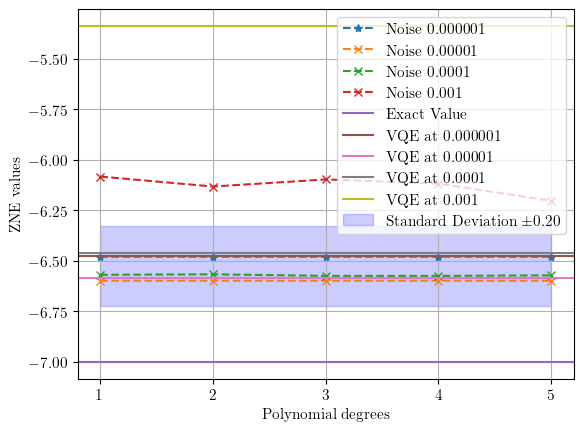

In [38]:
zne_Q8N1_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 4], degree = 1)
zne_Q8N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 10], degree = 2)
zne_Q8N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 20], degree = 3)
zne_Q8N1_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 35], degree = 4)
zne_Q8N1_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 56], degree = 5)

zne_Q8N1_vals = [
    zne_Q8N1_D1.getRichardsonZNE(),
    zne_Q8N1_D2.getRichardsonZNE(),
    zne_Q8N1_D3.getRichardsonZNE(),
    zne_Q8N1_D4.getRichardsonZNE(),
    zne_Q8N1_D5.getRichardsonZNE(),
]

zne_Q8N2_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q8N2[ : 4], degree = 1)
zne_Q8N2_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N2[ : 10], degree = 2)
zne_Q8N2_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N2[ : 20], degree = 3)
zne_Q8N2_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q8N2[ : 35], degree = 4)
zne_Q8N2_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N2[ : 56], degree = 5)

zne_Q8N2_vals = [
    zne_Q8N2_D1.getRichardsonZNE(),
    zne_Q8N2_D2.getRichardsonZNE(),
    zne_Q8N2_D3.getRichardsonZNE(),
    zne_Q8N2_D4.getRichardsonZNE(),
    zne_Q8N2_D5.getRichardsonZNE(),
]

zne_Q8N3_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q8N3[ : 4], degree = 1)
zne_Q8N3_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N3[ : 10], degree = 2)
zne_Q8N3_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N3[ : 20], degree = 3)
zne_Q8N3_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q8N3[ : 35], degree = 4)
zne_Q8N3_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N3[ : 56], degree = 5)

zne_Q8N3_vals = [
    zne_Q8N3_D1.getRichardsonZNE(),
    zne_Q8N3_D2.getRichardsonZNE(),
    zne_Q8N3_D3.getRichardsonZNE(),
    zne_Q8N3_D4.getRichardsonZNE(),
    zne_Q8N3_D5.getRichardsonZNE(),
]

zne_Q8N4_D1 = ZeroNoiseExtrapolation(dataPoints = data_Q8N4[ : 4], degree = 1)
zne_Q8N4_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N4[ : 10], degree = 2)
zne_Q8N4_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N4[ : 20], degree = 3)
zne_Q8N4_D4 = ZeroNoiseExtrapolation(dataPoints = data_Q8N4[ : 35], degree = 4)
zne_Q8N4_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N4[ : 56], degree = 5)

zne_Q8N4_vals = [
    zne_Q8N4_D1.getRichardsonZNE(),
    zne_Q8N4_D2.getRichardsonZNE(),
    zne_Q8N4_D3.getRichardsonZNE(),
    zne_Q8N4_D4.getRichardsonZNE(),
    zne_Q8N4_D5.getRichardsonZNE(),
]

# Stadard deviation for the noiseless system
std_dev = np.std(noiseless_Q8)

# Y-axis labels
labels = ["1", "2", "3", "4", "5"]

# Colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.plot(labels, zne_Q8N1_vals, marker='*', linestyle='--', color = colors[0], label='Noise $0.000001$')
plt.plot(labels, zne_Q8N2_vals, marker='x', linestyle='--', color = colors[1], label='Noise $0.00001$')
plt.plot(labels, zne_Q8N3_vals, marker='x', linestyle='--', color = colors[2], label='Noise $0.0001$')
plt.plot(labels, zne_Q8N4_vals, marker='x', linestyle='--', color = colors[3], label='Noise $0.001$')

plt.axhline(y = exact_Q8, color = colors[4], linestyle='-', label='Exact Value')
plt.axhline(y = vqe_Q8N1_val, color = colors[5], linestyle='-', label='VQE at $0.000001$')
plt.axhline(y = vqe_Q8N2_val, color = colors[6], linestyle='-', label='VQE at $0.00001$')
plt.axhline(y = vqe_Q8N3_val, color = colors[7], linestyle='-', label='VQE at $0.0001$')
plt.axhline(y = vqe_Q8N4_val, color = colors[8], linestyle='-', label='VQE at $0.001$')

plt.fill_between(labels, noiseless_Q8_mean - std_dev, noiseless_Q8_mean + std_dev, color='blue', alpha=0.2, label=f'Standard Deviation ±{std_dev:.2f}')
plt.xlabel('Polynomial degrees')
plt.ylabel('ZNE values')
#plt.title('8-qubit ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


In [24]:
print(std_dev)

0.19867891295541915


Zne: -3.000351381611832
Zne: -2.999664593187207
Zne: -2.9997401199320373
Zne: -2.999711349589023
Zne: -2.99971119308471


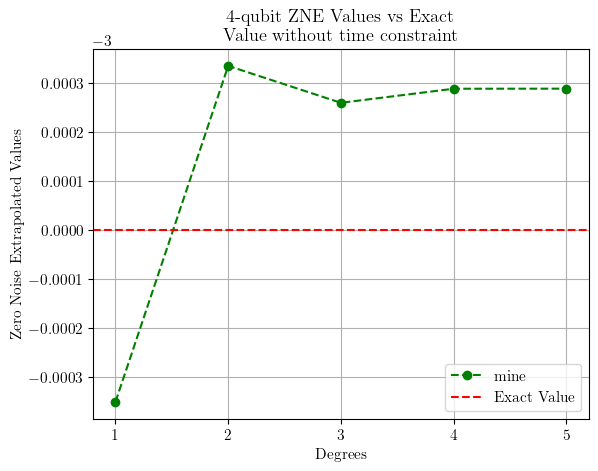

In [67]:
zne_Q4N1_D1 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1, 4), degree = 1)
zne_Q4N1_D2 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1, 10), degree = 2)
zne_Q4N1_D3 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1, 20), degree = 3)
zne_Q4N1_D4 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1, 35), degree = 4)
zne_Q4N1_D5 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1, 56), degree = 5)

zne_Q4N1_vals = [
    zne_Q4N1_D1.getRichardsonZNE(),
    zne_Q4N1_D2.getRichardsonZNE(),
    zne_Q4N1_D3.getRichardsonZNE(),
    zne_Q4N1_D4.getRichardsonZNE(),
    zne_Q4N1_D5.getRichardsonZNE(),
]

for E in zne_Q4N1_vals:
    print(f"Zne: {E}")

# zne_Q4N1_vals_default = [
#     zne_Q4N1_D1.getRichardsonZNE2(),
#     zne_Q4N1_D2.getRichardsonZNE2(),
#     zne_Q4N1_D3.getRichardsonZNE2(),
#     zne_Q4N1_D4.getRichardsonZNE2(),
#     zne_Q4N1_D5.getRichardsonZNE2(),
# ]

# for E in zne_Q4N1_vals_default:
#     print(f"Default E: {E}")

labels = ["1", "2", "3", "4", "5"]

plt.plot(labels, zne_Q4N1_vals, marker='o', linestyle='--', color='green', label='mine')
#plt.plot(labels, zne_Q4N1_vals_default, marker='o', linestyle='--', color='blue', label='default')
plt.axhline(y = exact_Q4, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Degrees')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('4-qubit ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()


#### Single variate

The following functions maps vector noise paramer into a scaler parameter.

In [42]:
def get_single_noise_val(nqubits: int, noise_param: List[Tuple[int, int, int, float]]) -> List[Tuple[int, int, int, float]]:
    """
    Generate a single noise value for extrapolation.
    """
    result = []
    for nR, nT, nY, E in noise_param:
        noise_level = nR + (nqubits*nT) + (nY*2) + 2
        result.append((noise_level, E))
    return result

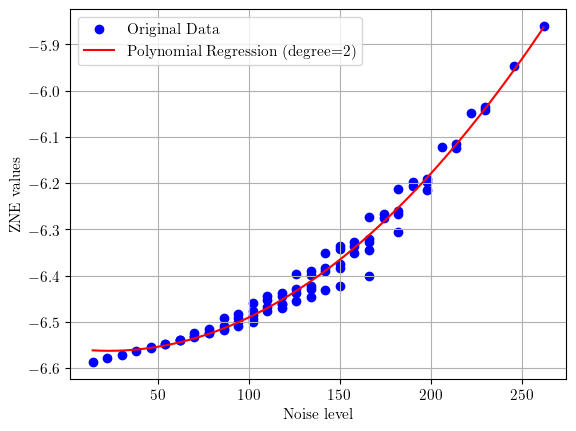

Coefficients: [[ 0.00000000e+00 -5.66687299e-04  1.22569381e-05]]
Intercept: [-6.55622277]


In [49]:
# Example data
data = get_single_noise_val(nqubits=8, noise_param=data_Q8N1)

def ZeroLimitExtrapolation(degree: int, data: List[Tuple[int, float]]) -> None:
    x = np.array([point[0] for point in data]).reshape(-1, 1)
    y = np.array([point[1] for point in data]).reshape(-1, 1)  # Reshape x here

    # Transform the features to polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x)

    # Fit the polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y)

    # Predict using the polynomial model
    x_range = np.linspace(min(x), max(x), 500).reshape(-1, 1)  # For smooth curve
    x_poly_range = poly_features.transform(x_range)
    y_poly_pred = model.predict(x_poly_range)

    # Visualize the results
    plt.scatter(x, y, color='blue', label='Original Data')
    plt.plot(x_range, y_poly_pred, color='red', label=f'Polynomial Regression (degree={degree})')
    plt.xlabel('Noise level')
    plt.ylabel('ZNE values')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print model coefficients
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)

# Example usage:
ZeroLimitExtrapolation(2, data)


Zne val: -6.619857877546533
Zne val: -6.434670363564734
Zne val: -7.602132170111204
Zne val: -0.5400947899355542
Zne val: 116.97209374866361


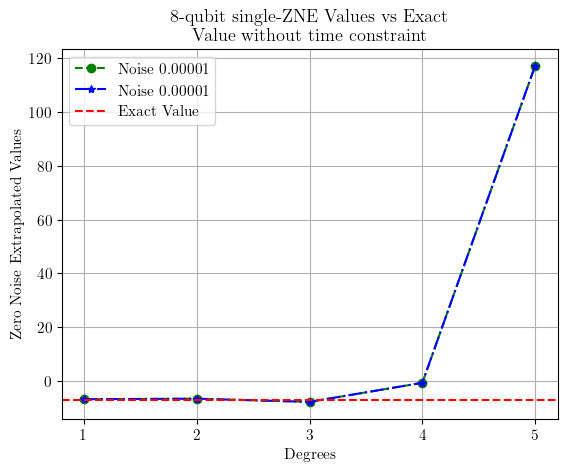

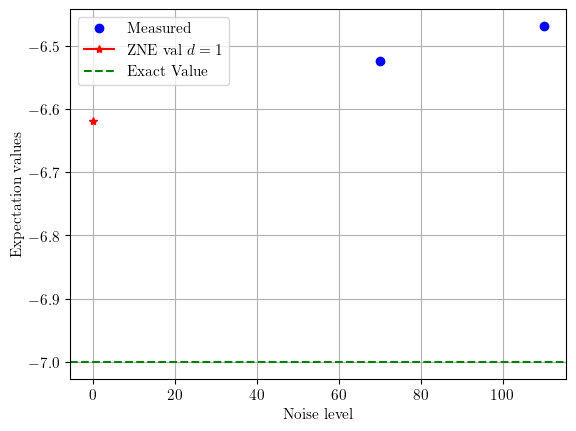

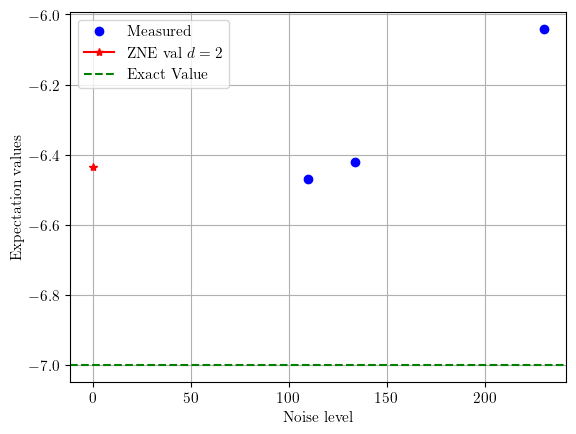

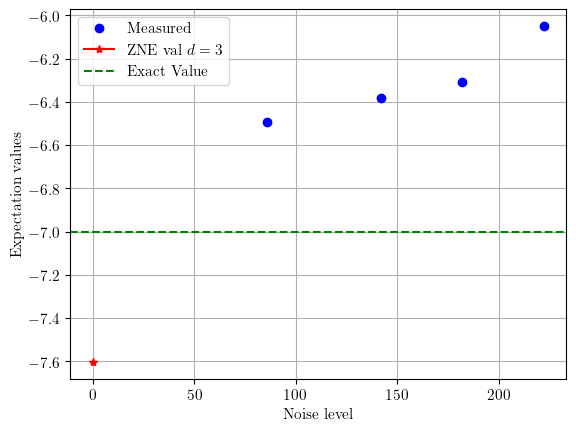

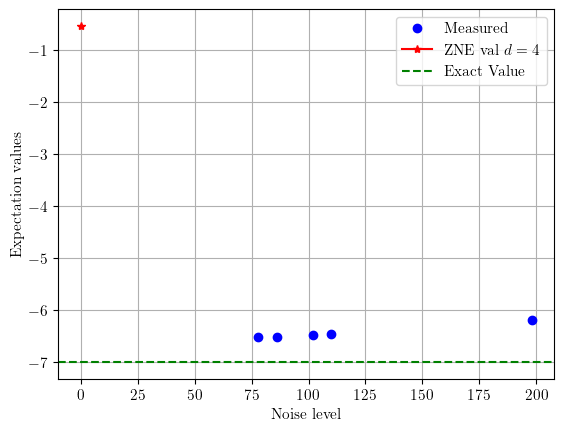

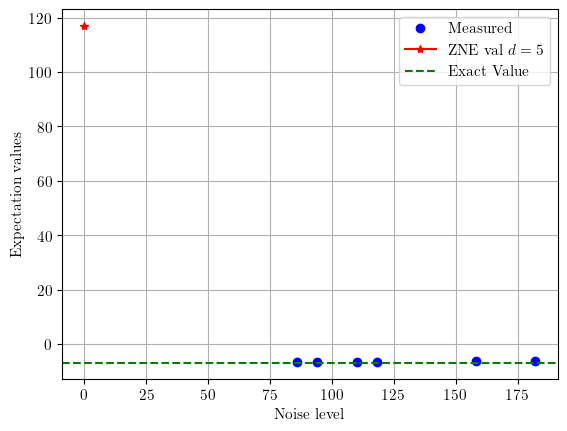

In [64]:
data_Q8N1_single = get_single_noise_val(nqubits = 8, noise_param = data_Q8N1)

# Random samppling
zne_Q8N1_D1_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 2), degree = 1)
zne_Q8N1_D2_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 3), degree = 2)
zne_Q8N1_D3_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 4), degree = 3)
zne_Q8N1_D4_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 5), degree = 4)
zne_Q8N1_D5_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 6), degree = 5)

zne_Q8N1_single_vals = [
    zne_Q8N1_D1_single.getRichardsonZNE(),
    zne_Q8N1_D2_single.getRichardsonZNE(),
    zne_Q8N1_D3_single.getRichardsonZNE(),
    zne_Q8N1_D4_single.getRichardsonZNE(),
    zne_Q8N1_D5_single.getRichardsonZNE(),
]

zne_Q8N1_single_vals_default = [
    zne_Q8N1_D1_single.getRichardsonSingleZNE(),
    zne_Q8N1_D2_single.getRichardsonSingleZNE(),
    zne_Q8N1_D3_single.getRichardsonSingleZNE(),
    zne_Q8N1_D4_single.getRichardsonSingleZNE(),
    zne_Q8N1_D5_single.getRichardsonSingleZNE(),
]

for E in zne_Q8N1_single_vals:
    print(f"Zne val: {E}")

labels = ["1", "2", "3", "4", "5"]
plt.figure(1)
plt.plot(labels, zne_Q8N1_single_vals, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.plot(labels, zne_Q8N1_single_vals_default, marker='*', linestyle='-.', color='blue', label='Noise 0.00001')
plt.axhline(y = exact_Q8, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Degrees')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('8-qubit single-ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

#####################Expectation values vs noise level#####################
plt.figure(2)
plt.plot(zne_Q8N1_D1_single.get_noise_levels(), zne_Q8N1_D1_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N1_D1_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=1$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(3)
plt.plot(zne_Q8N1_D2_single.get_noise_levels(), zne_Q8N1_D2_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N1_D2_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=2$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(4)
plt.plot(zne_Q8N1_D3_single.get_noise_levels(), zne_Q8N1_D3_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N1_D3_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=3$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(5)
plt.plot(zne_Q8N1_D4_single.get_noise_levels(), zne_Q8N1_D4_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N1_D4_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=4$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(6)
plt.plot(zne_Q8N1_D5_single.get_noise_levels(), zne_Q8N1_D5_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N1_D5_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=5$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)


Zne val: -7.729491233663627
Zne val: -6.122858254251682
Zne val: -7.353301757659356
Zne val: 4.6945609248311655
Zne val: 49.95581726125141


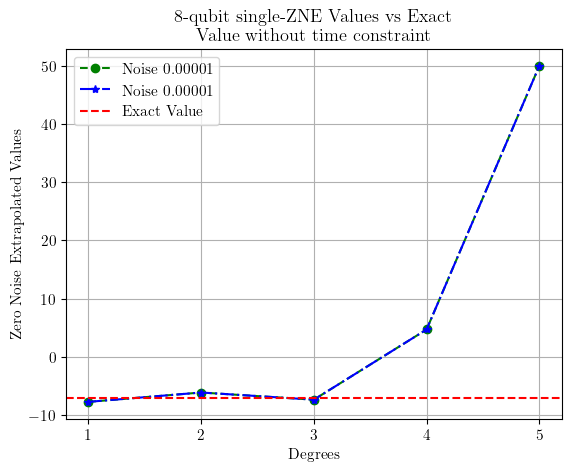

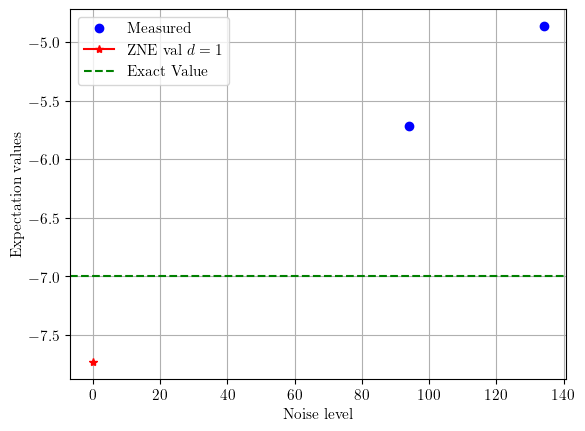

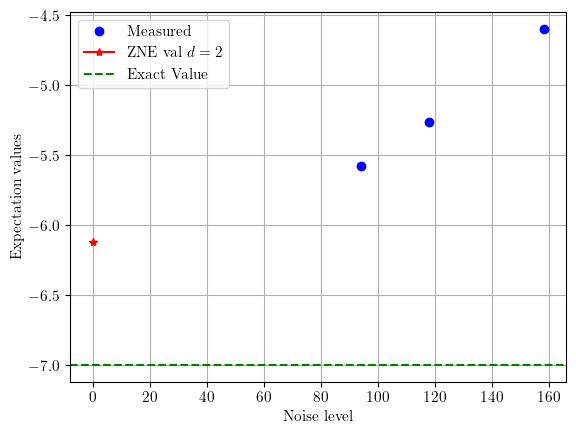

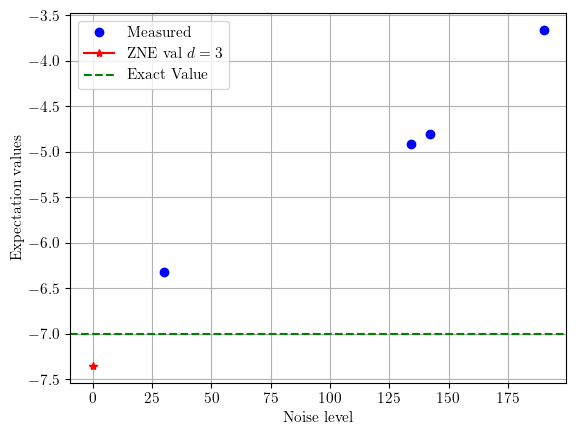

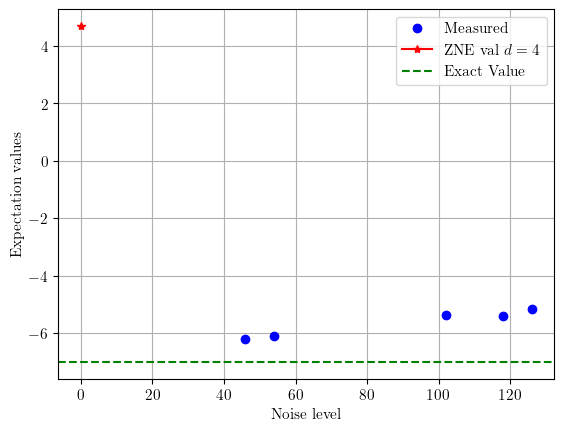

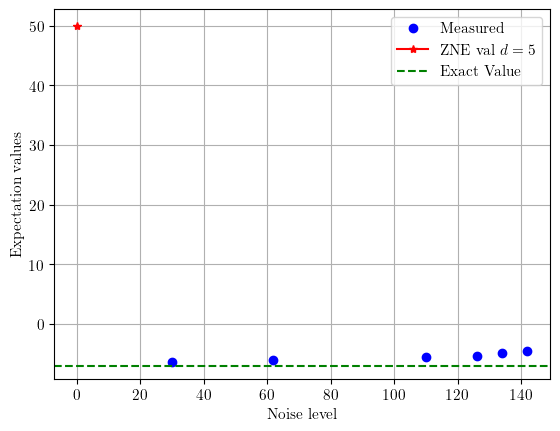

In [54]:
data_Q8N2_single = get_single_noise_val(nqubits = 8, noise_param = data_Q8N2)

zne_Q8N2_D1_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N2_single, 2), degree = 1)
zne_Q8N2_D2_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N2_single, 3), degree = 2)
zne_Q8N2_D3_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N2_single, 4), degree = 3)
zne_Q8N2_D4_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N2_single, 5), degree = 4)
zne_Q8N2_D5_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N2_single, 6), degree = 5)

zne_Q8N2_single_vals = [
    zne_Q8N2_D1_single.getRichardsonZNE(),
    zne_Q8N2_D2_single.getRichardsonZNE(),
    zne_Q8N2_D3_single.getRichardsonZNE(),
    zne_Q8N2_D4_single.getRichardsonZNE(),
    zne_Q8N2_D5_single.getRichardsonZNE(),
]

zne_Q8N2_single_vals_default = [
    zne_Q8N2_D1_single.getRichardsonSingleZNE(),
    zne_Q8N2_D2_single.getRichardsonSingleZNE(),
    zne_Q8N2_D3_single.getRichardsonSingleZNE(),
    zne_Q8N2_D4_single.getRichardsonSingleZNE(),
    zne_Q8N2_D5_single.getRichardsonSingleZNE(),
]

for E in zne_Q8N2_single_vals:
    print(f"Zne val: {E}")

labels = ["1", "2", "3", "4", "5"]
plt.figure(1)
plt.plot(labels, zne_Q8N2_single_vals, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.plot(labels, zne_Q8N2_single_vals_default, marker='*', linestyle='-.', color='blue', label='Noise 0.00001')
plt.axhline(y = exact_Q8, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Degrees')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('8-qubit single-ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

#####################Expectation values vs noise level#####################
plt.figure(2)
plt.plot(zne_Q8N2_D1_single.get_noise_levels(), zne_Q8N2_D1_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N2_D1_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=1$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(3)
plt.plot(zne_Q8N2_D2_single.get_noise_levels(), zne_Q8N2_D2_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N2_D2_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=2$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(4)
plt.plot(zne_Q8N2_D3_single.get_noise_levels(), zne_Q8N2_D3_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N2_D3_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=3$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(5)
plt.plot(zne_Q8N2_D4_single.get_noise_levels(), zne_Q8N2_D4_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N2_D4_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=4$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)

plt.figure(6)
plt.plot(zne_Q8N2_D5_single.get_noise_levels(), zne_Q8N2_D5_single.get_expec_vals(), linestyle='None', marker='o', color='blue', label='Measured')
plt.plot(0, zne_Q8N2_D5_single.getRichardsonSingleZNE(), marker='*', color='red', label='ZNE val $d=5$')
plt.axhline(y=exact_Q8, color='g', linestyle='--', label='Exact Value')
plt.xlabel('Noise level')
plt.ylabel('Expectation values')
plt.legend()
plt.grid(True)


In [1442]:

from sklearn.linear_model import LinearRegression

# Extract independent variables (X) and dependent variable (E)
X = np.array([[x, y, z] for x, y, z, E in data_Q8N1])
E = np.array([E for x, y, z, E in data_Q8N1])

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, E)

# Predict E at (0, 0, 0)
E_at_0_0_0 = model.predict(np.array([[0, 0, 0]]))

# Output the predicted value
E_at_0_0_0[0]


-6.673314251416798

In [1445]:

from sklearn.preprocessing import PolynomialFeatures

# Extract independent variables (X) and dependent variable (E)
X = np.array([[x, y, z] for x, y, z, E in data_Q8N1])
E = np.array([E for x, y, z, E in data_Q8N1])

# Generate polynomial features
degree = 2  # Specify the degree of the polynomial regression
poly = PolynomialFeatures(7)
X_poly = poly.fit_transform(X)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_poly, E)

# Predict E at (0, 0, 0) using polynomial features
E_at_0_0_0 = model.predict(poly.transform(np.array([[0, 0, 0]])))

# Output the predicted value
E_at_0_0_0[0]


-6.589484425394378

----------------------

# OLD

### D. Result: Error mitigation

#### (1) Multivariate-ZNE

##### 4-qubit multi-variate ZNE

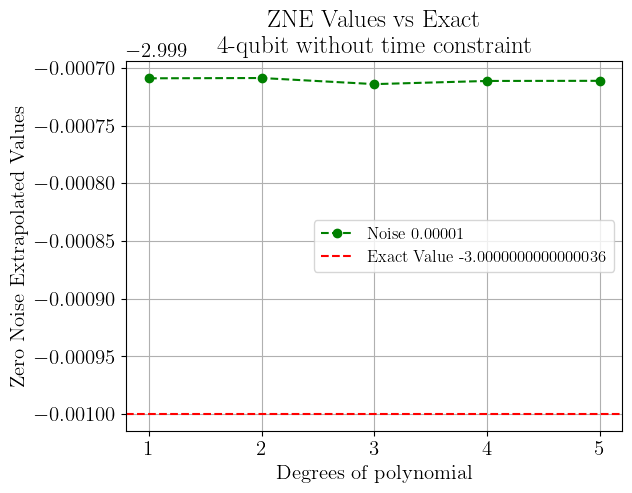

In [832]:
zne_Q4N1_D1= ZeroNoiseExtrapolation(dataPoints = data_Q4N1[:4], degree = 1)
zne_Q4N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q4N1[:10], degree = 2)
zne_Q4N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q4N1[:20], degree = 3)
zne_Q4N1_D4= ZeroNoiseExtrapolation(dataPoints = data_Q4N1[:35], degree = 4)
zne_Q4N1_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q4N1, degree = 5)

exact_val_Q4 = -3.0000000000000036
zne_Q4N1_D1_val = zne_Q4N1_D1.getRichardsonZNE()
zne_Q4N1_D2_val = zne_Q4N1_D2.getRichardsonZNE()
zne_Q4N1_D3_val = zne_Q4N1_D3.getRichardsonZNE()
zne_Q4N1_D4_val = zne_Q4N1_D4.getRichardsonZNE()
zne_Q4N1_D5_val = zne_Q4N1_D5.getRichardsonZNE()

"""Ploting result"""
# List of zne values for 8-qubit with noise probabilities N1 = [0.00001, 0.00001, 0.00001, 0.00001] 
zne_vals_Q4N1 = [
    zne_Q4N1_D1_val,
    zne_Q4N1_D2_val,
    zne_Q4N1_D3_val,
    zne_Q4N1_D4_val,
    zne_Q4N1_D5_val
]

# Corresponding labels which represents degrees of the polynomial
labels = [str(i) for i in range(1, len(zne_vals_Q4N1)+1)]

# Plotting the graph
plt.plot(labels, zne_vals_Q4N1, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_Q4, color='r', linestyle='--', label=f'Exact Value {exact_val_Q4}')
plt.xlabel('Degrees of polynomial')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('ZNE Values vs Exact \n 4-qubit without time constraint')
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

##### 8-qubit multi-variate ZNE

In [340]:
len(data_Q8N1)

84

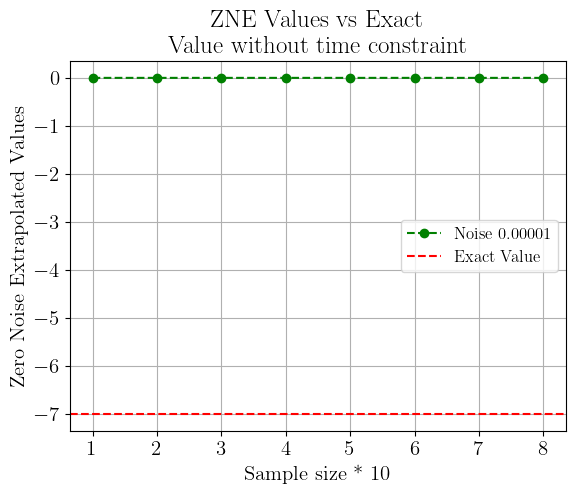

In [851]:
# zne_Q8N1_D1= ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :4], degree = 1)
# zne_Q8N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :10], degree = 2)
# zne_Q8N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :20], degree = 3)
# zne_Q8N1_D4= ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :35], degree = 4)
# zne_Q8N1_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :56], degree = 5)
# zne_Q8N1_D6 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 84], degree= 6)

zne_Q8N1_D2_sample1 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[:10], 10), degree = 2)
zne_Q8N1_D2_sample2 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[: 20], 10), degree = 2)
zne_Q8N1_D2_sample3 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ :30], 10), degree = 2)
zne_Q8N1_D2_sample4 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ :40], 10), degree = 2)
zne_Q8N1_D2_sample5 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 50], 10), degree = 2)
zne_Q8N1_D2_sample6 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 60], 10), degree = 2)
zne_Q8N1_D2_sample7 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 70], 10), degree = 2)
zne_Q8N1_D2_sample8 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 84], 10), degree = 2)
# zne_Q8N1_D2_sample9 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample10 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample11 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample12 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)


exact_val_Q8 = -7.000000000000004
zne_Q8N1_D2_sample1_val = zne_Q8N1_D2_sample1.getRichardsonZNE2()
zne_Q8N1_D2_sample2_val = zne_Q8N1_D2_sample2.getRichardsonZNE2()
zne_Q8N1_D2_sample3_val = zne_Q8N1_D2_sample3.getRichardsonZNE2()
zne_Q8N1_D2_sample4_val = zne_Q8N1_D2_sample4.getRichardsonZNE2()

zne_Q8N1_D2_sample5_val = zne_Q8N1_D2_sample5.getRichardsonZNE2()
zne_Q8N1_D2_sample6_val = zne_Q8N1_D2_sample6.getRichardsonZNE2()
zne_Q8N1_D2_sample7_val = zne_Q8N1_D2_sample7.getRichardsonZNE2()
zne_Q8N1_D2_sample8_val = zne_Q8N1_D2_sample8.getRichardsonZNE2()

# zne_Q8N1_D2_sample9_val = zne_Q8N1_D2_sample9.getRichardsonZNE()
# zne_Q8N1_D2_sample10_val = zne_Q8N1_D2_sample10.getRichardsonZNE()
# zne_Q8N1_D2_sample11_val = zne_Q8N1_D2_sample11.getRichardsonZNE()
# zne_Q8N1_D2_sample12_val = zne_Q8N1_D2_sample12.getRichardsonZNE()


"""Ploting result"""
# List of zne values for 8-qubit with noise probabilities N1 = [0.00001, 0.00001, 0.00001, 0.00001] 
zne_vals_Q8N1 = [
    zne_Q8N1_D2_sample1_val,
    zne_Q8N1_D2_sample2_val,
    zne_Q8N1_D2_sample3_val,
    zne_Q8N1_D2_sample4_val,
    zne_Q8N1_D2_sample5_val,
    zne_Q8N1_D2_sample6_val,
    zne_Q8N1_D2_sample7_val,
    zne_Q8N1_D2_sample8_val,
    # zne_Q8N1_D2_sample9_val,
    # zne_Q8N1_D2_sample10_val,
    # zne_Q8N1_D2_sample11_val,
    # zne_Q8N1_D2_sample12_val,
]

# Corresponding labels which represents degrees of the polynomial
labels = [str(i) for i in range(1, len(zne_vals_Q8N1)+1)]

# Plotting the graph
#plt.figure(figsize=(10, 7))
plt.plot(labels, zne_vals_Q8N1, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_Q8, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Sample size * 10')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
#plt.ylim(-7.1, 0)
# Show the plot
plt.show()

Det : 384.0
Det : -703.9999999999999
Det : 384.0
Det : 384.0
Det : 255.99999999999994
Det : -768.0000000000001
Det : -1023.9999999999991
Det : -1152.0000000000005


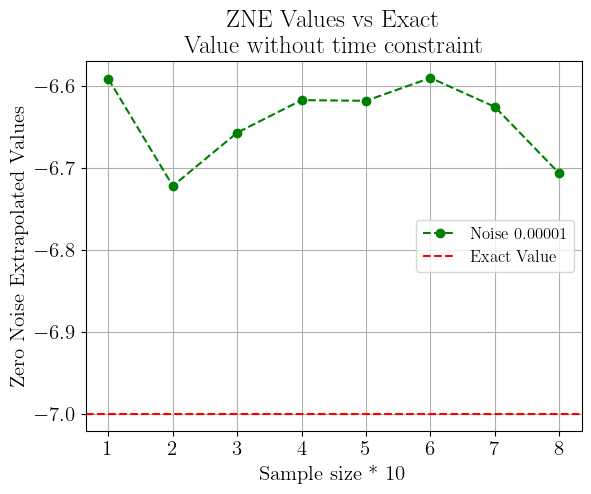

In [1249]:
# zne_Q8N1_D1= ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :4], degree = 1)
# zne_Q8N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :10], degree = 2)
# zne_Q8N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :20], degree = 3)
# zne_Q8N1_D4= ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :35], degree = 4)
# zne_Q8N1_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :56], degree = 5)
# zne_Q8N1_D6 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 84], degree= 6)

zne_Q8N1_D1_sample1 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[:10], 4), degree = 1)
zne_Q8N1_D1_sample2 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[: 20], 4), degree = 1)
zne_Q8N1_D1_sample3 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ :30], 4), degree = 1)
zne_Q8N1_D1_sample4 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ :40], 4), degree = 1)
zne_Q8N1_D1_sample5 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 50], 4), degree = 1)
zne_Q8N1_D1_sample6 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 60], 4), degree = 1)
zne_Q8N1_D1_sample7 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 70], 4), degree = 1)
zne_Q8N1_D1_sample8 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 84], 4), degree = 1)
# zne_Q8N1_D2_sample9 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample10 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample11 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample12 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)


exact_val_Q8 = -7.000000000000004
zne_Q8N1_D1_sample1_val = zne_Q8N1_D1_sample1.getRichardsonZNE()
zne_Q8N1_D1_sample2_val = zne_Q8N1_D1_sample2.getRichardsonZNE()
zne_Q8N1_D1_sample3_val = zne_Q8N1_D1_sample3.getRichardsonZNE()
zne_Q8N1_D1_sample4_val = zne_Q8N1_D1_sample4.getRichardsonZNE()

zne_Q8N1_D1_sample5_val = zne_Q8N1_D1_sample5.getRichardsonZNE()
zne_Q8N1_D1_sample6_val = zne_Q8N1_D1_sample6.getRichardsonZNE()
zne_Q8N1_D1_sample7_val = zne_Q8N1_D1_sample7.getRichardsonZNE()
zne_Q8N1_D1_sample8_val = zne_Q8N1_D1_sample8.getRichardsonZNE()

# zne_Q8N1_D2_sample9_val = zne_Q8N1_D2_sample9.getRichardsonZNE()
# zne_Q8N1_D2_sample10_val = zne_Q8N1_D2_sample10.getRichardsonZNE()
# zne_Q8N1_D2_sample11_val = zne_Q8N1_D2_sample11.getRichardsonZNE()
# zne_Q8N1_D2_sample12_val = zne_Q8N1_D2_sample12.getRichardsonZNE()


"""Ploting result"""
# List of zne values for 8-qubit with noise probabilities N1 = [0.00001, 0.00001, 0.00001, 0.00001] 
zne_vals_Q8N1 = [
    zne_Q8N1_D1_sample1_val,
    zne_Q8N1_D1_sample2_val,
    zne_Q8N1_D1_sample3_val,
    zne_Q8N1_D1_sample4_val,
    zne_Q8N1_D1_sample5_val,
    zne_Q8N1_D1_sample6_val,
    zne_Q8N1_D1_sample7_val,
    zne_Q8N1_D1_sample8_val,
    # zne_Q8N1_D2_sample9_val,
    # zne_Q8N1_D2_sample10_val,
    # zne_Q8N1_D2_sample11_val,
    # zne_Q8N1_D2_sample12_val,
]

# Corresponding labels which represents degrees of the polynomial
labels = [str(i) for i in range(1, len(zne_vals_Q8N1)+1)]

# Plotting the graph
#plt.figure(figsize=(10, 7))
plt.plot(labels, zne_vals_Q8N1, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_Q8, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Sample size * 10')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
#plt.ylim(-7.1, -5)
# Show the plot
plt.show()

In [916]:
# zne_Q8N1_D1= ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :4], degree = 1)
# zne_Q8N1_D2 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :10], degree = 2)
# zne_Q8N1_D3 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :20], degree = 3)
# zne_Q8N1_D4= ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :35], degree = 4)
# zne_Q8N1_D5 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ :56], degree = 5)
# zne_Q8N1_D6 = ZeroNoiseExtrapolation(dataPoints = data_Q8N1[ : 84], degree= 6)

zne_Q8N1_D3_sample1 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 20], 20), degree = 3)
zne_Q8N1_D3_sample2 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 30], 20), degree = 3)
zne_Q8N1_D3_sample3 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 40], 20), degree = 3)
zne_Q8N1_D3_sample4 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 50], 20), degree = 3)
zne_Q8N1_D3_sample5 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 60], 20), degree = 3)
zne_Q8N1_D3_sample6 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 70], 20), degree = 3)
zne_Q8N1_D3_sample7 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 80], 20), degree = 3)
# zne_Q8N1_D1_sample8 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1[ : 84], 4), degree = 1)
# zne_Q8N1_D2_sample9 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample10 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample11 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)
# zne_Q8N1_D2_sample12 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1, 10), degree = 2)


exact_val_Q8 = -7.000000000000004
zne_Q8N1_D3_sample1_val = zne_Q8N1_D3_sample1.getRichardsonZNE()
zne_Q8N1_D3_sample2_val = zne_Q8N1_D3_sample2.getRichardsonZNE()
zne_Q8N1_D3_sample3_val = zne_Q8N1_D3_sample3.getRichardsonZNE()
zne_Q8N1_D3_sample4_val = zne_Q8N1_D3_sample4.getRichardsonZNE()

zne_Q8N1_D3_sample5_val = zne_Q8N1_D3_sample5.getRichardsonZNE()
zne_Q8N1_D3_sample6_val = zne_Q8N1_D3_sample6.getRichardsonZNE()
zne_Q8N1_D3_sample7_val = zne_Q8N1_D3_sample7.getRichardsonZNE()
#zne_Q8N1_D1_sample8_val = zne_Q8N1_D1_sample8.getRichardsonZNE()

# zne_Q8N1_D2_sample9_val = zne_Q8N1_D2_sample9.getRichardsonZNE()
# zne_Q8N1_D2_sample10_val = zne_Q8N1_D2_sample10.getRichardsonZNE()
# zne_Q8N1_D2_sample11_val = zne_Q8N1_D2_sample11.getRichardsonZNE()
# zne_Q8N1_D2_sample12_val = zne_Q8N1_D2_sample12.getRichardsonZNE()


"""Ploting result"""
# List of zne values for 8-qubit with noise probabilities N1 = [0.00001, 0.00001, 0.00001, 0.00001] 
zne_vals_Q8N1 = [
    zne_Q8N1_D3_sample1_val,
    zne_Q8N1_D3_sample2_val,
    zne_Q8N1_D3_sample3_val,
    zne_Q8N1_D3_sample4_val,
    zne_Q8N1_D3_sample5_val,
    zne_Q8N1_D3_sample6_val,
    zne_Q8N1_D3_sample7_val,
    #zne_Q8N1_D3_sample8_val,
    # zne_Q8N1_D2_sample9_val,
    # zne_Q8N1_D2_sample10_val,
    # zne_Q8N1_D2_sample11_val,
    # zne_Q8N1_D2_sample12_val,
]

# Corresponding labels which represents degrees of the polynomial
labels = [str(i) for i in range(1, len(zne_vals_Q8N1)+1)]

# Plotting the graph
#plt.figure(figsize=(10, 7))
plt.plot(labels, zne_vals_Q8N1, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_Q8, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Sample size * 10')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)
plt.ylim(-7.1, -5)
# Show the plot
plt.show()

ValueError: Determinant of sample matrix close to inf. Det: 4.4861444857740816e+36, Deg: 3

#### (2) Single variable-ZNE

The following utility function maps 3-variable noise level into a single variable noise level

In [789]:
def get_single_noise_val(nqubits: int, noise_param: List[Tuple[int, int, int, float]]) -> List[Tuple[int, int, int, float]]:
    """
    Generate a single noise value for extrapolation.
    """
    result = []
    for nR, nT, nY, E in noise_param:
        noise_level = nR + (nqubits*nT) + (nY*2) + 2
        result.append((noise_level, E))
    return result

##### 4-qubit single variable ZNE

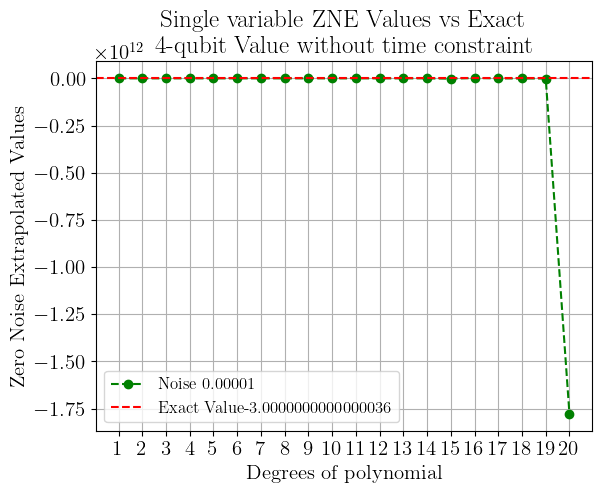

In [830]:
data_Q4N1_single = get_single_noise_val(nqubits = 4, noise_param = data_Q4N1)
zne_Q4N1_D1_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 2), degree = 1)
zne_Q4N1_D2_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 3), degree = 2)
zne_Q4N1_D3_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 4), degree = 3)
zne_Q4N1_D4_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 5), degree = 4)
zne_Q4N1_D5_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 6), degree = 5)
zne_Q4N1_D6_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 7), degree = 6)
zne_Q4N1_D7_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 8), degree = 7)
zne_Q4N1_D8_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 9), degree = 8)
zne_Q4N1_D9_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 10), degree = 9)
zne_Q4N1_D10_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 11), degree = 10)
zne_Q4N1_D11_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 12), degree = 11)
zne_Q4N1_D12_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 13), degree = 12)
zne_Q4N1_D13_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 14), degree = 13)
zne_Q4N1_D14_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 15), degree = 14)
zne_Q4N1_D15_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 16), degree = 15)
zne_Q4N1_D16_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 17), degree = 16)
zne_Q4N1_D17_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 18), degree = 17)
zne_Q4N1_D18_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 19), degree = 18)
zne_Q4N1_D19_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 20), degree = 19)
zne_Q4N1_D20_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q4N1_single, 21), degree = 20)

zne_Q4N1_D1_single_val = zne_Q4N1_D1_single.getRichardsonSingleZNE()
zne_Q4N1_D2_single_val = zne_Q4N1_D2_single.getRichardsonSingleZNE()
zne_Q4N1_D3_single_val = zne_Q4N1_D3_single.getRichardsonSingleZNE()
zne_Q4N1_D4_single_val = zne_Q4N1_D4_single.getRichardsonSingleZNE()
zne_Q4N1_D5_single_val = zne_Q4N1_D5_single.getRichardsonSingleZNE()
zne_Q4N1_D6_single_val = zne_Q4N1_D6_single.getRichardsonSingleZNE()
zne_Q4N1_D7_single_val = zne_Q4N1_D7_single.getRichardsonSingleZNE()
zne_Q4N1_D8_single_val = zne_Q4N1_D8_single.getRichardsonSingleZNE()
zne_Q4N1_D9_single_val = zne_Q4N1_D9_single.getRichardsonSingleZNE()
zne_Q4N1_D10_single_val = zne_Q4N1_D10_single.getRichardsonSingleZNE()
zne_Q4N1_D11_single_val = zne_Q4N1_D11_single.getRichardsonSingleZNE()
zne_Q4N1_D12_single_val = zne_Q4N1_D12_single.getRichardsonSingleZNE()
zne_Q4N1_D13_single_val = zne_Q4N1_D13_single.getRichardsonSingleZNE()
zne_Q4N1_D14_single_val = zne_Q4N1_D14_single.getRichardsonSingleZNE()
zne_Q4N1_D15_single_val = zne_Q4N1_D15_single.getRichardsonSingleZNE()
zne_Q4N1_D16_single_val = zne_Q4N1_D16_single.getRichardsonSingleZNE()
zne_Q4N1_D17_single_val = zne_Q4N1_D17_single.getRichardsonSingleZNE()
zne_Q4N1_D18_single_val = zne_Q4N1_D18_single.getRichardsonSingleZNE()
zne_Q4N1_D19_single_val = zne_Q4N1_D19_single.getRichardsonSingleZNE()
zne_Q4N1_D20_single_val = zne_Q4N1_D20_single.getRichardsonSingleZNE()


"""Ploting result"""
# List of zne values for 4-qubit with noise probabilities N1 = [0.00001, 0.00001, 0.00001, 0.00001] 
zne_Q4N1_single_vals = [
    zne_Q4N1_D1_single_val,
    zne_Q4N1_D2_single_val,
    zne_Q4N1_D3_single_val,
    zne_Q4N1_D4_single_val,
    zne_Q4N1_D5_single_val,
    zne_Q4N1_D6_single_val,
    zne_Q4N1_D7_single_val,
    zne_Q4N1_D8_single_val,
    zne_Q4N1_D9_single_val,
    zne_Q4N1_D10_single_val,
    zne_Q4N1_D11_single_val,
    zne_Q4N1_D12_single_val,
    zne_Q4N1_D13_single_val,
    zne_Q4N1_D14_single_val,
    zne_Q4N1_D15_single_val,
    zne_Q4N1_D16_single_val,
    zne_Q4N1_D17_single_val,
    zne_Q4N1_D18_single_val,
    zne_Q4N1_D19_single_val,
    zne_Q4N1_D20_single_val,
    
]

# Corresponding labels which represents degrees of the polynomial
labels = [str(i) for i in range(1, len(zne_Q4N1_single_vals)+1)]
#labels = ["1", "2", "3", "4", "11", "12", "13"]
# Set x and y axis limits


plt.plot(labels, zne_Q4N1_single_vals, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_Q4, color='r', linestyle='--', label=f'Exact Value{exact_val_Q4}')
plt.xlabel('Degrees of polynomial')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('Single variable ZNE Values vs Exact \n 4-qubit Value without time constraint')
plt.legend()
plt.grid(True)
# Set logarithmic scale if needed
#plt.yscale('log')
# Show the plot
plt.show()

In [781]:
data_Q4N1_single

[(10, -2.997479911971532),
 (18, -2.995225968234045),
 (30, -2.991887065145745),
 (38, -2.989617751848285),
 (26, -2.9929737903621514),
 (38, -2.989637441869657),
 (46, -2.987369867285577),
 (46, -2.9863048662238905),
 (54, -2.981776597357825),
 (62, -2.977255317475906),
 (34, -2.9907233769261365),
 (46, -2.987389580999148),
 (54, -2.9851237437450724),
 (54, -2.984059554984343),
 (62, -2.9795347554177174),
 (70, -2.975016939384755),
 (62, -2.9807332945587603),
 (70, -2.9739563914042693),
 (78, -2.9671951717398657),
 (86, -2.960449598632909),
 (42, -2.9884747264974836),
 (54, -2.9851434811073565),
 (62, -2.9828793798010422),
 (62, -2.9818160026972422),
 (70, -2.9772946696698916),
 (78, -2.9727803147301315),
 (70, -2.9784922869475805),
 (78, -2.9717205755804725),
 (86, -2.964964535473117),
 (94, -2.958224129722131),
 (78, -2.97517232954384),
 (86, -2.966157077049392),
 (94, -2.9571696315356415),
 (102, -2.948209905727264),
 (110, -2.9392778126273704),
 (50, -2.986227837648864),
 (62, -2.

##### 8-qubit single variable ZNE

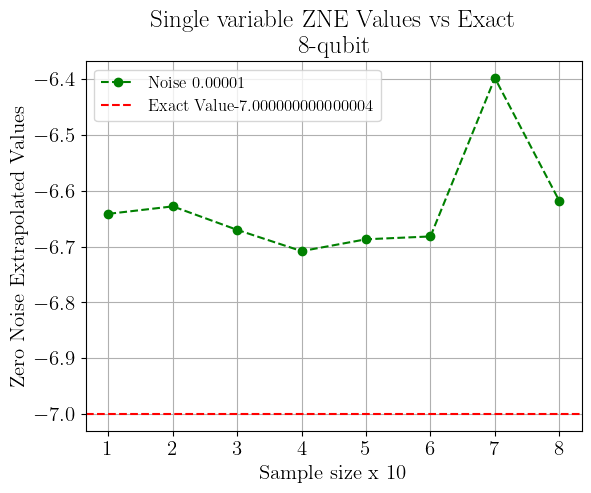

In [640]:
data_Q8N1_single = get_single_noise_val(nqubits = 8, noise_param = data_Q8N1)

zne_Q8N1_D1_single_sampl1 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ :10], 2), degree = 1)
zne_Q8N1_D1_single_sampl2 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 20], 2), degree = 1)
zne_Q8N1_D1_single_sampl3 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 30], 2), degree = 1)
zne_Q8N1_D1_single_sampl4 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 40], 2), degree = 1)
zne_Q8N1_D1_single_sampl5 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 50], 2), degree = 1)
zne_Q8N1_D1_single_sampl6 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 60], 2), degree = 1)
zne_Q8N1_D1_single_sampl7 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 70], 2), degree = 1)
zne_Q8N1_D1_single_sampl8 = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single[ : 80], 2), degree = 1)



zne_Q8N1_D1_single_sample1_val = zne_Q8N1_D1_single_sampl1.getRichardsonZNE()
zne_Q8N1_D1_single_sample2_val = zne_Q8N1_D1_single_sampl2.getRichardsonZNE()
zne_Q8N1_D1_single_sample3_val = zne_Q8N1_D1_single_sampl3.getRichardsonZNE()
zne_Q8N1_D1_single_sample4_val = zne_Q8N1_D1_single_sampl4.getRichardsonZNE()
zne_Q8N1_D1_single_sample5_val = zne_Q8N1_D1_single_sampl5.getRichardsonZNE()
zne_Q8N1_D1_single_sample6_val = zne_Q8N1_D1_single_sampl6.getRichardsonZNE()
zne_Q8N1_D1_single_sample7_val = zne_Q8N1_D1_single_sampl7.getRichardsonZNE()
zne_Q8N1_D1_single_sample8_val = zne_Q8N1_D1_single_sampl8.getRichardsonZNE()



"""Ploting result"""
# List of zne values for 4-qubit with noise probabilities N1 = [0.00001, 0.00001, 0.00001, 0.00001] 
zne_Q8N1_single_vals = [
    zne_Q8N1_D1_single_sample1_val,
    zne_Q8N1_D1_single_sample2_val,
    zne_Q8N1_D1_single_sample3_val,
    zne_Q8N1_D1_single_sample4_val,
    zne_Q8N1_D1_single_sample5_val,
    zne_Q8N1_D1_single_sample6_val,
    zne_Q8N1_D1_single_sample7_val,
    zne_Q8N1_D1_single_sample8_val,
]

# Corresponding labels which represents degrees of the polynomial
labels = [str(i) for i in range(1, len(zne_Q8N1_single_vals)+1)]
#labels = ["1", "2", "3", "4", "5", "6", "9", "10", "11", "12", "13", "14", "15", "16"]
# Plotting the graph

plt.plot(labels, zne_Q8N1_single_vals, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_Q8, color='r', linestyle='--', label=f'Exact Value{exact_val_Q8}')
plt.xlabel('Sample size x 10')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('Single variable ZNE Values vs Exact \n 8-qubit')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [800]:
# Given list of single-element tuples
tuples_list = [(86,), (70,), (92,), (58,), (77,)]

# Extracting first elements
result = [x[0] for x in tuples_list]

# Printing the result
print(result)  # Output: [86, 70, 92, 58, 77]


[86, 70, 92, 58, 77]


In [266]:
zne_Q8N1_D1_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 2), degree = 1)
zne_Q8N1_D2_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 3), degree = 2)
zne_Q8N1_D3_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 4), degree = 3)
zne_Q8N1_D4_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 5), degree = 4)
zne_Q8N1_D5_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 6), degree = 5)
zne_Q8N1_D6_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 7), degree = 6)
zne_Q8N1_D7_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 8), degree = 7)
zne_Q8N1_D8_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 9), degree = 8)
zne_Q8N1_D9_single = ZeroNoiseExtrapolation(dataPoints = random.sample(data_Q8N1_single, 10), degree = 9)
# zne_Q8N1_D10_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 11], degree = 10)
# zne_Q8N1_D11_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 12], degree = 11)
# zne_Q8N1_D12_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 13], degree = 12)
# zne_Q8N1_D13_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 14], degree = 13)
# zne_Q8N1_D14_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 15], degree = 14)
# zne_Q8N1_D15_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 16], degree = 15)
# zne_Q8N1_D16_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 17], degree = 16)
# zne_Q8N1_D17_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 18], degree = 17)
# zne_Q8N1_D18_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 19], degree = 18)
# zne_Q8N1_D19_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 20], degree = 19)
# zne_Q8N1_D20_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 21], degree = 20)
# zne_Q8N1_D21_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 22], degree = 21)
# zne_Q8N1_D22_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 23], degree = 22)
# zne_Q8N1_D23_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 24], degree = 23)
# zne_Q8N1_D24_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 25], degree = 24)
# zne_Q8N1_D25_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 26], degree = 25)
# zne_Q8N1_D26_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 27], degree = 26)
# zne_Q8N1_D27_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 28], degree = 27)
# zne_Q8N1_D28_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 29], degree = 28)
# zne_Q8N1_D29_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 30], degree = 29)
# zne_Q8N1_D30_single = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single[ : 31], degree = 30)

zne_Q8N1_D1_single_val = zne_Q8N1_D1_single.getRichardsonZNE()
zne_Q8N1_D2_single_val = zne_Q8N1_D2_single.getRichardsonZNE()
zne_Q8N1_D3_single_val = zne_Q8N1_D3_single.getRichardsonZNE()
zne_Q8N1_D4_single_val = zne_Q8N1_D4_single.getRichardsonZNE()
zne_Q8N1_D5_single_val = zne_Q8N1_D5_single.getRichardsonZNE()
zne_Q8N1_D6_single_val = zne_Q8N1_D6_single.getRichardsonZNE()
zne_Q8N1_D7_single_val = zne_Q8N1_D7_single.getRichardsonZNE()
zne_Q8N1_D8_single_val = zne_Q8N1_D8_single.getRichardsonZNE()
zne_Q8N1_D9_single_val = zne_Q8N1_D9_single.getRichardsonZNE()
zne_Q8N1_D10_single_val = zne_Q8N1_D10_single.getRichardsonZNE()
# zne_Q8N1_D11_single_val = zne_Q8N1_D11_single.getRichardsonZNE()
# zne_Q8N1_D12_single_val = zne_Q8N1_D12_single.getRichardsonZNE()
# zne_Q8N1_D13_single_val = zne_Q8N1_D13_single.getRichardsonZNE()
# zne_Q8N1_D14_single_val = zne_Q8N1_D14_single.getRichardsonZNE()
# zne_Q8N1_D15_single_val = zne_Q8N1_D15_single.getRichardsonZNE()
# zne_Q8N1_D16_single_val = zne_Q8N1_D16_single.getRichardsonZNE()
# #zne_Q8N1_D17_single_val = zne_Q8N1_D17_single.getRichardsonZNE()
# #zne_Q8N1_D18_single_val = zne_Q8N1_D18_single.getRichardsonZNE()
# #zne_Q8N1_D19_single_val = zne_Q8N1_D19_single.getRichardsonZNE()
# #zne_Q8N1_D20_single_val = zne_Q8N1_D20_single.getRichardsonZNE()
# #zne_Q8N1_D21_single_val = zne_Q8N1_D21_single.getRichardsonZNE()
# #zne_Q8N1_D22_single_val = zne_Q8N1_D22_single.getRichardsonZNE()
# #zne_Q8N1_D23_single_val = zne_Q8N1_D23_single.getRichardsonZNE()
# #zne_Q8N1_D24_single_val = zne_Q8N1_D24_single.getRichardsonZNE()
# zne_Q8N1_D25_single_val = zne_Q8N1_D25_single.getRichardsonZNE()
# #zne_Q8N1_D26_single_val = zne_Q8N1_D26_single.getRichardsonZNE()
# #zne_Q8N1_D27_single_val = zne_Q8N1_D27_single.getRichardsonZNE()
# #zne_Q8N1_D28_single_val = zne_Q8N1_D28_single.getRichardsonZNE()
# #zne_Q8N1_D29_single_val = zne_Q8N1_D29_single.getRichardsonZNE()
# zne_Q8N1_D30_single_val = zne_Q8N1_D30_single.getRichardsonZNE()

ValueError: Determinant of sample matrix is zero. Deg: 5

In [180]:
def plot_zne_polyd (zne_vals: List[float], exact_val: float, noise_prob: float, title: str):
   """
   Plots extrapolated values vs degrees of polynomial. 
   """
   labels = [str(i) for i in range(1, len(zne_vals)+1)]

   plt.plot(labels, zne_vals, marker='o', linestyle='--', color='green', label=f'Noise {noise_prob}')
   plt.axhline(y=exact_val, color='r', linestyle='--', label='Exact Value')
   plt.xlabel('Degrees of polynomial')
   plt.ylabel('Zero Noise Extrapolated Values')
   plt.title(title)
   plt.legend()
   plt.grid(True)
   plt.show()
    

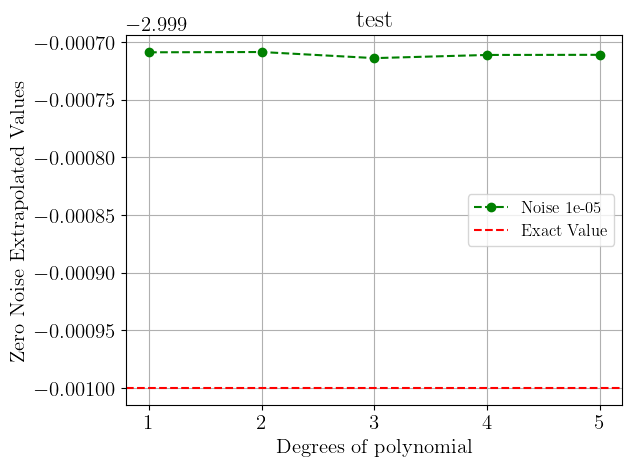

In [ ]:
plot_zne_polyd(zne_vals_Q4N1, exact_val_Q4, 0.00001, "test")

---

In [ ]:
"""
4-qubit system with 10 layers.
Exact sol: -3.0000000000000036
Noise prpbabilities: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized parameters without time constraint: [1.3627178221278613, 2.664542631979086, 0.7778304314389796, 5.08976011939805, 4.355201704522217, 5.524025790877457, 6.661083563496561, 6.734487955043819, 7.718699292684051, 8.640776739328741, 0.24227928169149046, 0.03502519151548362, -0.21602565927981202, 0.5794594972694906, -0.10427357485122196, -0.3452881050356924, 0.40205820972086187, -0.2008950032780847, 0.7298684934699999, -0.22946644587574697, 0.2894289098069959, 0.8093573474213096, 0.09500397802339218, 0.04863119825308582, -0.08482947373670244, 0.7782157014552835, 0.10629352646824314, 0.3859329126657005, -0.2812081405174874, -0.4933425127332805, -0.2657235464595865, -0.5360891458005344, -0.350989707586727, 0.25781763824022025, 0.5896775390789757, -0.23264039936319045, -0.10828982150182836, -0.6034661732301055, 0.29383021498500045, 0.2370023744147322, 0.08273028234283035, -0.4885993714831949, 0.10242915265700583, 0.49870256638484156, 0.12927638871301825, -0.19999588301270663, 0.046577695705521685, 0.46763976717087646, 0.14163349612554071, 0.04072755599252544]
"""

data_4Q_noise1 = [
    (4, 1, 0, -2.997479911971532),   # Noise factor [0, 0, 0]
    (12, 1, 0, -2.995225968234045), # Noise factor [1, 0, 0]
    (12, 3, 2, -2.991887065145745), # Noise factor [1, 1, 0]
    (12, 3, 6, -2.989617751848285), # Noise factor [1, 1, 1]
    (20, 1, 0, -2.9929737903621514), # Noise factor [2, 0, 0]
    (20, 3, 2, -2.989637441869657), # Noise factor [2, 1, 0]
    (20, 3, 6, -2.987369867285577), # Noise factor [2, 1, 1]
    (20, 5, 2, -2.9863048662238905), # Noise factor [2, 2, 0]
    (20, 5, 6, -2.981776597357825), # Noise factor [2, 2, 1]
    (20, 5, 10, -2.977255317475906), # Noise factor [2, 2, 2]
    (28, 1, 0, -2.9907233769261365), # Noise factor [3, 0, 0]
    (28, 3, 2, -2.987389580999148), # Noise factor [3, 1, 0]
    (28, 3, 6, -2.9851237437450724), # Noise factor [3, 1, 1]
    (28, 5, 2, -2.984059554984343), # Noise factor [3, 2, 0]
    (28, 5, 6, -2.9795347554177174), # Noise factor [3, 2, 1]
    (28, 5, 10, -2.975016939384755), # Noise factor [3, 2, 2]
    (28, 7, 2, -2.9807332945587603), # Noise factor [3, 3, 0]
    (28, 7, 6, -2.9739563914042693), # Noise factor [3, 3, 1]
    (28, 7, 10, -2.9671951717398657), # Noise factor [3, 3, 2]
    (28, 7, 14, -2.960449598632909), # Noise factor [3, 3, 3]
    (36, 1, 0, -2.9884747264974836), # Noise factor [4, 0, 0]
    (36, 3, 2, -2.9851434811073565), # Noise factor [4, 1, 0]
    (36, 3, 6, -2.9828793798010422), # Noise factor [4, 1, 1]
    (36, 5, 2, -2.9818160026972422), # Noise factor [4, 2, 0]
    (36, 5, 6, -2.9772946696698916), # Noise factor [4, 2, 1]
    (36, 5, 10, -2.9727803147301315), # Noise factor [4, 2, 2]
    (36, 7, 2, -2.9784922869475805), # Noise factor [4, 3, 0]
    (36, 7, 6, -2.9717205755804725), # Noise factor [4, 3, 1]
    (36, 7, 10, -2.964964535473117), # Noise factor [4, 3, 2]
    (36, 7, 14, -2.958224129722131), # Noise factor [4, 3, 3]
    (36, 9, 2, -2.97517232954384), # Noise factor [4, 4, 0]
    (36, 9, 6, -2.966157077049392), # Noise factor [4, 4, 1]
    (36, 9, 10, -2.9571696315356415), # Noise factor [4, 4, 2]
    (36, 9, 14, -2.948209905727264), # Noise factor [4, 4, 3]
    (36, 9, 18, -2.9392778126273704), # Noise factor [4, 4, 4]
    (44, 1, 0, -2.986227837648864), # Noise factor [5, 0, 0]
    (44, 3, 2, -2.9828991407686187), # Noise factor [5, 1, 0]
    (44, 3, 6, -2.9806367740289605), # Noise factor [5, 1, 1]
    (44, 5, 2, -2.9795742079385734), # Noise factor [5, 2, 0]
    (44, 5, 6, -2.9750563386926103), # Noise factor [5, 2, 1]
    (44, 5, 10, -2.970545442092549), # Noise factor [5, 2, 2]
    (44, 7, 2, -2.9762530348425793), # Noise factor [5, 3, 0]
    (44, 7, 6, -2.9694865111324895), # Noise factor [5, 3, 1]
    (44, 7, 10, -2.9627356464616725), # Noise factor [5, 3, 2]
    (44, 7, 14, -2.9560004039560117), # Noise factor [5, 3, 3]
    (44, 9, 2, -2.972935617169511), # Noise factor [5, 4, 0]
    (44, 9, 6, -2.963927270881401), # Noise factor [5, 4, 1]
    (44, 9, 10, -2.954946709890718), # Noise factor [5, 4, 2]
    (44, 9, 14, -2.945993846991313), # Noise factor [5, 4, 3]
    (44, 9, 18, -2.9370685952552416), # Noise factor [5, 4, 4]
    (44, 11, 2, -2.9696219506132424), # Noise factor [5, 5, 0]
    (44, 11, 6, -2.9583785975122114), # Noise factor [5, 5, 1]
    (44, 11, 10, -2.9471785757963316), # Noise factor [5, 5, 2]
    (44, 11, 14, -2.936021715534731), # Noise factor [5, 5, 3]
    (44, 11, 18, -2.924907847473882), # Noise factor [5, 5, 4]
    (44, 11, 22, -2.913836803034901), # Noise factor [5, 5, 5]
]

zne_4Q_1D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_4Q_noise1[:4], degree = 1)
zne_4Q_2D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_4Q_noise1[:10], degree = 2)
zne_4Q_3D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_4Q_noise1[:20], degree = 3)
zne_4Q_4D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_4Q_noise1[:35], degree = 4)
zne_4Q_5D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_4Q_noise1, degree = 5)

exact_val_4Q = -3.0000000000000036
zne_4Q_1D_noise1_val = zne_4Q_1D_noise1.getRichardsonZNE()
zne_4Q_2D_noise1_val = zne_4Q_2D_noise1.getRichardsonZNE()
zne_4Q_3D_noise1_val = zne_4Q_3D_noise1.getRichardsonZNE()
zne_4Q_4D_noise1_val = zne_4Q_4D_noise1.getRichardsonZNE()
zne_4Q_5D_noise1_val = zne_4Q_5D_noise1.getRichardsonZNE()

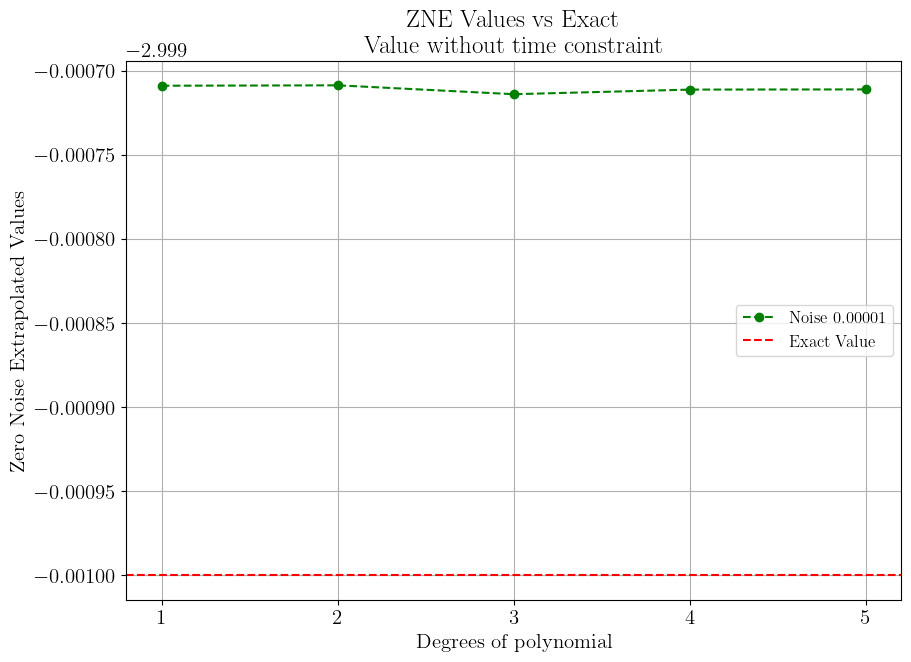

In [ ]:
# List of zne values for 8-qubit with noise probabilities [0.00001, 0.00001, 0.00001, 0.00001]

zne_vals_4Q_noise1 = [
    zne_4Q_1D_noise1_val,
    zne_4Q_2D_noise1_val,
    zne_4Q_3D_noise1_val,
    zne_4Q_4D_noise1_val,
    zne_4Q_5D_noise1_val
]

# Corresponding labels which represents degrees of the polynomial
labels = ["1", "2", "3", "4", "5"]

# Plotting the graph
plt.figure(figsize=(10, 7))
plt.plot(labels, zne_vals_4Q_noise1, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_4Q, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Degrees of polynomial')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### 8-qubit system

For a 8-qubit system we have our ansatz circuit with a depth of 25 layers.

In [ ]:
"""
8-qubit system with 25 layers.
Exact sol: -7.000000000000004
Noise prpbabilities: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized parameters without time constraint: [-1.598203452365122, -0.454626586570091, 1.4282421082448056, 0.015436042551439008, 0.9813223106420303, 0.6576478959055984, 3.8230724490399366, 1.6328198621735435, 3.930043867325021, 3.5749358773940294, 3.2741094538598423, 5.333661256371386, 5.228967410579761, 7.321512661931863, 7.28055210459519, 6.334421916248657, 6.291879649145826, 7.150978914105916, 7.179514788039292, 8.534289474738179, 8.978577286533756, 8.947180414801355, 10.823973087307959, 10.16734842539582, 10.241454235388934, -0.2098329604123184, -0.26055284411679486, 1.650927348803279, -2.352520908823862, -0.9250042151449581, 1.5036091726680993, 0.25525520683369235, -0.9930540188455652, 0.031299902058708334, -1.0690167417055687, -1.7183129459331394, 1.113306863722933, -0.31605496299853103, 1.4397004861923266, 0.34894963094763454, 1.51788110493564, -0.5227637946323876, 0.2176539602296948, -0.19773170079139468, 0.39922430899452205, 0.8721745477980981, -1.5445496607510734, -0.2427323307170025, -0.5465517938175843, -0.1971134226120807, 0.19283670511751194, 0.19085594130592307, 0.07697113231166389, 0.13257047530733815, 0.0071739577209740234, -0.38093094229796204, -0.3893121785092931, -1.7480001592761787, 0.26708448356490133, -0.2576947588923166, 0.09440798644437022, 1.285437556438038, 0.15058849991488407, -1.644790332627707, 0.3503329228225124, 0.7041004204937477, -0.0023955588893000007, 0.9076018225771513, -0.0715702121559551, 1.6868118774071919, 0.9216421038092796, 0.23318623363969845, -1.6946695515104755, -0.9662862558200821, 1.5668719975301024, 1.0735907673952012, 0.9333728199696584, -0.14498210992785804, 0.062124469949639466, 1.689908791267535, 0.39620580287656715, 1.7672380920245716, -0.013835905833801135, 1.0747063198116775, -0.0022877414464895626, 0.11942678144898249, -0.03436068030873114, 1.178277560292742, 2.2447135254332724, -0.6870279749304691, 1.6545494342336884, -0.3391957621360738, 0.10654407649226932, 0.0637381630811688, 0.014800671847975944, -0.07613542069227808, -0.11005787453742943, -1.898780864339826, -0.8483915811148912, -0.1441333431816059, 0.02530410691250804, -0.03664192113832491, -1.5811721011236184, -0.6280876641321144, -1.5981430039842626, -1.0604516965416935, -0.010566267564002299, -1.0910598693045526, -0.8146465543409181, 2.4249464186284735, -0.16203265445210321, -1.9327411011965903, 0.02005741064116468, 0.015489593446117115, -1.565862299569351, 1.5194446990160921, 1.4986478102931016, 0.6411139978837676, 0.03277197641916364, -0.37822107395511445, 0.3627171619734526, -0.28646017075972996, 2.4635153733716684, -0.8998933591618272, 0.0034769376819778295]
"""


---


## Single variable extrapolation

#### Utility functions

In [ ]:
from typing import List, Tuple

def get_single_noise_val(nqubits: int, noise_param: List[Tuple[int, int, int, float]]) -> List[Tuple[int, int, int, float]]:
    """
    Generate a single noise value for extrapolation.
    """
    result = []
    for nR, nT, nY, E in noise_param:
        computed_value = nR + (nqubits*nT) + nY + 2
        result.append((computed_value, E))
    return result

def sample_matrix(sample_points: list[int], degree: int) -> np.ndarray:
    """Construct a matrix from monomials evaluated at sample points."""
    n = len(sample_points[0])  # type: ignore # Number of variables based on the first sample point
    monomials = ZeroNoiseExtrapolation.get_monomials(n, degree) # type: ignore
    matrix = np.zeros((len(sample_points), len(monomials)))

    for i, point in enumerate(sample_points):
        for j, monomial in enumerate(monomials):
            var_mapping = {f"λ_{k+1}": point[k] for k in range(n)} # type: ignore
            matrix[i, j] = eval(monomial, {}, var_mapping)
    return matrix

### 8-qubit

In [ ]:
"""
8-qubit system with 25 layers.
Exact sol: -7.000000000000004
Noise prpbabilities: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized parameters without time constraint: [-1.598203452365122, -0.454626586570091, 1.4282421082448056, 0.015436042551439008, 0.9813223106420303, 0.6576478959055984, 3.8230724490399366, 1.6328198621735435, 3.930043867325021, 3.5749358773940294, 3.2741094538598423, 5.333661256371386, 5.228967410579761, 7.321512661931863, 7.28055210459519, 6.334421916248657, 6.291879649145826, 7.150978914105916, 7.179514788039292, 8.534289474738179, 8.978577286533756, 8.947180414801355, 10.823973087307959, 10.16734842539582, 10.241454235388934, -0.2098329604123184, -0.26055284411679486, 1.650927348803279, -2.352520908823862, -0.9250042151449581, 1.5036091726680993, 0.25525520683369235, -0.9930540188455652, 0.031299902058708334, -1.0690167417055687, -1.7183129459331394, 1.113306863722933, -0.31605496299853103, 1.4397004861923266, 0.34894963094763454, 1.51788110493564, -0.5227637946323876, 0.2176539602296948, -0.19773170079139468, 0.39922430899452205, 0.8721745477980981, -1.5445496607510734, -0.2427323307170025, -0.5465517938175843, -0.1971134226120807, 0.19283670511751194, 0.19085594130592307, 0.07697113231166389, 0.13257047530733815, 0.0071739577209740234, -0.38093094229796204, -0.3893121785092931, -1.7480001592761787, 0.26708448356490133, -0.2576947588923166, 0.09440798644437022, 1.285437556438038, 0.15058849991488407, -1.644790332627707, 0.3503329228225124, 0.7041004204937477, -0.0023955588893000007, 0.9076018225771513, -0.0715702121559551, 1.6868118774071919, 0.9216421038092796, 0.23318623363969845, -1.6946695515104755, -0.9662862558200821, 1.5668719975301024, 1.0735907673952012, 0.9333728199696584, -0.14498210992785804, 0.062124469949639466, 1.689908791267535, 0.39620580287656715, 1.7672380920245716, -0.013835905833801135, 1.0747063198116775, -0.0022877414464895626, 0.11942678144898249, -0.03436068030873114, 1.178277560292742, 2.2447135254332724, -0.6870279749304691, 1.6545494342336884, -0.3391957621360738, 0.10654407649226932, 0.0637381630811688, 0.014800671847975944, -0.07613542069227808, -0.11005787453742943, -1.898780864339826, -0.8483915811148912, -0.1441333431816059, 0.02530410691250804, -0.03664192113832491, -1.5811721011236184, -0.6280876641321144, -1.5981430039842626, -1.0604516965416935, -0.010566267564002299, -1.0910598693045526, -0.8146465543409181, 2.4249464186284735, -0.16203265445210321, -1.9327411011965903, 0.02005741064116468, 0.015489593446117115, -1.565862299569351, 1.5194446990160921, 1.4986478102931016, 0.6411139978837676, 0.03277197641916364, -0.37822107395511445, 0.3627171619734526, -0.28646017075972996, 2.4635153733716684, -0.8998933591618272, 0.0034769376819778295]
"""

data_Q8N1 = [
    (4, 1, 0, -6.586686232506038), # Noise factor [0, 0, 0]
    (12, 1, 0, -6.578928267594069), # Noise factor [1, 0, 0]
    (12, 3, 4, -6.555169918225676), # Noise factor [1, 1, 0]
    (12, 3, 12, -6.53907238285761), # Noise factor [1, 1, 1]
    (20, 1, 0, -6.571180283812833), # Noise factor [2, 0, 0]
    (20, 3, 4, -6.547451143813432), # Noise factor [2, 1, 0]
    (20, 3, 12, -6.53137342816183), # Noise factor [2, 1, 1]
    (20, 5, 4, -6.523812600595908), # Noise factor [2, 2, 0]
    (20, 5, 12, -6.491821400262652), # Noise factor [2, 2, 1]
    (20, 5, 20, -6.459996018753568), # Noiuse factor [2, 2, 2]
    (28, 1, 0,  -6.563442266892854), # Noise factor [3, 0, 0]
    (28, 3, 4, -6.539742296592507), # Noise factor [3, 1, 0]
    (28, 3, 12, -6.523684373685416), # Noise factor [3, 1, 1]
    (28, 5, 4, -6.5161328065139985), # Noise factor [3, 2, 0]
    (28, 5, 12, -6.484180979920743), # Noise factor [3, 2, 1]
    (28, 5, 20, -6.452394758126381), # Noise factor [3, 2, 2]
    (28, 7, 4, -6.492613433181837), # Noise factor [3, 3, 0]
    (28, 7, 12, -6.444930371640465), # Noise factor [3, 3, 1]
    (28, 7, 20, -6.397617411996776), # Noise factor [3, 3, 2]
    (28, 7, 28, -6.350671530645834), # Noise factor [3, 3, 3]
    (36, 1, 0, -6.555714202586656), # Noise factor [4, 0, 0]
    (36, 3, 4, -6.532043362374472), # Noise factor [4, 1, 0]
    (36, 3, 12, -6.516005205280183), # Noise factor [4, 1, 1]
    (36, 5, 4, -6.508462885989621), # Noise factor [4, 2, 0]
    (36, 5, 12, -6.476550379574356), # Noise factor [4, 2, 1]
    (36, 5, 20, -6.444803264237845), # Noise factor [4, 2, 2]
    (36, 7, 4,  -6.484972410444958), # Noise factor [4, 3, 0]
    (36, 7, 12, -6.437348013818665), # Noise factor [4, 3, 1]
    (36, 7, 20, -6.390093241603148), # Noise factor [4, 3, 2]
    (36, 7, 28, -6.343205074275518), # Noise factor [4, 3, 3]
    (36, 9, 4,  -6.461571574277893), # Noise factor [4, 4, 0]
    (36, 9, 12, -6.3983964084157945), # Noise factor [4, 4, 1]
    (36, 9, 20, -6.335873931931953), # Noise factor [4, 4, 2]
    (36, 9, 28, -6.2739970479778355), # Noise factor [4, 4, 3]
    (36, 9, 36, -6.212758740444894), # Noise factor [4, 4, 4]
    (44, 1, 0, -6.547996076668703), # Noise factor [5, 0, 0]
    (44, 3, 4, -6.524354326992758), # Noise factor [5, 1, 0]
    (44, 3, 12, -6.508335908819722), # Noise factor [5, 1, 1]
    (44, 5, 4, -6.50080282491491), # Noise factor [5, 2, 0]
    (44, 5, 12, -6.468929585195551), # Noise factor [5, 2, 1]
    (44, 5, 20, -6.4372215231393755), # Noise factor [5, 2, 2]
    (44, 7, 4, -6.477341207935643), # Noise factor [5, 3, 0]
    (44, 7, 12, -6.429775396450038), # Noise factor [5, 3, 1]
    (44, 7, 20, -6.382578732568697), # Noise factor [5, 3, 2]
    (44, 7, 28, -6.335748200844709), # Noise factor [5, 3, 3]
    (44, 9, 4, -6.453969115077857), # Noise factor [5, 4, 0]
    (44, 9, 12, -6.390871645273444), # Noise factor [5, 4, 1]
    (44, 9, 20, -6.3284260231514), # Noise factor [5, 4, 2]
    (44, 9, 28, -6.266625161439791), # Noise factor [5, 4, 3]
    (44, 9, 36, -6.205462053493209), # Noise factor [5, 4, 4]
    (44, 11, 4, -6.430686186880268), # Noise factor [5, 5, 0]
    (44, 11, 12, -6.352216646304327), # Noise factor [5, 5, 1]
    (44, 11, 20, -6.274758770413229), # Noise factor [5, 5, 2]
    (44, 11, 28, -6.198298833850601), # Noise factor [5, 5, 3]
    (44, 11, 36, -6.122823306083357), # Noise factor [5, 5, 4]
    (44, 11, 44, -6.048318848526524), # Noise factor [5, 5, 5]
]

In [ ]:
# data_Q8N1_single_var = get_single_noise_val(nqubits = 4, noise_param = data_Q8N1)
# zne_Q8N1_d1_single_var = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single_var[ :2], degree = 1)
# zne_Q8N1_d2_single_var = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single_var[ :3], degree = 2)
# zne_Q8N1_d3_single_var = ZeroNoiseExtrapolation(dataPoints = data_Q8N1_single_var[ :4], degree = 3)



-6.596383688645997

### 4-qubit

In [ ]:
data_4Q = [
    (4, 1, 0, -2.9974291552071852), # Noise factor [0, 0, 0]
    (12, 1, 0, -2.995110862727487), # Noise factor [1, 0, 0]
    (12, 3, 2, -2.9917241274581086), # Noise factor [1, 1, 0]
    (12, 3, 6, -2.9894343545281554), # Noise factor [1, 1, 1]
]

single_noise_data_4Q = get_single_noise_val(nqubits = 4, noise_param = data_4Q)
zne = ZeroNoiseExtrapolation(single_noise_data_4Q, 3)
#sample_matrix(single_noise_data_4Q, 1).shape
zne.getRichardsonZNE()

-3.0030412758299843

---

## Optimized param

In [ ]:
"""
8-qubit with 25 layers
Noise avl: [0.00001, 0.00001, 0.00001, 0.00001]
Optimized param: [-1.598203452365122, -0.454626586570091, 1.4282421082448056, 0.015436042551439008, 0.9813223106420303, 0.6576478959055984, 3.8230724490399366, 1.6328198621735435, 3.930043867325021, 3.5749358773940294, 3.2741094538598423, 5.333661256371386, 5.228967410579761, 7.321512661931863, 7.28055210459519, 6.334421916248657, 6.291879649145826, 7.150978914105916, 7.179514788039292, 8.534289474738179, 8.978577286533756, 8.947180414801355, 10.823973087307959, 10.16734842539582, 10.241454235388934, -0.2098329604123184, -0.26055284411679486, 1.650927348803279, -2.352520908823862, -0.9250042151449581, 1.5036091726680993, 0.25525520683369235, -0.9930540188455652, 0.031299902058708334, -1.0690167417055687, -1.7183129459331394, 1.113306863722933, -0.31605496299853103, 1.4397004861923266, 0.34894963094763454, 1.51788110493564, -0.5227637946323876, 0.2176539602296948, -0.19773170079139468, 0.39922430899452205, 0.8721745477980981, -1.5445496607510734, -0.2427323307170025, -0.5465517938175843, -0.1971134226120807, 0.19283670511751194, 0.19085594130592307, 0.07697113231166389, 0.13257047530733815, 0.0071739577209740234, -0.38093094229796204, -0.3893121785092931, -1.7480001592761787, 0.26708448356490133, -0.2576947588923166, 0.09440798644437022, 1.285437556438038, 0.15058849991488407, -1.644790332627707, 0.3503329228225124, 0.7041004204937477, -0.0023955588893000007, 0.9076018225771513, -0.0715702121559551, 1.6868118774071919, 0.9216421038092796, 0.23318623363969845, -1.6946695515104755, -0.9662862558200821, 1.5668719975301024, 1.0735907673952012, 0.9333728199696584, -0.14498210992785804, 0.062124469949639466, 1.689908791267535, 0.39620580287656715, 1.7672380920245716, -0.013835905833801135, 1.0747063198116775, -0.0022877414464895626, 0.11942678144898249, -0.03436068030873114, 1.178277560292742, 2.2447135254332724, -0.6870279749304691, 1.6545494342336884, -0.3391957621360738, 0.10654407649226932, 0.0637381630811688, 0.014800671847975944, -0.07613542069227808, -0.11005787453742943, -1.898780864339826, -0.8483915811148912, -0.1441333431816059, 0.02530410691250804, -0.03664192113832491, -1.5811721011236184, -0.6280876641321144, -1.5981430039842626, -1.0604516965416935, -0.010566267564002299, -1.0910598693045526, -0.8146465543409181, 2.4249464186284735, -0.16203265445210321, -1.9327411011965903, 0.02005741064116468, 0.015489593446117115, -1.565862299569351, 1.5194446990160921, 1.4986478102931016, 0.6411139978837676, 0.03277197641916364, -0.37822107395511445, 0.3627171619734526, -0.28646017075972996, 2.4635153733716684, -0.8998933591618272, 0.0034769376819778295]
"""

'\n8-qubit with 25 layers\nNoise avl: [0.00001, 0.00001, 0.00001, 0.00001]\nOptimized param: [-1.598203452365122, -0.454626586570091, 1.4282421082448056, 0.015436042551439008, 0.9813223106420303, 0.6576478959055984, 3.8230724490399366, 1.6328198621735435, 3.930043867325021, 3.5749358773940294, 3.2741094538598423, 5.333661256371386, 5.228967410579761, 7.321512661931863, 7.28055210459519, 6.334421916248657, 6.291879649145826, 7.150978914105916, 7.179514788039292, 8.534289474738179, 8.978577286533756, 8.947180414801355, 10.823973087307959, 10.16734842539582, 10.241454235388934, -0.2098329604123184, -0.26055284411679486, 1.650927348803279, -2.352520908823862, -0.9250042151449581, 1.5036091726680993, 0.25525520683369235, -0.9930540188455652, 0.031299902058708334, -1.0690167417055687, -1.7183129459331394, 1.113306863722933, -0.31605496299853103, 1.4397004861923266, 0.34894963094763454, 1.51788110493564, -0.5227637946323876, 0.2176539602296948, -0.19773170079139468, 0.39922430899452205, 0.872

---

#### 5-qubit system

For a 5-qubit system, Indirect-VQE yields satisfactory results with a depth of 10 layers in a noise-free circuit. Consequently, for the noisy circuit, we have selected the same circuit depth.

The noise probabilities for all single-qubit and multi-qubit gates are chosen to be 0.0001 in noisy circuit (`circuit.noise.value : [0.0001, 0.0001, 0.0001, 0.0001]`).

First, we ran the Indirect-VQE with noisy circuit, but without any redundent identities (`circuit.noise.factor: [0, 0, 0`]) and obtain the optimized parameters (`optimization.status: True`).

In [ ]:
# Data for 5-qubit, 10 layers system
data_5Q = [
    (4, 1, 0, -3.916268577812803),  # noise factor [ 0, 0, 0 ]
    (12, 1, 3, -3.891039542364015), # noise factor [ 1, 0, 0 ]
    (12, 3, 3, -3.8437860343347316), # noise factor [ 1, 1, 0 ]
    (12, 3, 9, -3.8100008383254043), # noise factor [ 1, 1, 1 ]
    (20, 1, 3, -3.86598644113986), # noise factor [ 2, 0, 0 ]
    (20, 3, 3, -3.819049193145926), # noise factor [ 2, 1, 0 ]
    (20, 3, 9, -3.7854901666397804), # noise factor [ 2, 1, 1 ]
    (20, 5, 3, -3.772707487765387), # noise factor [ 2, 2, 0 ]
    (20, 5, 9, -3.7067492774117636), # noise factor [ 2, 2, 1 ]
    (20, 5, 15, -3.642004799002842) # noise facfor [ 2, 2, 2 ]
]

zne_5Q = ZeroNoiseExtrapolation(dataPoints = data_5Q, degree = 2)
# Extrapolated value at (0, 0, 0)
zne_5Q_val = zne_5Q.getRichardsonZNE()
print(f"Richardson extrapolated value: {zne_5Q_val}")

Richardson extrapolated value: -3.943889509533736


The exact expectation value is -3.999999999999999. There for the ZNE is working properly.

#### 8-qubit system

Now 8-qubit system requires much deeper circuit compared to 5-qubit. 
We have chosen 25 layers for 8-qubit system.

In [ ]:
"""
Data for 8-qubit system with layer: 25, noise probabilities: [0.00001, 0.00001, 0.00001, 0.00001].

Optimized initial parameters without time constraint: [-0.6421541471273413, 0.05920469657271428, 0.8062920914875159, -0.3869342744938354, 1.1719332042479866, 1.0584225847045, 1.8994680869585494, 0.9995530568080905, 2.066957847368197, 1.7192555376921328, 1.6938011795434758, 4.671999404569382, 4.690441767619825, 5.356423616779393, 5.983179804092117, 5.96314101122183, 5.295899649265837, 5.291945583067931, 8.560864799373068, 8.508422049685528, 10.23426094313737, 10.105391849674815, 10.693295933261485, 9.476633929624763, 9.66774155140174, 0.4774032116920424, 0.032854913315053705, 1.2711085776016167, -0.22258356417266537, 0.05575994186467821, -0.11188924056259952, 0.9549206983214574, -1.1325290516368285, 0.26803937115508825, 0.43710962374130047, 0.20338455651077061, -0.6313697814544926, 0.45120233391050946, 0.33908509058923814, 0.04464675787012615, 1.3791864965712834, -0.8489355096417217, 0.44702732513713994, -0.5728422048300061, -0.74793122217712, 1.8552037384794389, -0.2377141509495007, -0.36299085561068906, 0.7571700940423215, -1.3024033083063904, -0.18056739414254797, -0.7485890879407179, -1.7509416055210463, 0.7696128345177697, 1.6238933897086791, 1.39731158759975, 0.24114182645712678, -1.3963947108973211, 0.4670150898673692, -1.0205969154757666, -0.22227066351665375, 0.755315837678385, -0.8732422130223128, 0.6277196174974933, 1.578139475425654, -0.025133015975360648, 0.3698422471994897, 0.5256604389380788, -0.4072103112146609, 2.173786964764214, -0.005033008595242392, 1.9019162368865243, -0.5558005708226967, -0.637514549753674, 0.9567550406935504, -0.5027741468291733, -0.007690648042830744, -0.09100798283033357, -1.6389953235106516, 1.1526882138602363, 1.581613810194036, 0.4119352094420986, -0.03818174741609822, 1.203290002950579, 1.3975869806439174, -0.3137244645752343, -0.7259120749590202, 0.15970921691603532, -0.03446805802377001, -0.043606323930900526, -0.04286724060398758, -0.9866270754744089, -2.157881757877214, 0.32818575059681304, -0.287467515434158, 0.34884065868013375, 0.043545811891025854, -0.7441269437233947, -0.016997394350428317, 0.6915940397191128, -0.009735664036199736, 0.4460504401136076, -1.1141690812324083, 1.8015220892907893, -0.04472215506509166, 1.1531600218559306, -0.034747173077105, 0.4726495020018583, 0.8408049168216352, 1.1776543870242855, 0.14426906771879489, -0.4187752907311748, -0.11182511497810363, 0.1350494393884067, -2.5328910113743786, -0.41432921459243444, -0.627795370656195, 0.1489817320304173, -0.3007092352904207, -1.5315973222992518, 0.17753830768576456, -2.6114376000340744, 0.55668650209671, -0.3793695301220654, 0.0787085595881143]

Exact sol: -7.000000000000004
"""

data_8Q_noise1 = [
    (4, 1, 0, -6.819677912110889),  # Noise factor [0, 0, 0]
    (12, 1, 4, -6.8124215087595985), # Noise factor [1, 0, 0]
    (12, 3, 4, -6.789130782643404), # Noise factor [1, 1, 0]
    (2, 3, 12, -6.7732912711562525), # Noise factor [1, 1, 1]
    (20, 1, 4, -6.805173933581271), # Noise factor [2, 0, 0]
    (20, 3, 4, -6.781908860487205), # Noise factor [2, 1, 0]
    (20, 3, 12, -6.766086877271851), # Noise factor [2, 1, 1]
    (20, 5, 4, -6.758728037812178), # Noise factor [2, 2, 0]
    (20, 5, 12, -6.727237593948082), # Noise factor [2, 2, 1]
    (20, 5, 20, -6.695902612414864), # Noise factor [2, 2, 2]
    (28, 1, 4, -6.797935174295839),  # Noise factor [3, 0, 0]
    (28, 3, 4, -6.774695721299732), # Noise factor [3, 1, 0]
    (28, 3, 12, -6.758891243769231), # Noise factor [3, 1, 1]
    (28, 5, 4, -6.75154042164453), # Noise factor [3, 2, 0]
    (28, 5, 12, -6.7200848112001825), # Noise factor [3, 2, 1]
    (28, 5, 20, -6.688784482283729), # Noise factor [3, 2, 2]
    (28, 7, 4, -6.728468953521421), # Noise factor [3, 3, 0]
    (28, 7, 12, -6.681514350460936), # Noise factor [3, 3, 1]
    (28, 7, 20, -6.634906888183261), # Noise factor [3, 3, 2]
    (8, 7, 28, -6.588643853005717), # Noise factor [3, 3, 3]
    (36, 1, 4, -6.790705218642038), # Noise factor [4, 0, 0]
    (36, 3, 4, -6.767491352867569), # Noise factor [4, 1, 0]
    (36, 3, 12, -6.751704358467914), # Noise factor [4, 1, 1]
    (36, 5, 4, -6.744361543486917), # Noise factor [4, 2, 0]
    (36, 5, 12, -6.712940721595604), # Noise factor [4, 2, 1]
    (36, 5, 20, -6.681675000675004), # Noise factor [4, 2, 2]
    (36, 7, 4, -6.7213154690812855), # Noise factor [4, 3, 0]
    (36, 7, 12, -6.6744127837574885), # Noise factor [4, 3, 1]
    (36, 7, 20, -6.627856835711555), # Noise factor [4, 3, 2]
    (36, 7, 28, -6.581644914593888), # Noise factor [4, 3, 3]
    (36, 9, 4, -6.698352809524235), # Noise factor [4, 4, 0]
    (36, 9, 12, -6.636119030991414), # Noise factor [4, 4, 1]
    (36, 9, 20, -6.57449771818485), # Noise factor [4, 4, 2]
    (36, 9, 28, -6.51348249872811), # Noise factor [4, 4, 3]
    (36, 9, 36, -6.453067070098109), # Noise factor [4, 4, 4]
    (44, 1, 4, -6.783484054377381), # Noise factor [5, 0, 0]
    (44, 3, 4, -6.760295742996041), # Noise factor [5, 1, 0]
    (44, 3, 12, -6.74452620920608), # Noise factor [5, 1, 1]
    (44, 5, 4, -6.737191391192229), # Noise factor [5, 2, 0]
    (44, 5, 12, -6.7058053130526325), # Noise factor [5, 2, 1]
    (44, 5, 20, -6.674574155571988), # Noise factor [5, 2, 2]
    (44, 7, 4, -6.714170677936674), # Noise factor [5, 3, 0]
    (44, 7, 12, -6.667319843506857), # Noise factor [5, 3, 1]
    (44, 7, 20, -6.620815343398318), # Noise factor [5, 3, 2]
    (44, 7, 28, -6.5746544705897385), # Noise factor [5, 3, 3]
    (44, 9, 4, -6.691233283490744), # Noise factor [5, 4, 0]
    (44, 9, 12, -6.629068288450897), # Noise factor [5, 4, 1]
    (44, 9, 20, -6.567515047615255), # Noise factor [5, 4, 2]
    (44, 9, 28, -6.506567196429105), # Noise factor [5, 4, 3]
    (44, 9, 36, -6.446218440100362), # Noise factor [5, 4, 4]
    (44, 11, 4, -6.668378889401111), # Noise factor [5, 5, 0]
    (44, 11, 12, -6.5910491459862595), # Noise factor [5, 5, 1]
    (44, 11, 20, -6.514669136477074), # Noise factor [5, 5, 2]
    (44, 11, 28, -6.439226530990193), # Noise factor [5, 5, 3]
    (44, 11, 36, -6.364709168269495), # Noise factor [5, 5, 4]
    (44, 11, 44, -6.291105053266957), # Noise factor [5, 5, 5]
]

zne_8Q_1D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_8Q_noise1[:4], degree = 1)
zne_8Q_2D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_8Q_noise1[:10], degree = 2)
zne_8Q_3D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_8Q_noise1[:20], degree = 3)
zne_8Q_4D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_8Q_noise1[:35], degree = 4)
zne_8Q_5D_noise1 = ZeroNoiseExtrapolation(dataPoints = data_8Q_noise1, degree = 5)

exact_val_8Q = -7.000000000000004
zne_8Q_1D_noise1_val = zne_8Q_1D_noise1.getRichardsonZNE()
zne_8Q_2D_noise1_val = zne_8Q_2D_noise1.getRichardsonZNE()
zne_8Q_3D_noise1_val = zne_8Q_3D_noise1.getRichardsonZNE()
zne_8Q_4D_noise1_val = zne_8Q_4D_noise1.getRichardsonZNE()
zne_8Q_5D_noise1_val = zne_8Q_5D_noise1.getRichardsonZNE()

In [ ]:
"""
Data for 8-qubit system with layer: 25, noise probabilities: [0.0001, 0.0001, 0.0001, 0.0001]

Optimized initial parameters without time constraint: [-0.11553395753337717, 2.3054933609361696, 0.21983836650192412, 1.745437220072799, 1.5467873184031007, 1.2615723357298854, 2.694127272066758, 1.0233596511832426, 4.4644179407608, 1.4887720192377103, 3.910934633089088, 2.3802613549911658, 3.9230844056483987, 6.269669777551384, 4.368173630764966, 6.312189360620941, 6.308058338919829, 7.203014485389791, 7.101424706318157, 6.753606767192493, 7.668349807126067, 6.884487066912426, 7.521471601674154, 6.234017941140042, 10.456555353883942, 1.057404996117694, -0.708276260797996, -0.14835745056997107, 0.8836459938493252, -0.6013871776310099, -1.3834821876655812, 1.0945670717301068, -0.4022096259419148, 0.19168814521002245, -1.4255792408489019, 1.7433115117444837, 0.208926617733567, -0.49069349639356824, -1.13182158373692, -0.33461670847971503, 0.14237978495435752, -1.931252717856863, 0.2626924533078525, 0.6403912967644119, 0.8661672489006343, -1.6180165096938945, -0.8011940656169012, -0.5237546640205522, 0.7802950249895486, 0.7396870999760229, -1.9845298830739353, -1.1533916886845867, 0.8147410598380199, 0.6559239440929744, 0.7576899901758046, 1.9066850819941572, 1.9896118611422997, 0.2425847639977406, -0.2144496039493364, 0.09722285328739641, -0.28376072387664647, 0.08605963384302287, 0.4614092169146765, -2.029657781532478, 1.6021569697652953, 0.602739884707884, -1.1443796110747682, 1.0873517889618556, -0.5114695234366027, -0.6672882202996956, -0.7109460764729032, 1.2523925604225863, 0.9277980707754727, 1.3365174507509434, 1.1464256506668646, -0.7512581551680485, 0.6690899434448689, -1.4841561798309229, 1.3896624400228499, -0.8429774572659576, -1.213197923267857, 1.5565831289958947, 1.3509693616310174, -0.5354983360107699, -1.349982579620698, 0.13624888414875214, -1.7625279465597965, 2.6279629245115577, -1.1013656985195455, -1.9544800123998625, -0.8636412262983524, 0.04184133869418584, -1.4628283817370504, -0.1302730984307908, -0.7072556059582282, 1.6762647765452627, 1.3347297246109908, -1.005010214440398, 0.363439571058961, 1.5828790338501915, -0.23753257632054706, -1.0796891307639926, -1.282361629867487, -0.5688642249009175, 0.5765797344682871, 2.5660608769241957, -0.7841822390172543, -0.42624870685253397, -0.8422015299844275, 0.6077467254820256, 0.6744280525299602, 2.2173307304203407, 0.7868558510673709, 1.5343080953058503, -0.2072340371653835, -1.410993099480323, -0.30372908769363727, 1.105835255793062, -1.9716865718243681, -0.6216445257683436, 0.10176833315866661, -1.2870210096160786, 1.5327446469569714, 1.0575407726505384, -1.5960795653246673]

Exact sol: -7.000000000000004
"""

data_8Q_noise2 = [
    (4, 1, 0, -5.751247921769539), # Noise factor [0, 0, 0]
    (12, 1, 4, )
]

Plotting the extrapolated value of different degrees of polynomial against the exact value.

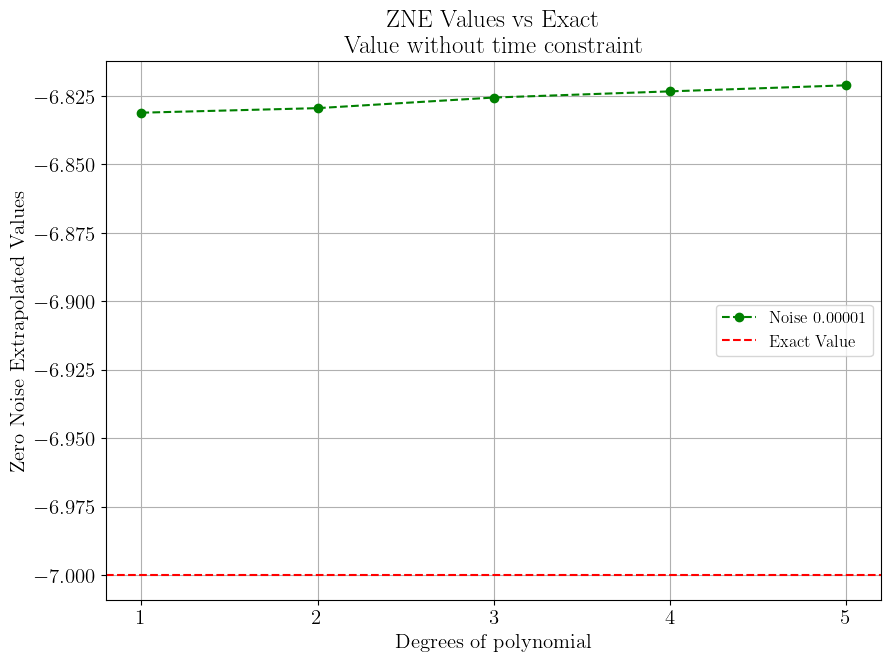

In [ ]:
# List of zne values for 8-qubit with noise probabilities [0.00001, 0.00001, 0.00001, 0.00001]

zne_vals_8Q_0_0000P = [
    zne_8Q_1D_noise1_val,
    zne_8Q_2D_noise1_val,
    zne_8Q_3D_noise1_val,
    zne_8Q_4D_noise1_val,
    zne_8Q_5D_noise1_val
]

# Corresponding labels which represents degrees of the polynomial
labels = ["1", "2", "3", "4", "5"]

# Plotting the graph
plt.figure(figsize=(10, 7))
plt.plot(labels, zne_vals_8Q_0_0000P, marker='o', linestyle='--', color='green', label='Noise 0.00001')
plt.axhline(y=exact_val_8Q, color='r', linestyle='--', label='Exact Value')
plt.xlabel('Degrees of polynomial')
plt.ylabel('Zero Noise Extrapolated Values')
plt.title('ZNE Values vs Exact \n Value without time constraint')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

The following is the configuration for our indirect circuit.

```qubit = 8
layer = 25
noise probabilities = [0.0001, 0.0001, 0.0001, 0.0001]
exact solution = -7.000000000000004
```

We ran our indirect eigen solver at various noise level by changing the `factor` value inside the `config.yml`

In [ ]:
data_sys1 = [
    (4, 1, 0, -6.742247461826676),
    (12, 3, 8, -6.405455124800368),
    (12, 5, 24, -5.839787462274414),
    (4, 7, 8, -5.991097523966149),
    (4, 7, 24, -5.533783365921837),
    (28, 9, 24, -5.005206166353052),
    (4, 9, 56, -4.206331147604706),
    (44, 1, 24, -6.357848309361182),
    (44, 3, 24, -5.9516342852267075),
    (4, 13, 8, -5.328222900577986)
]

zne_sys1 = ZeroNoiseExtrapolation(dataPoints= data_sys1, degree= 2)
zne_sys1.getRichardsonZNE()



-6.821098781914534

System #2

```qubit = 8
layer = 25
noise probabilities = [0.000001, 0.000001, 0.000001, 0.000001]
exact solution = -7.000000000000004
```


In [ ]:
data_set2 = [
    (4, 1, 0, -6.254792723611204),
    (12, 3, 8, -6.250858745027363),
    (12, 5, 8, -6.2478883834002135),
    (4, 5, 24, -6.244810370105138),
    (20, 5, 24, -6.242889589082837),
    (4, 7, 24, -6.239825585489937),
    (12, 7, 40, -6.2328185853721925),
    (12, 1, 40, -6.253830617363461),
    (4, 11, 8, -6.23994604760344),
    (12, 11, 8, -6.238986354642458)
]

zne_set2 = ZeroNoiseExtrapolation(dataPoints = data_set2, degree = 2)
zne_set2.getRichardsonZNE()
-6.256252868096004

-6.256252868096004